In [2]:
from typing import List

import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.auto import tqdm
import os.path as osp
from config import BASIC_CONFIG, FT_NET_CFG, SHAPE_EMBEDDING_CFG
from src.datasets.get_loader import get_train_loader
from src.models.baseline import Baseline
import matplotlib.pyplot as plt 

In [3]:
file_path = "pretrained/net_last1.pth"

content = torch.load(file_path)

del content['classifier.classifier.0.weight']
del content['classifier.classifier.0.bias']

In [5]:
torch.save(content, 'pretrained/net_pretrained_market.pth')

In [5]:
train_loader, num_classes, dataset_size = get_train_loader()

model = Baseline(shape_edge_index=SHAPE_EMBEDDING_CFG.EDGE_INDEX,
                shape_pose_n_features=SHAPE_EMBEDDING_CFG.POSE_N_FEATURES,
                shape_n_hidden=SHAPE_EMBEDDING_CFG.N_HIDDEN,
                shape_out_features=SHAPE_EMBEDDING_CFG.OUT_FEATURES,
                shape_relation_layers=SHAPE_EMBEDDING_CFG.RELATION_LAYERS,
                class_num=num_classes,
                train_shape=BASIC_CONFIG.TRAIN_SHAPE,
                dataset_size=dataset_size,
                r50_stride=FT_NET_CFG.R50_STRIDE,
                r50_pretrained_weight=FT_NET_CFG.PRETRAINED, lr=BASIC_CONFIG.LR)

In [7]:
weights_path = "work_space/save/model_ltcc_60epochs_0.05lr_fromscratch.pth"

model.load_state_dict(torch.load(weights_path), strict=False)

_IncompatibleKeys(missing_keys=['shape_embedding.refine_net.position_embedding.position_embedding.0.weight', 'shape_embedding.refine_net.position_embedding.position_embedding.0.bias', 'shape_embedding.refine_net.fc.weight', 'shape_embedding.refine_net.fc.bias', 'shape_embedding.relation_net.gcn_1.bias', 'shape_embedding.relation_net.gcn_1.lin.weight', 'shape_embedding.relation_net.gcn_2.bias', 'shape_embedding.relation_net.gcn_2.lin.weight', 'fusion.appearance_net.0.weight', 'fusion.appearance_net.0.bias', 'fusion.shape_net.0.weight', 'fusion.shape_net.0.bias', 'fusion.theta.theta', 'id_classification.weight', 'id_classification.bias'], unexpected_keys=[])

In [8]:
watcher = weightwatcher.WeightWatcher(model=model)

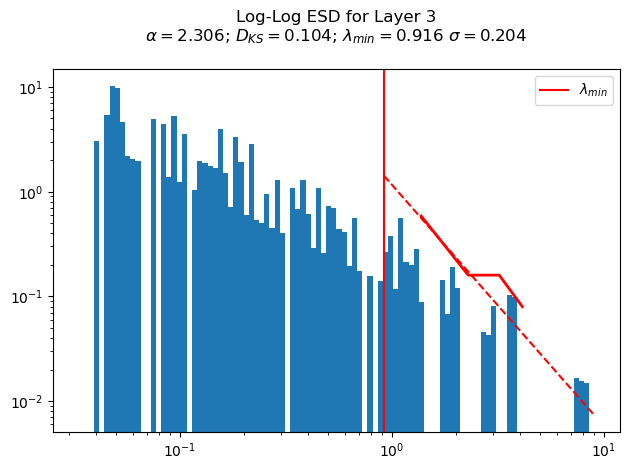

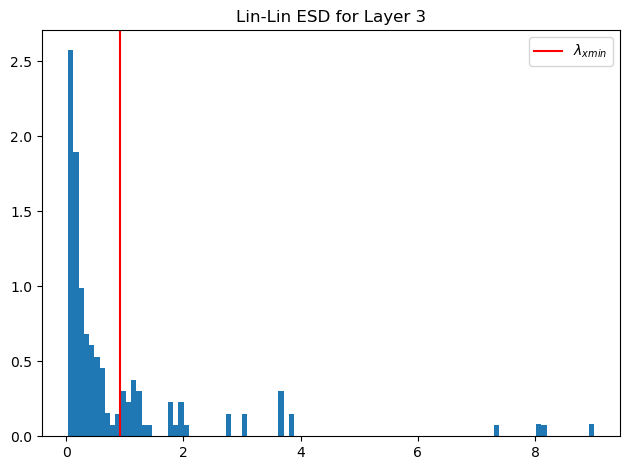

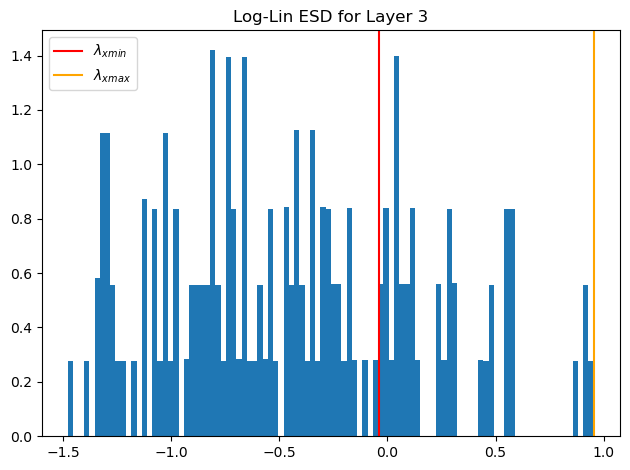

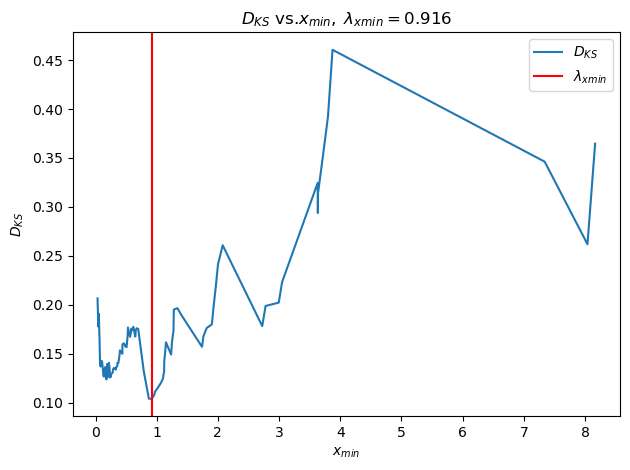

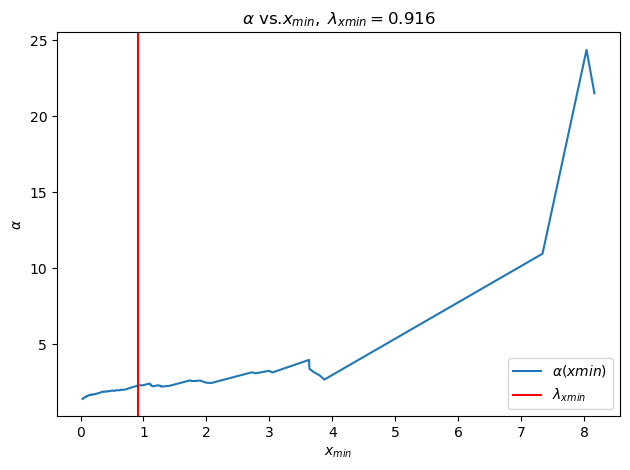

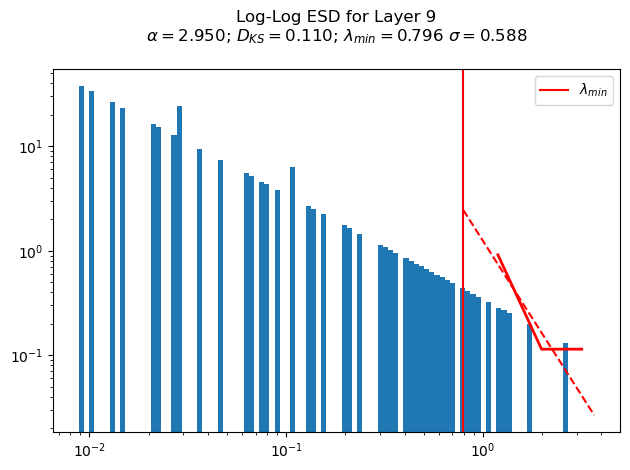

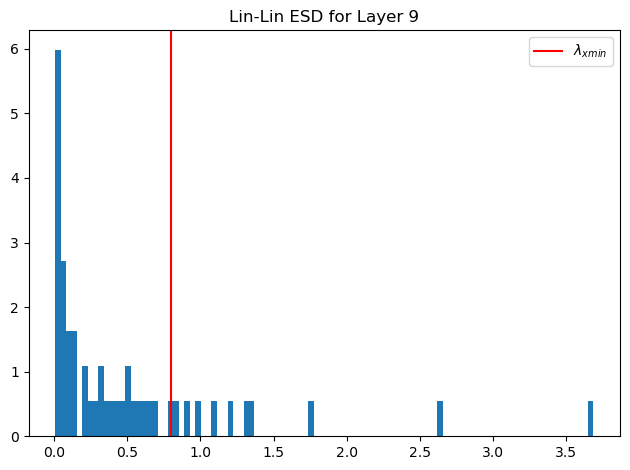

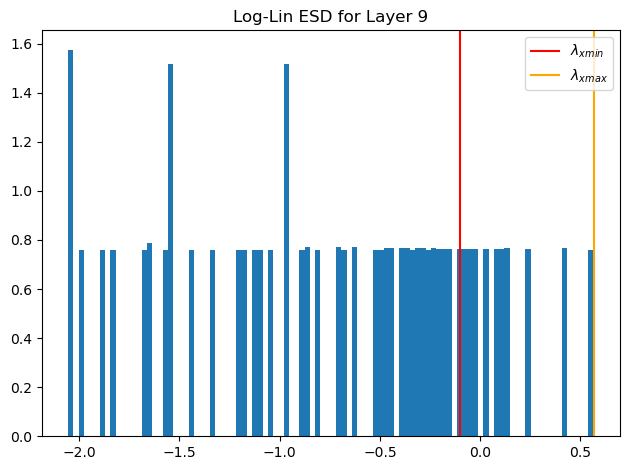

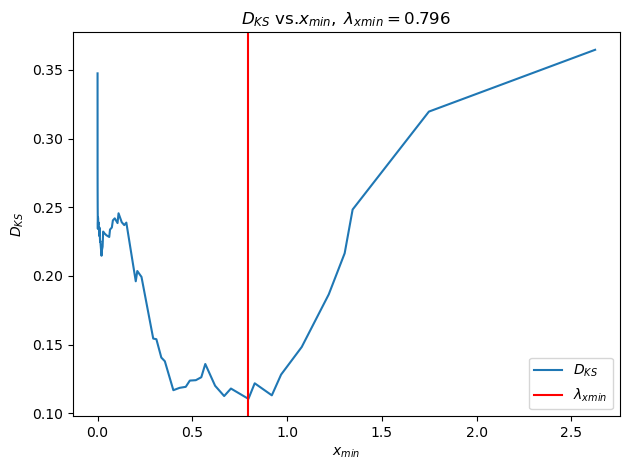

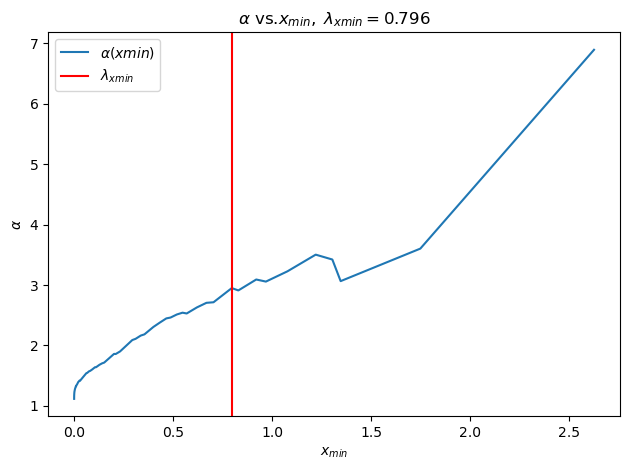

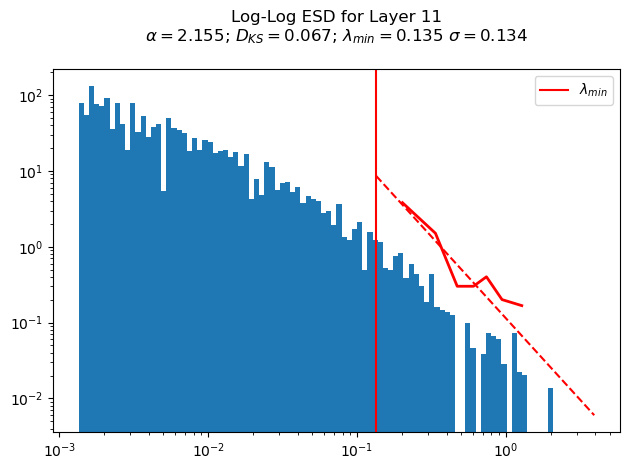

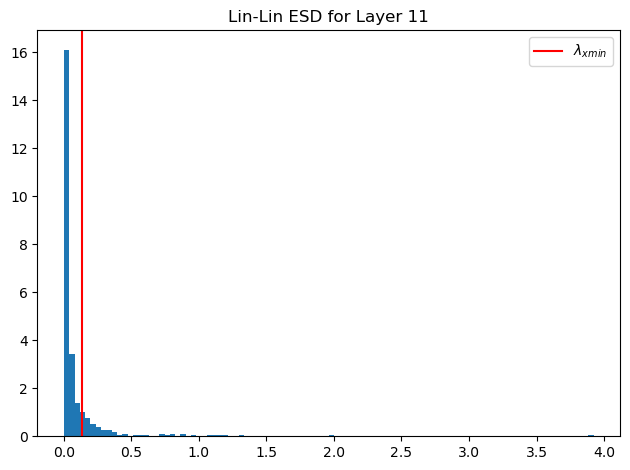

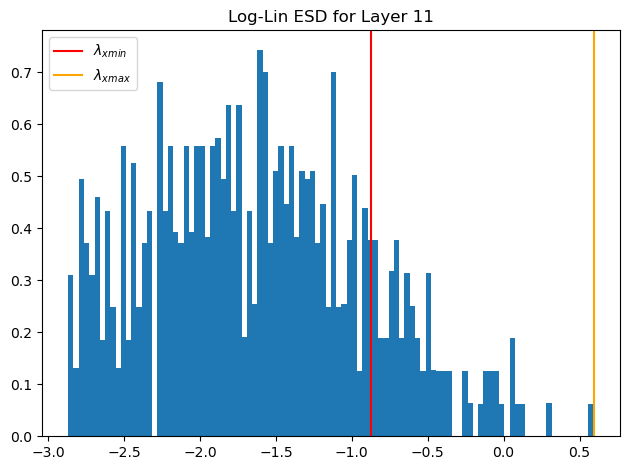

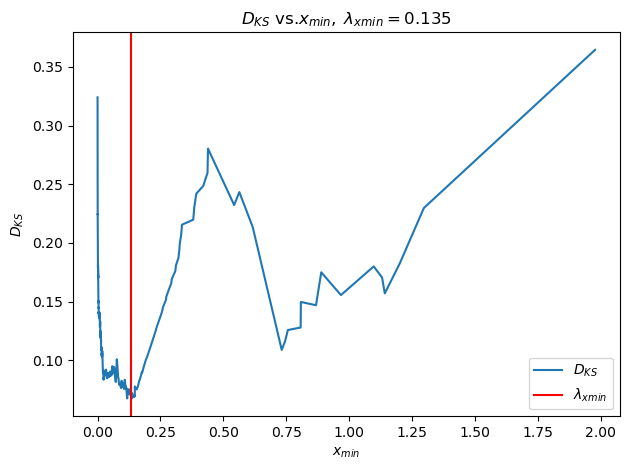

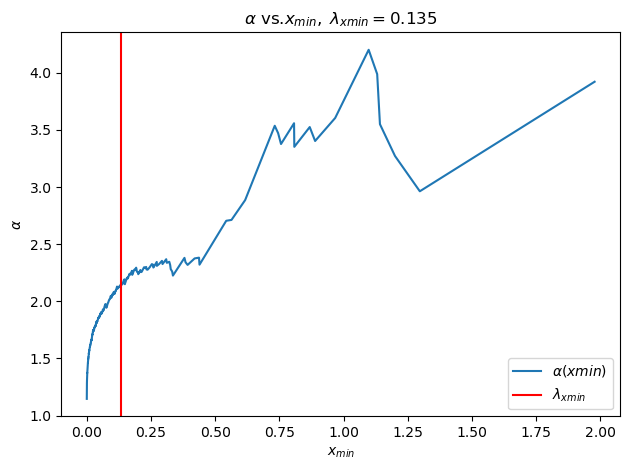

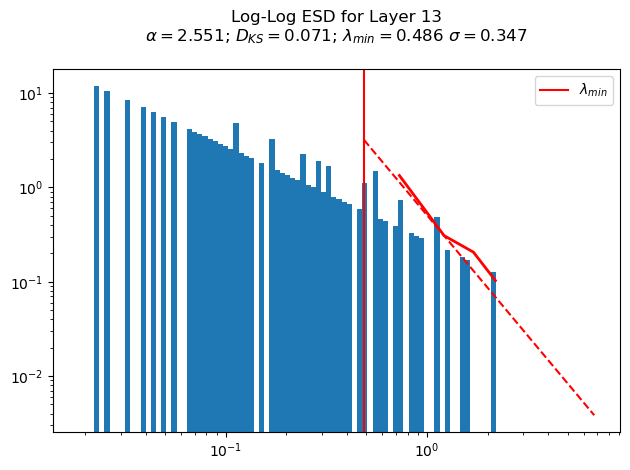

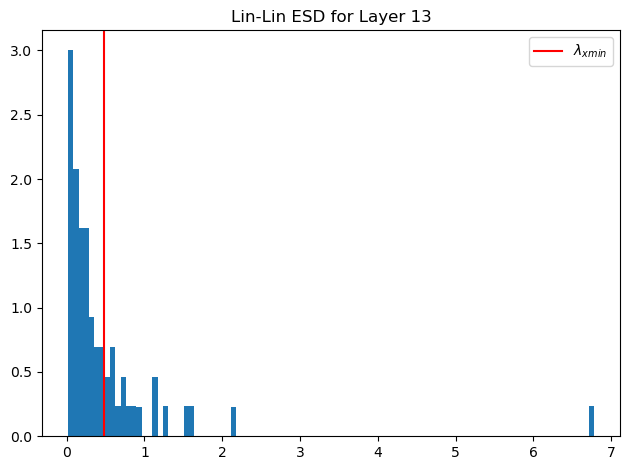

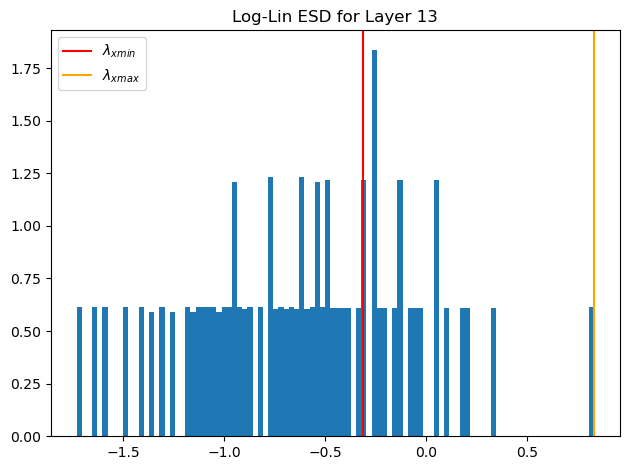

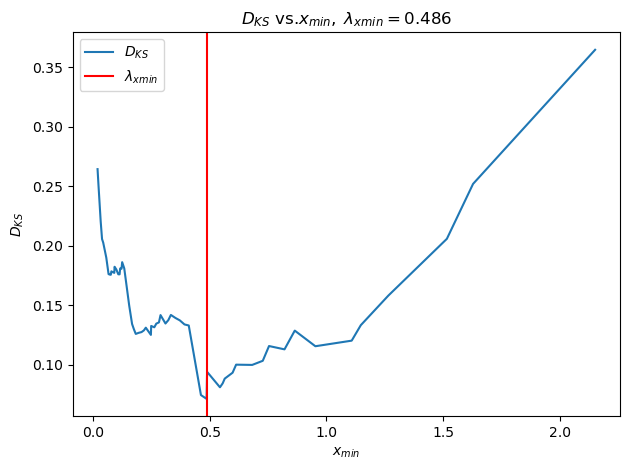

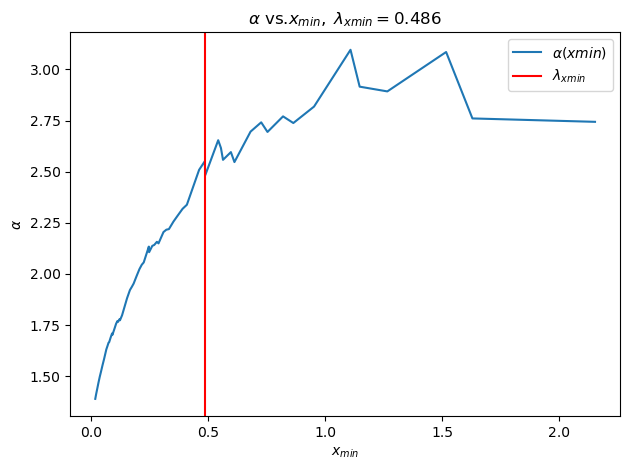

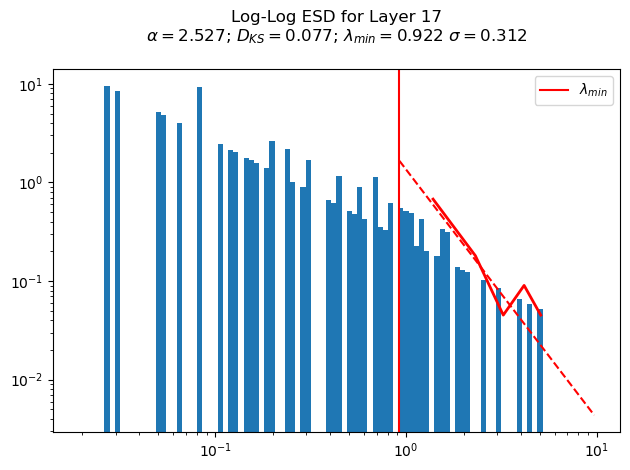

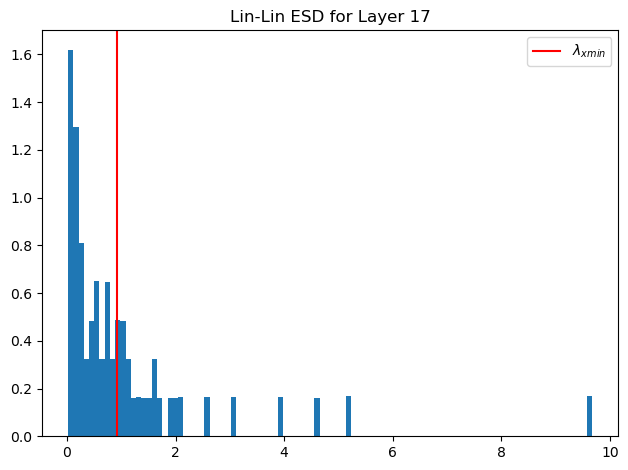

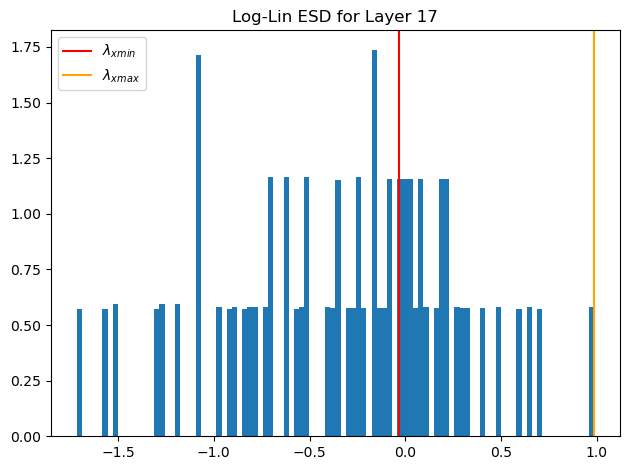

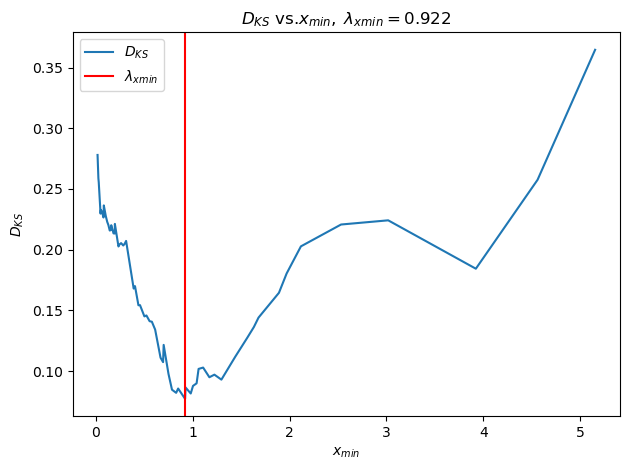

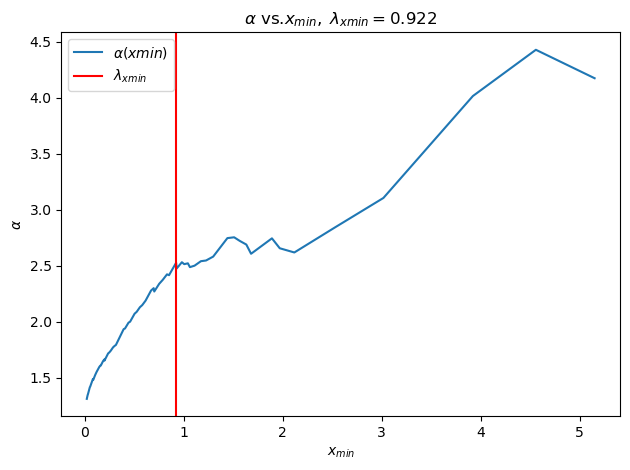

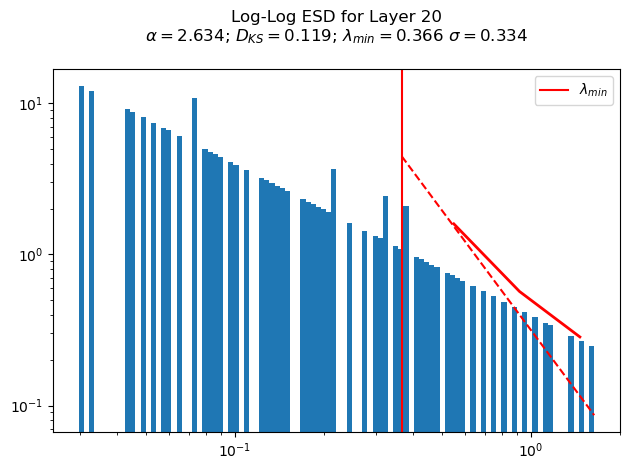

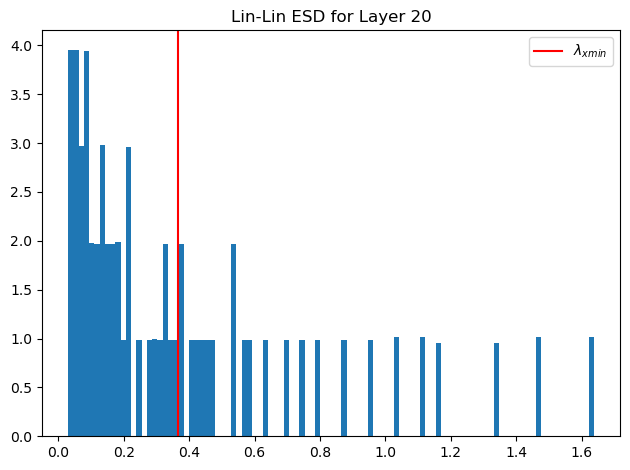

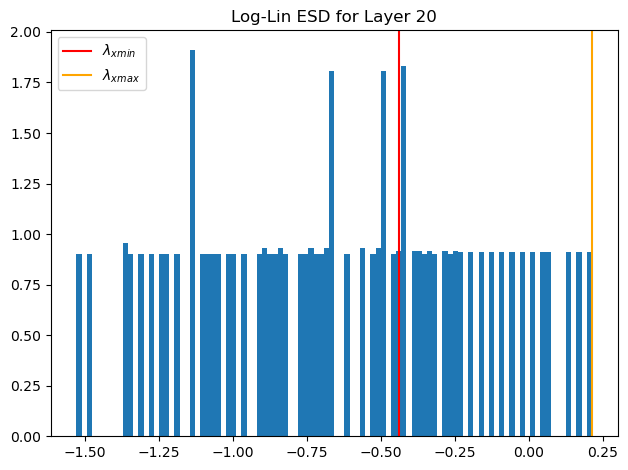

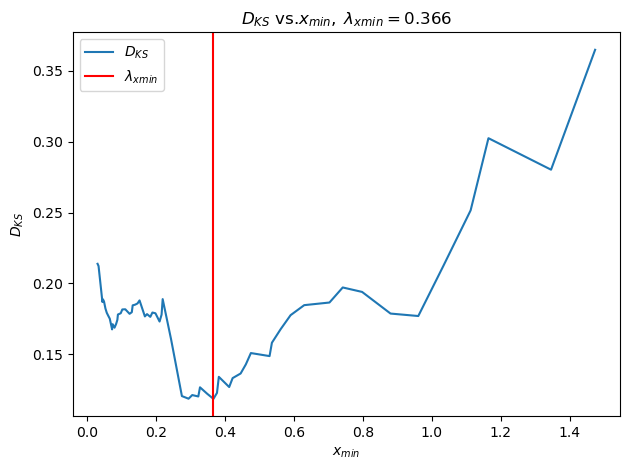

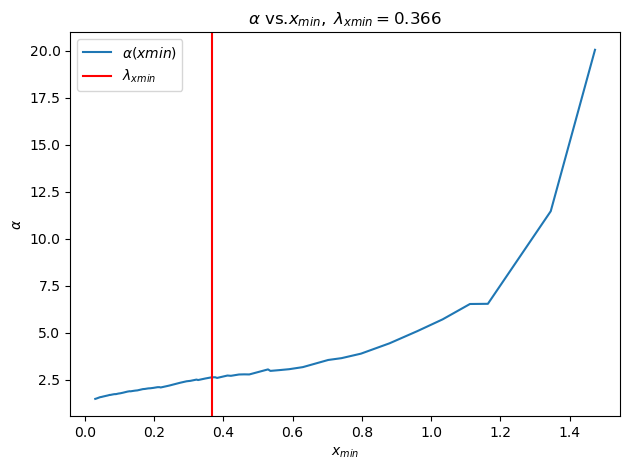

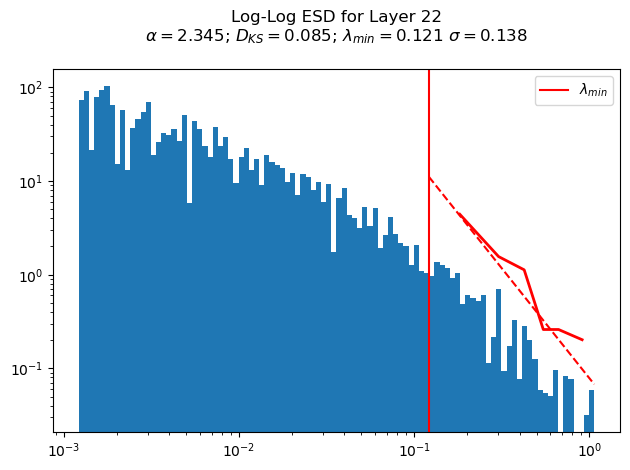

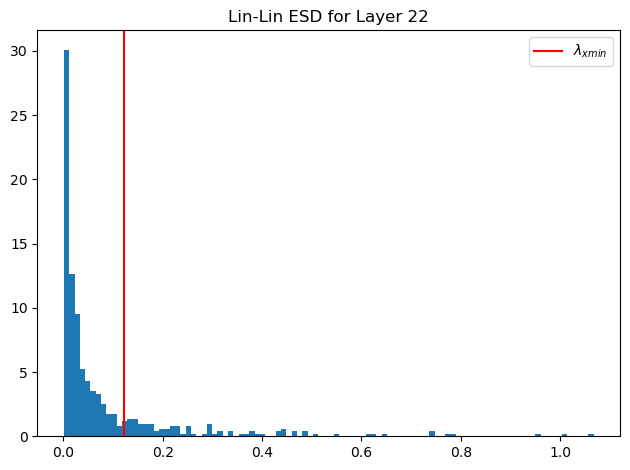

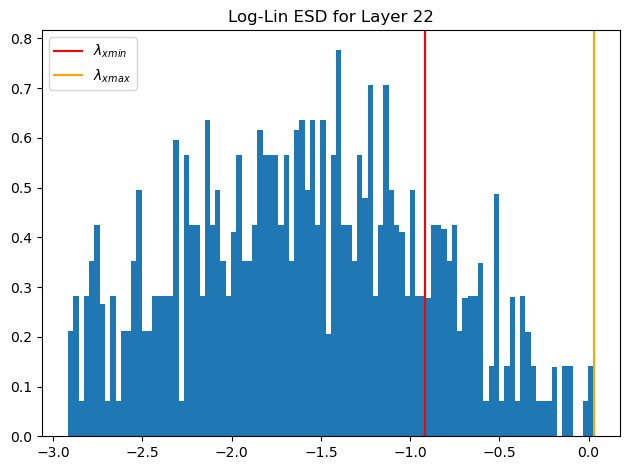

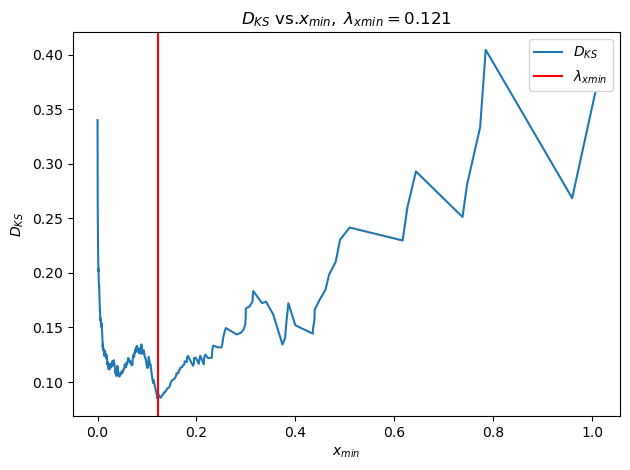

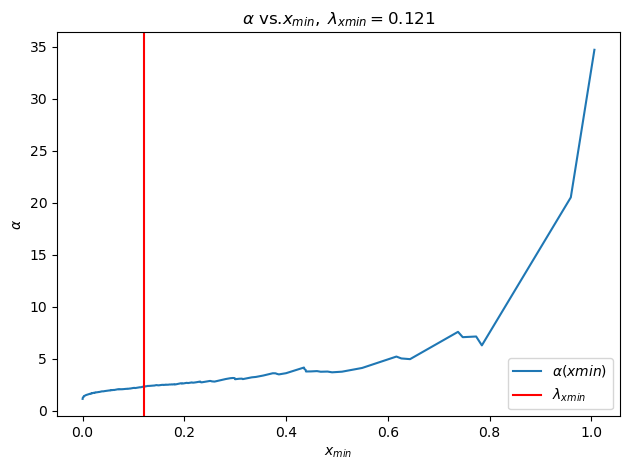

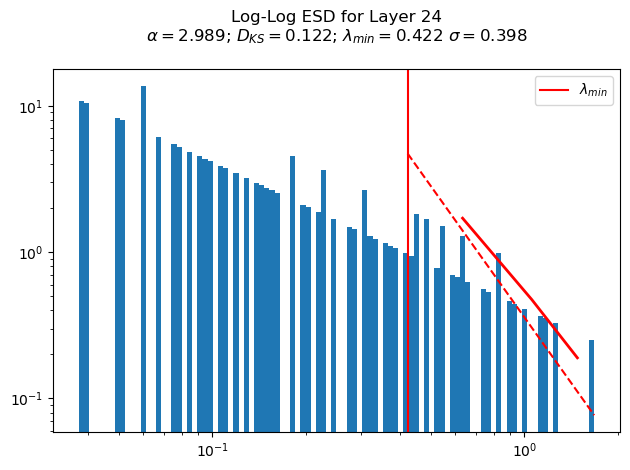

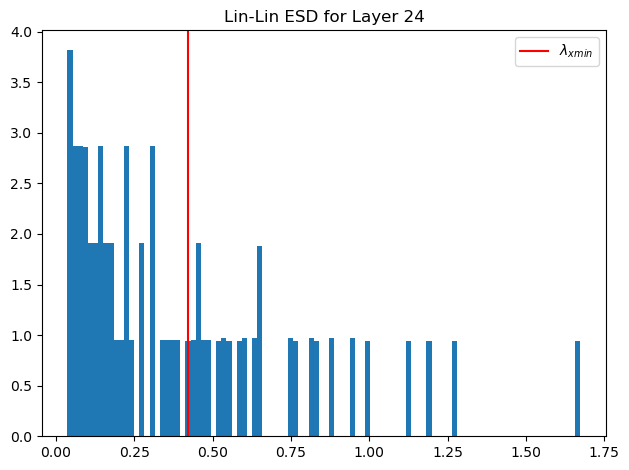

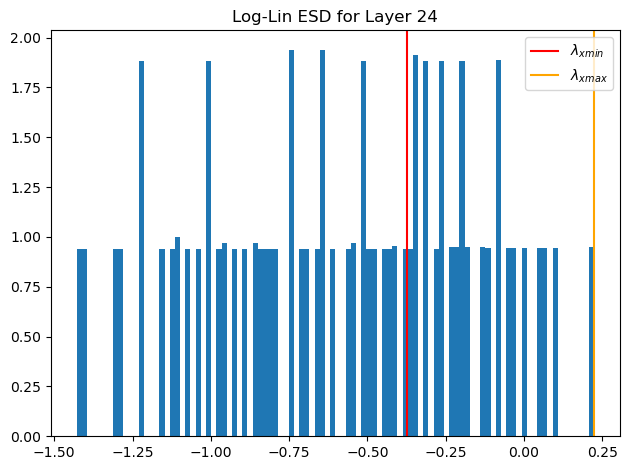

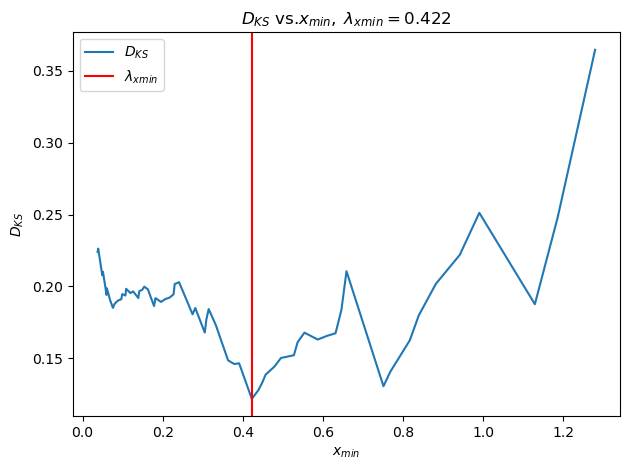

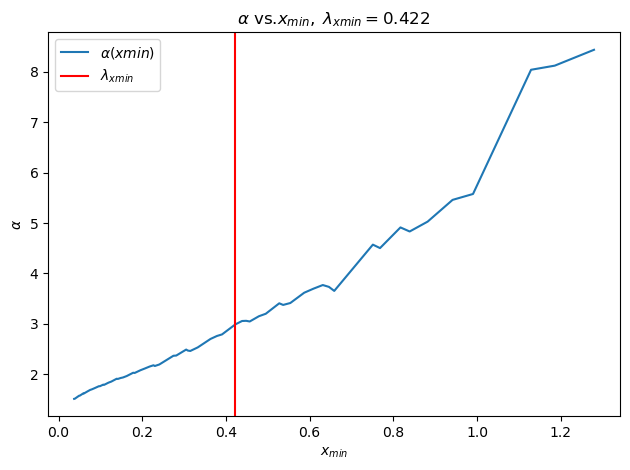

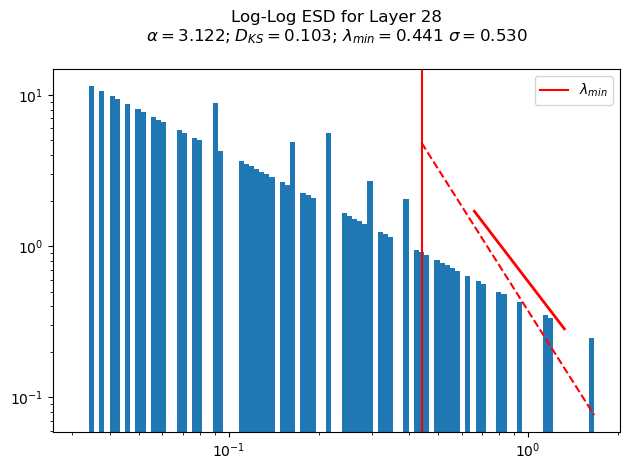

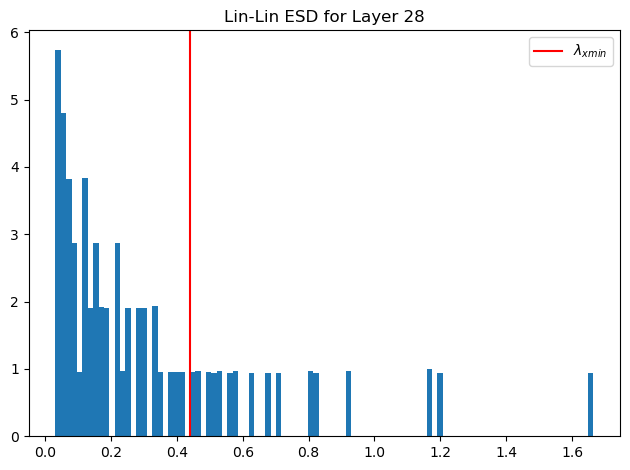

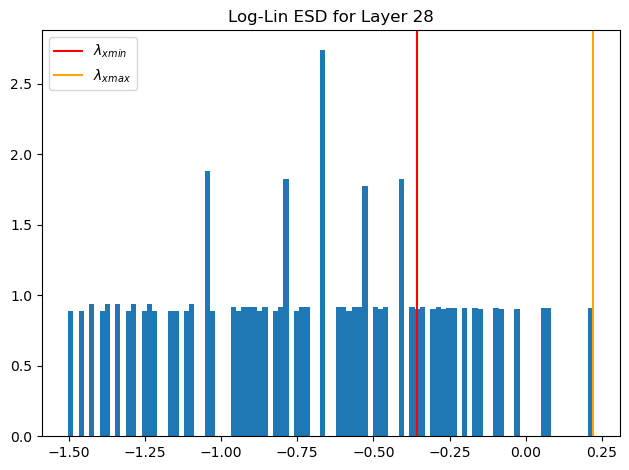

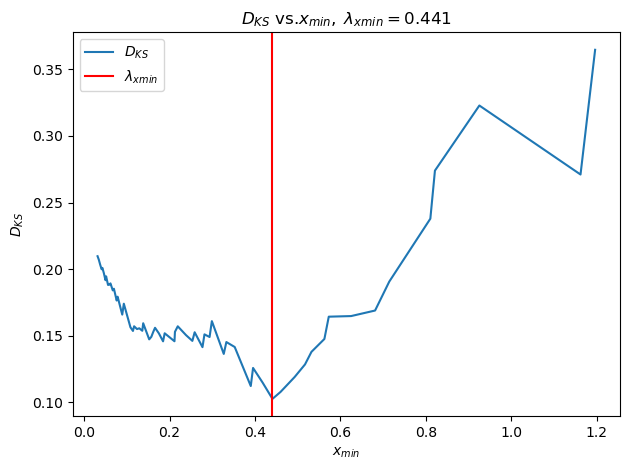

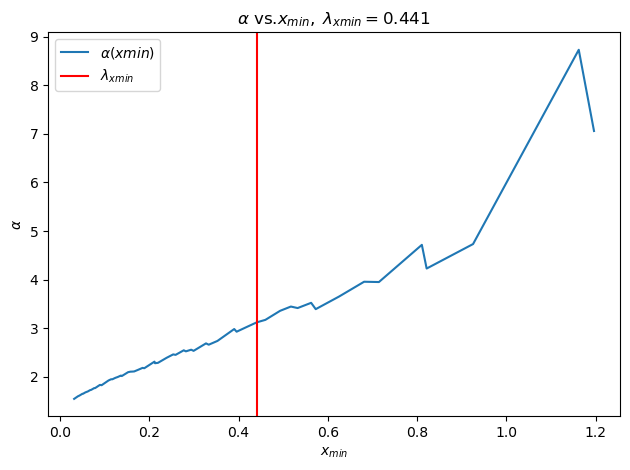

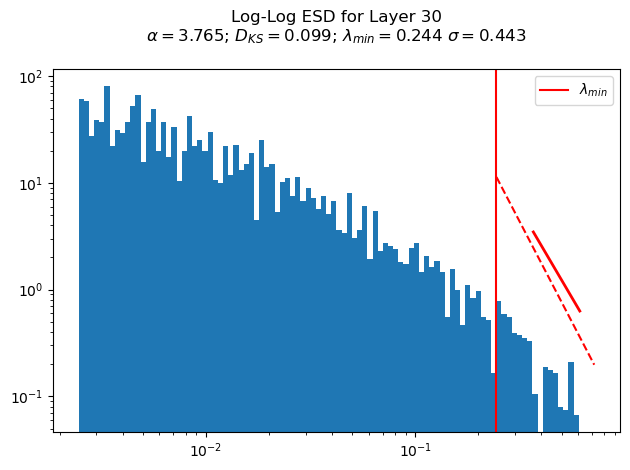

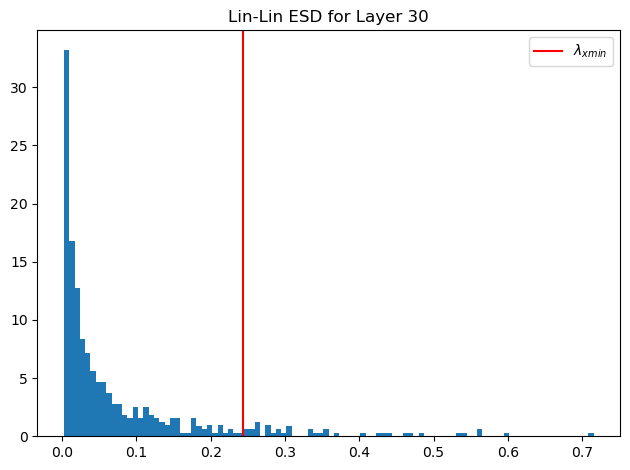

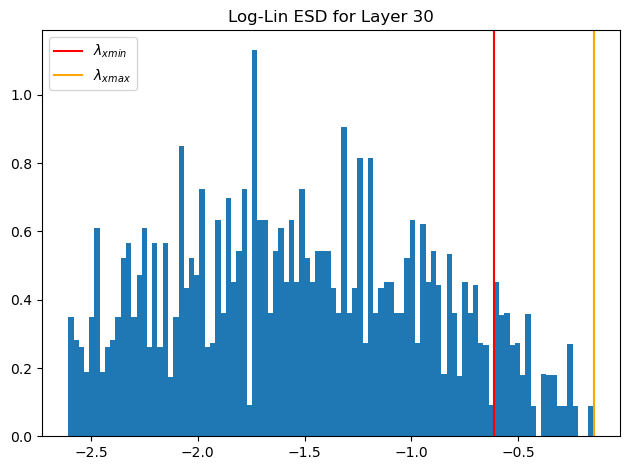

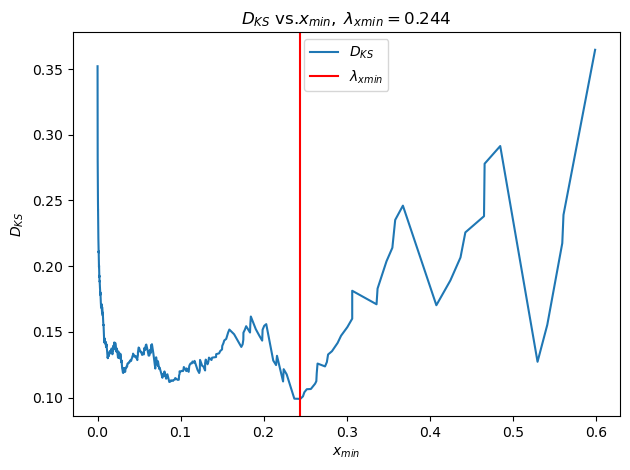

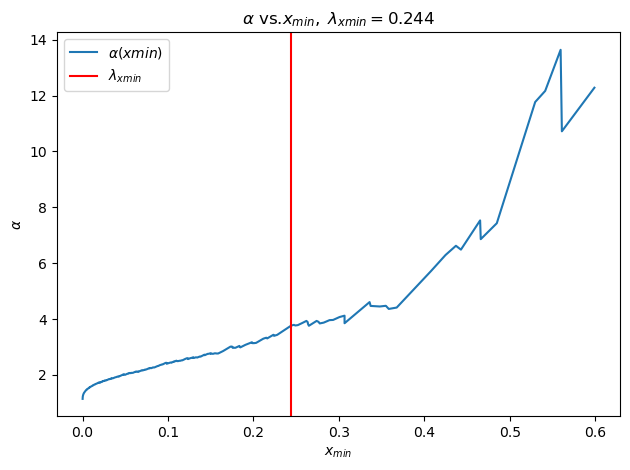

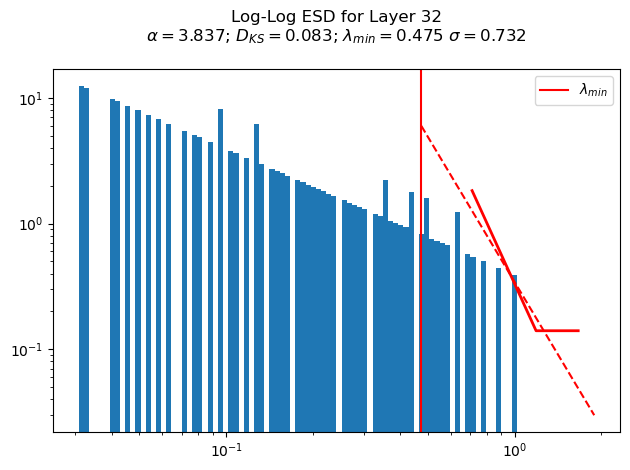

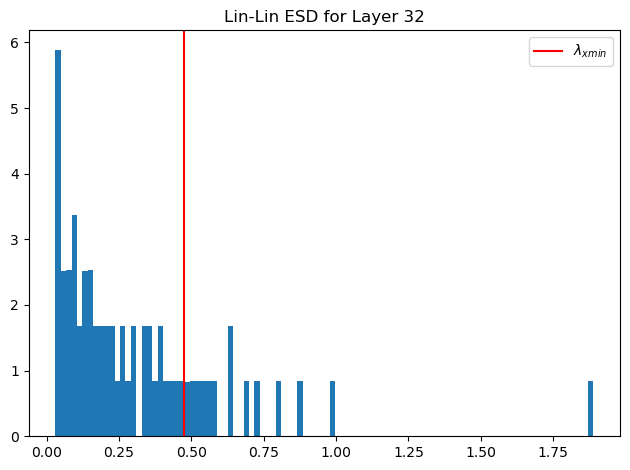

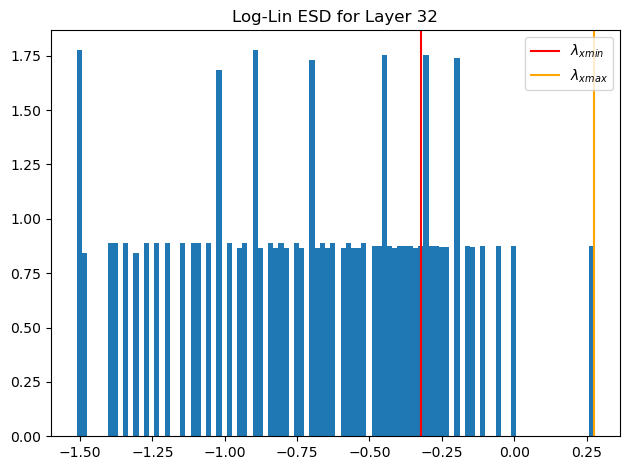

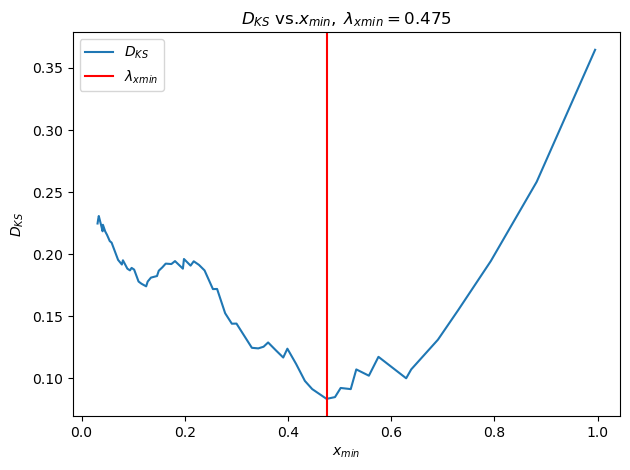

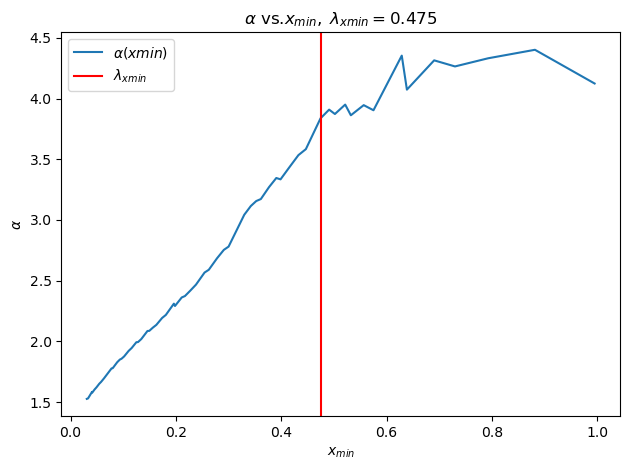

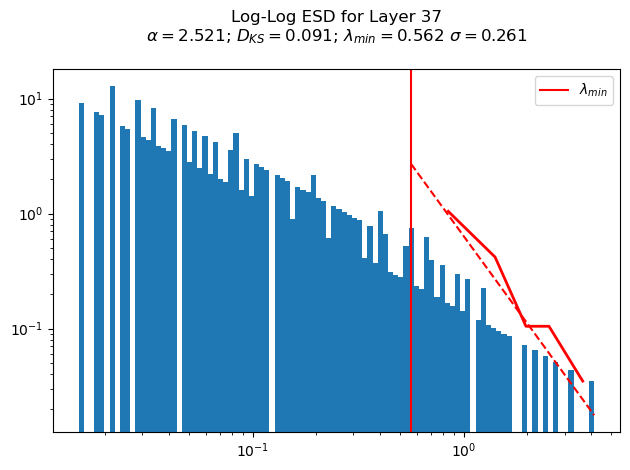

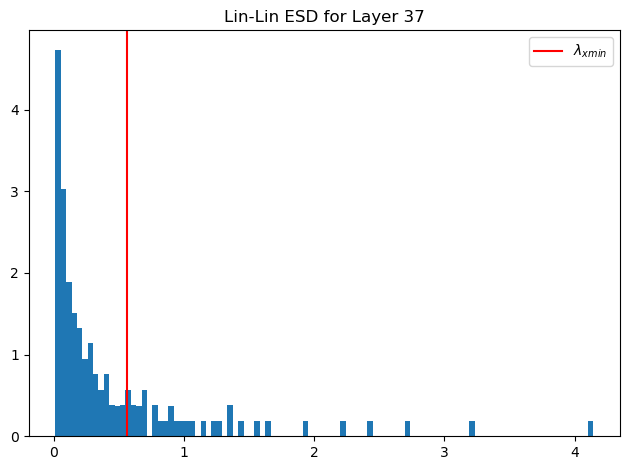

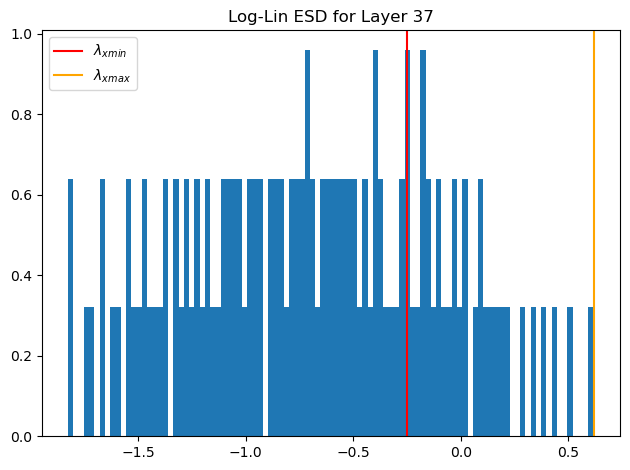

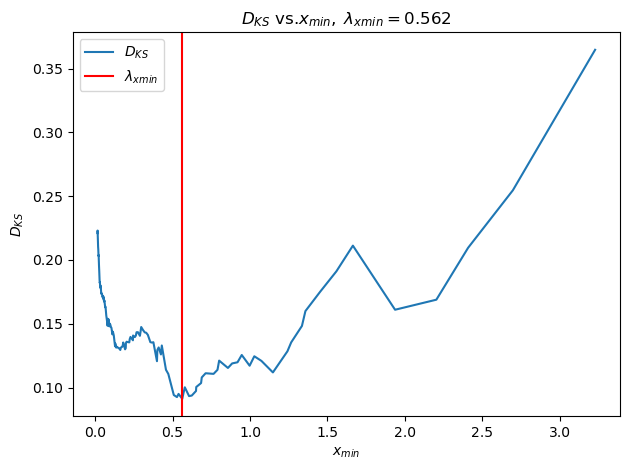

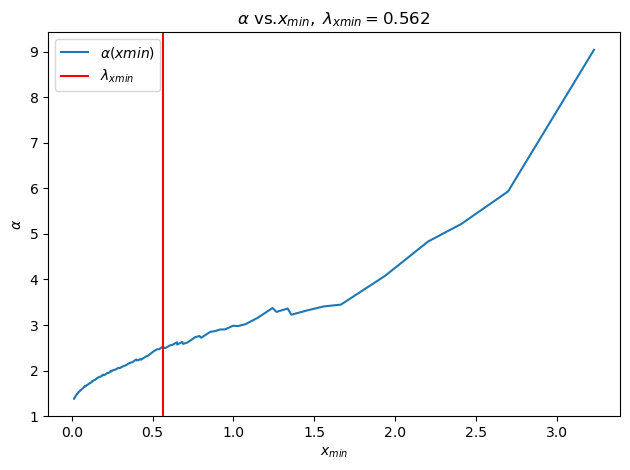

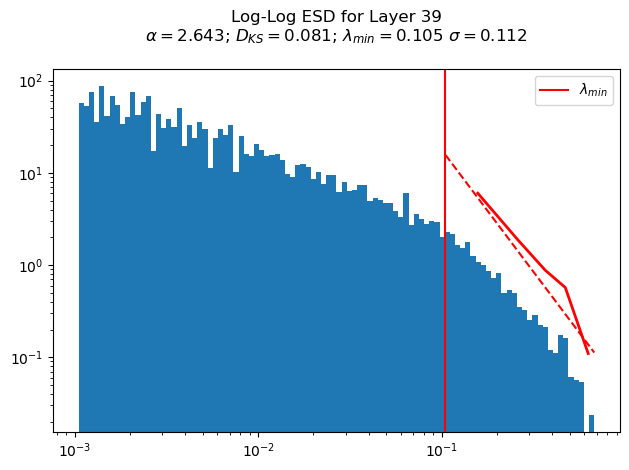

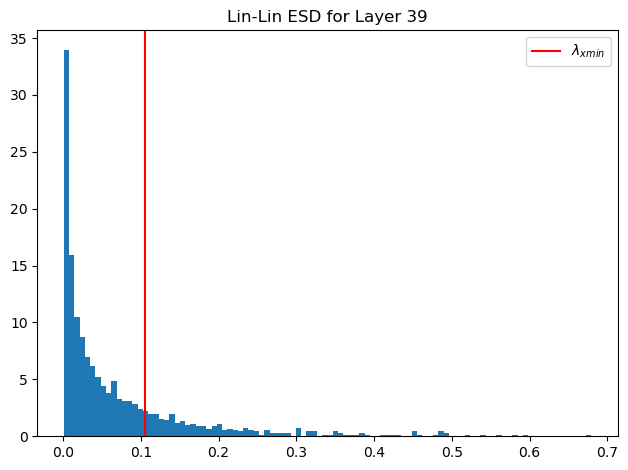

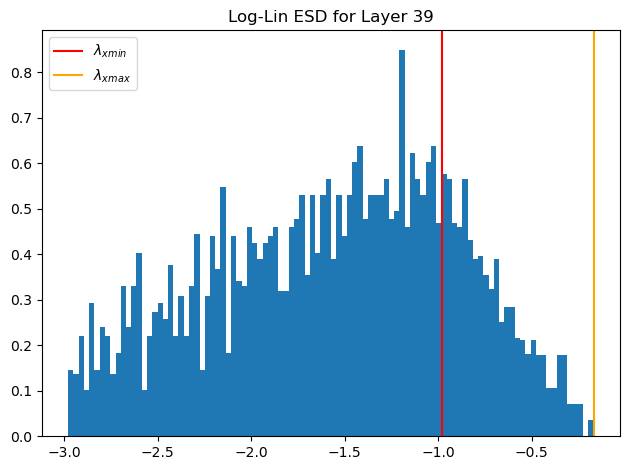

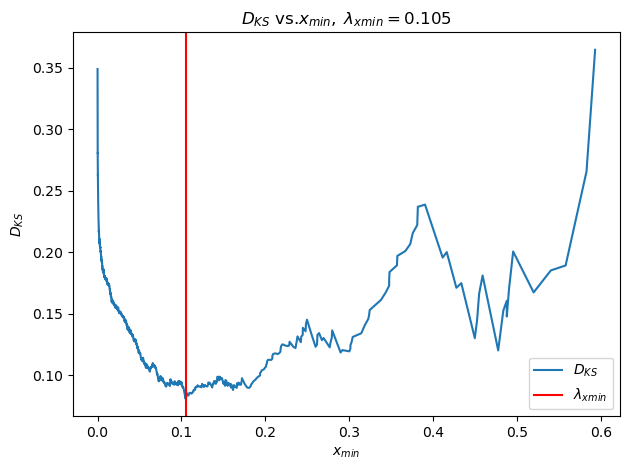

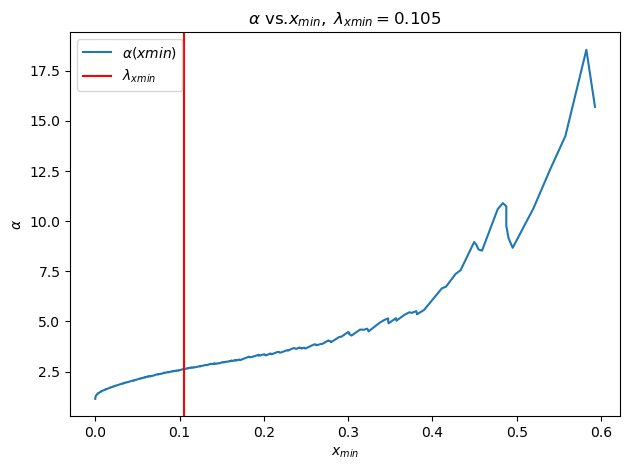

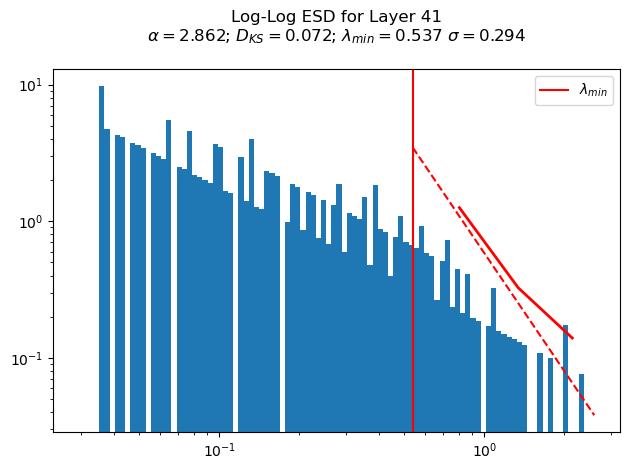

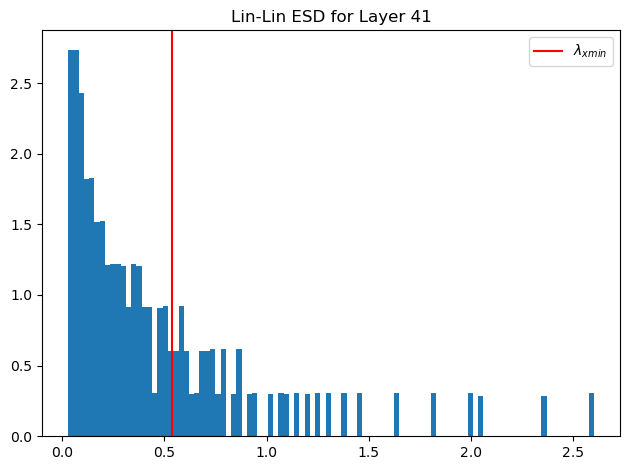

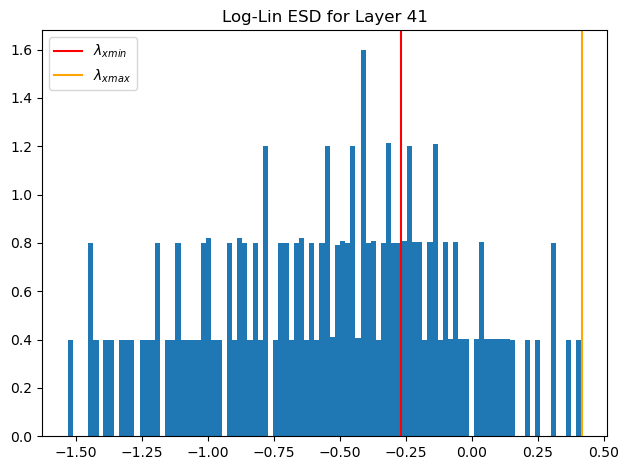

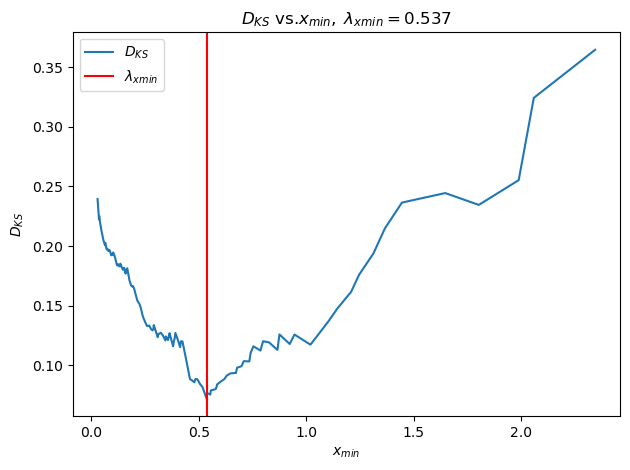

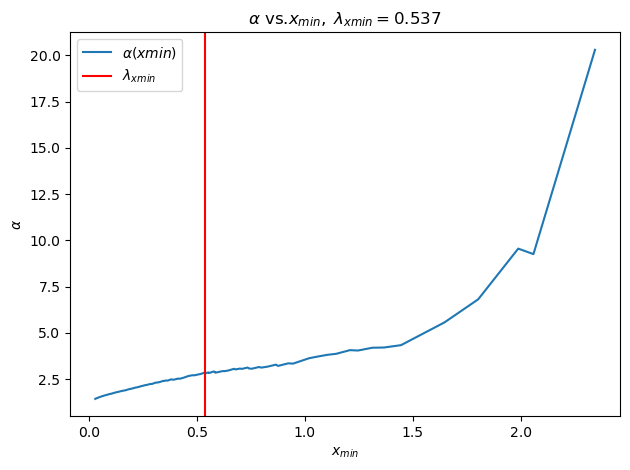

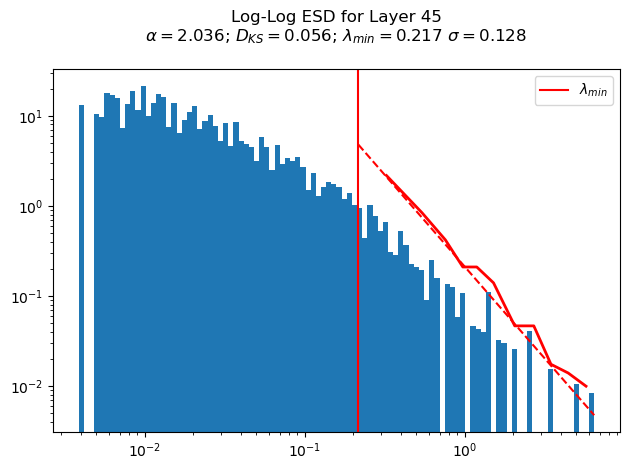

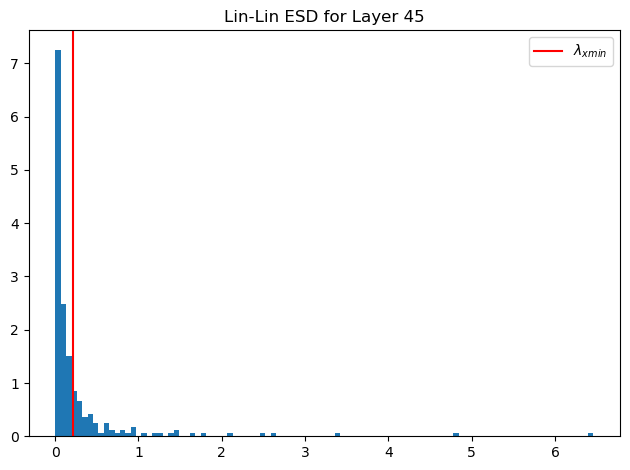

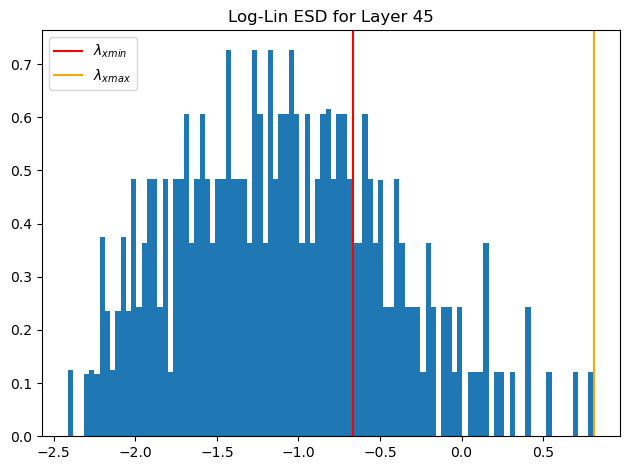

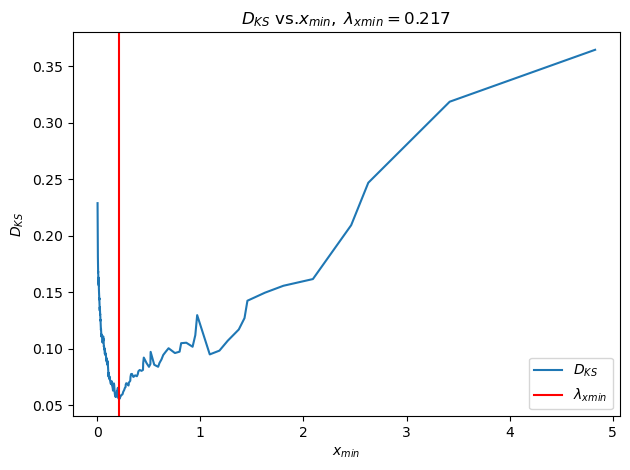

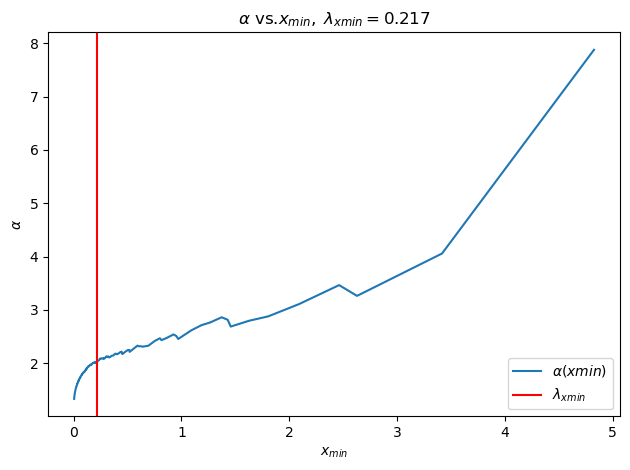

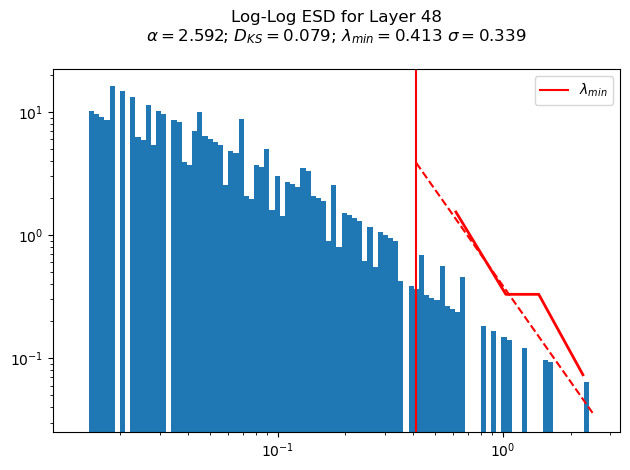

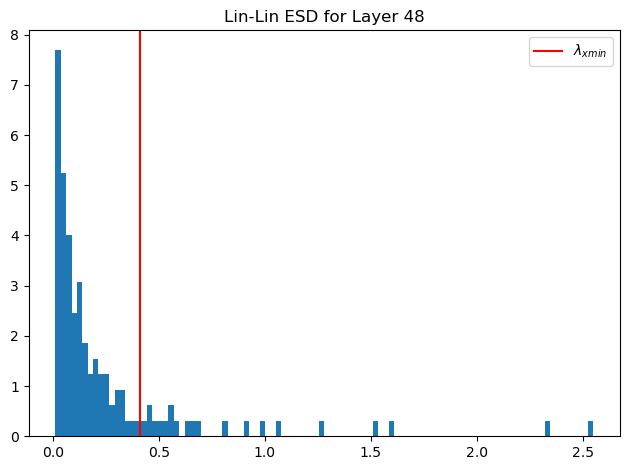

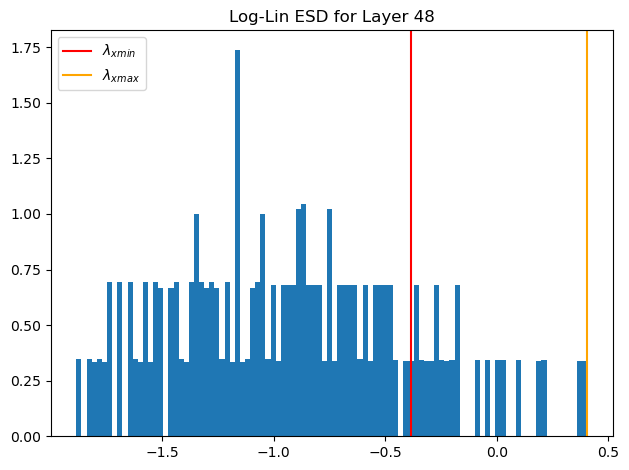

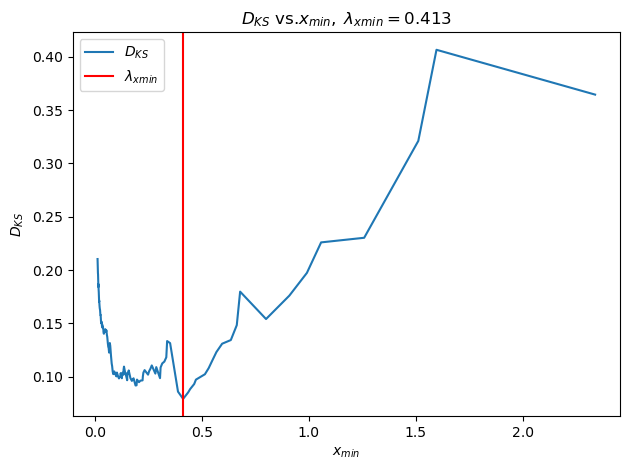

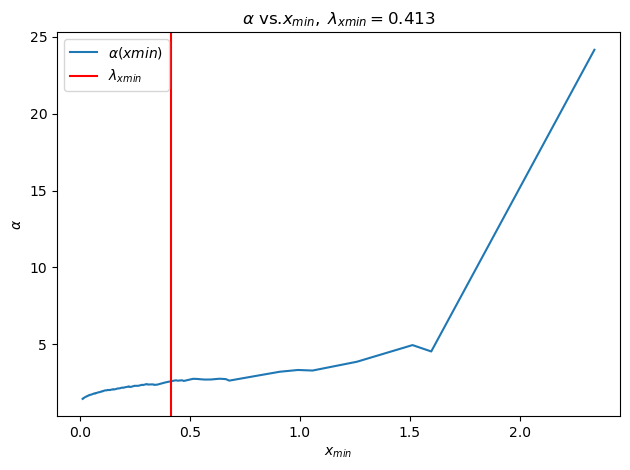

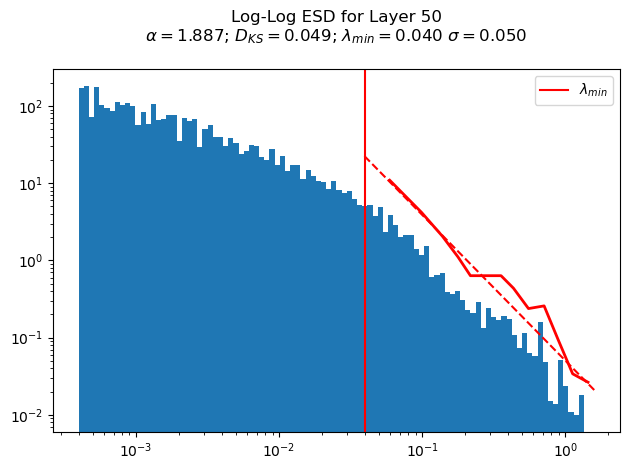

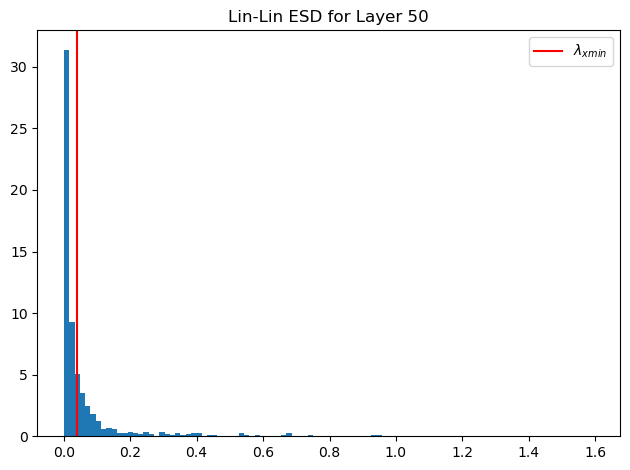

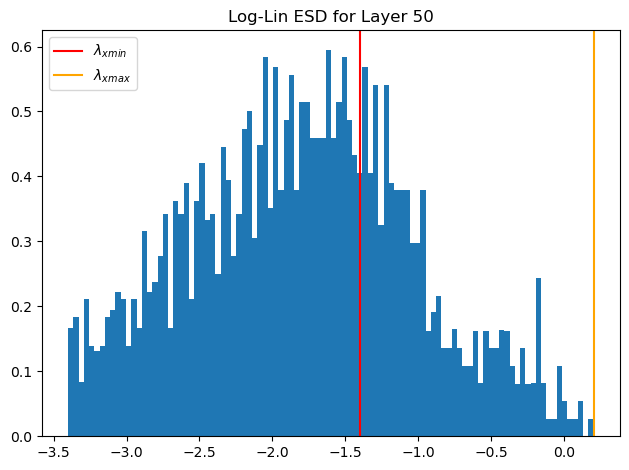

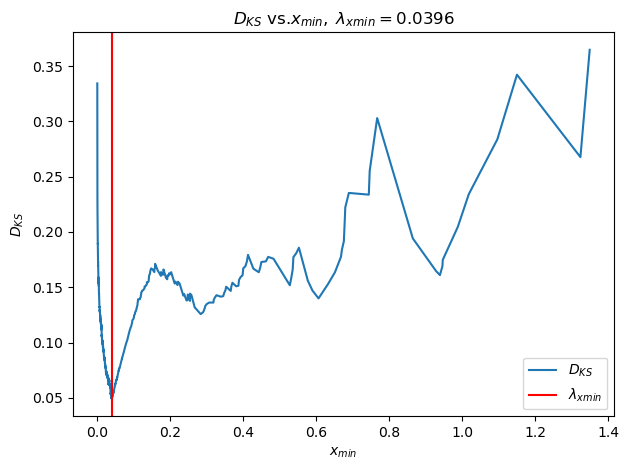

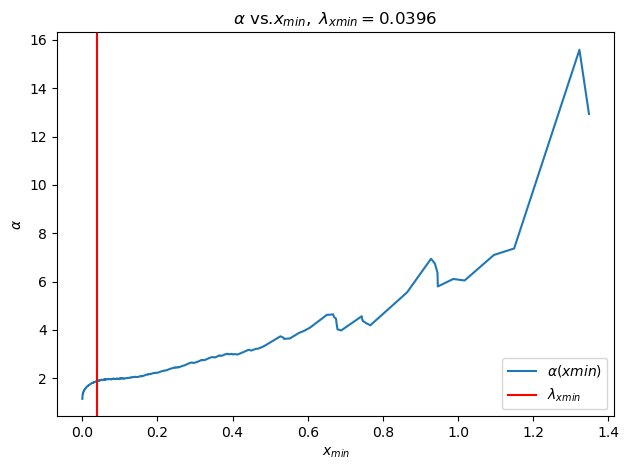

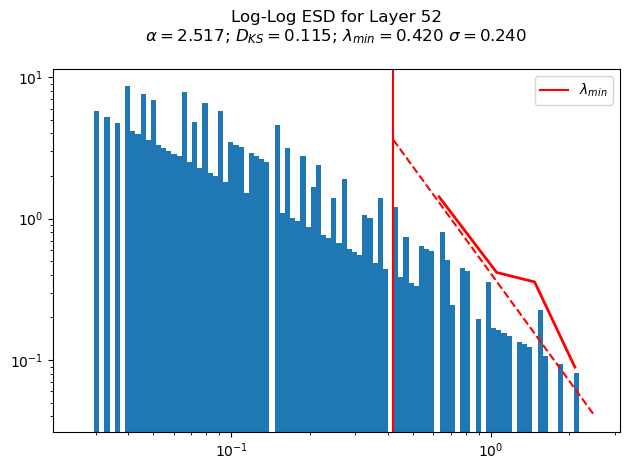

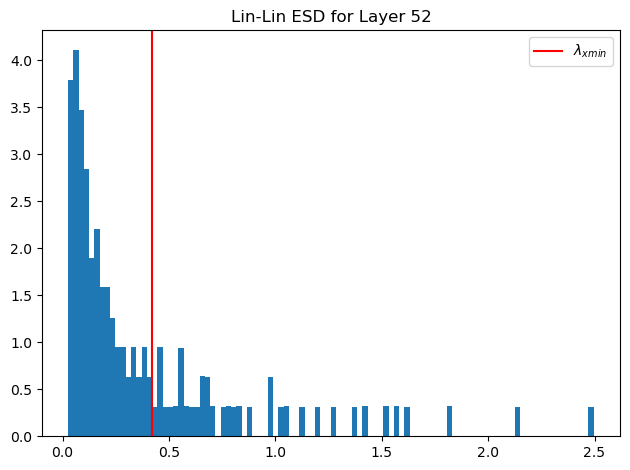

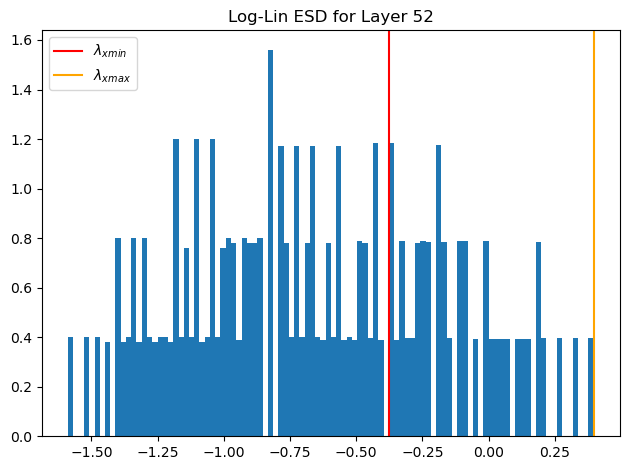

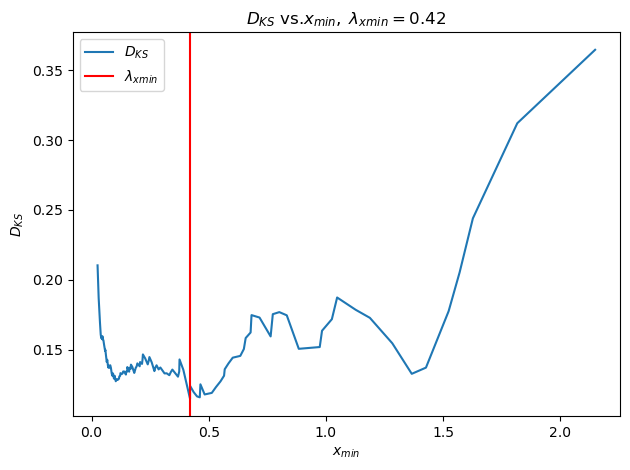

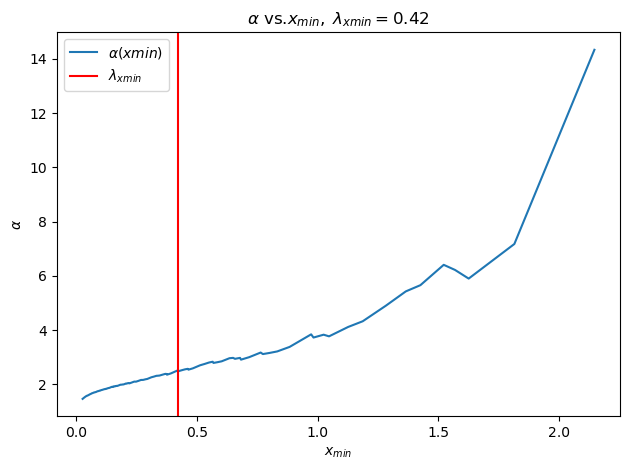

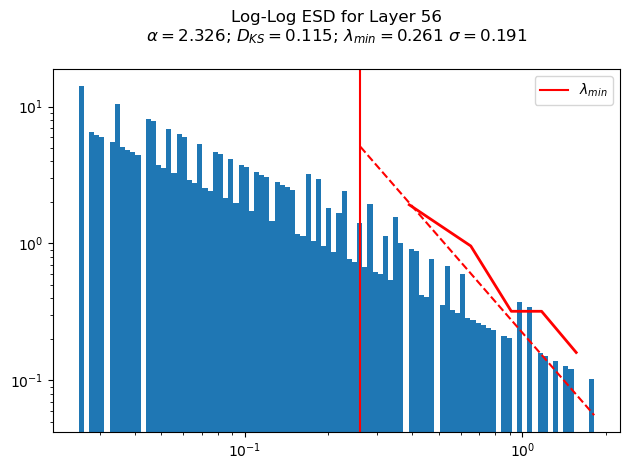

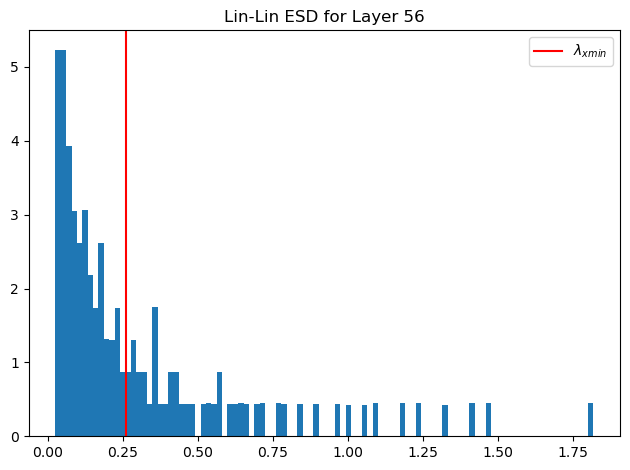

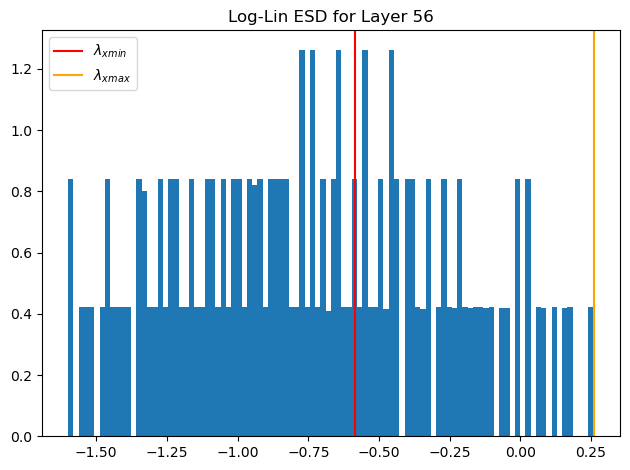

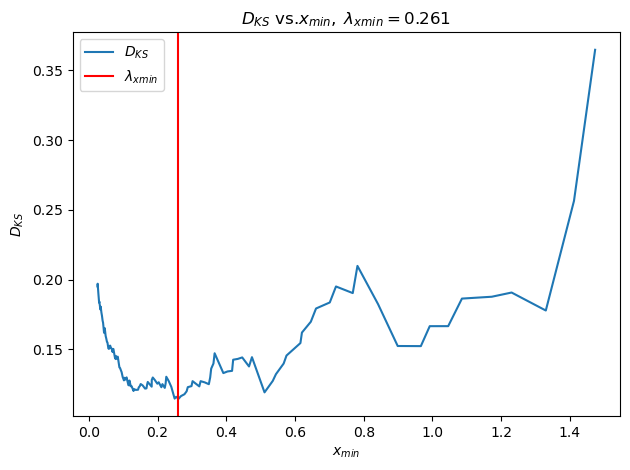

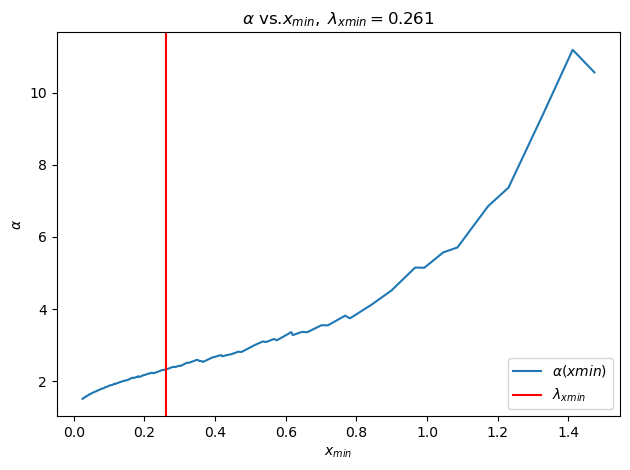

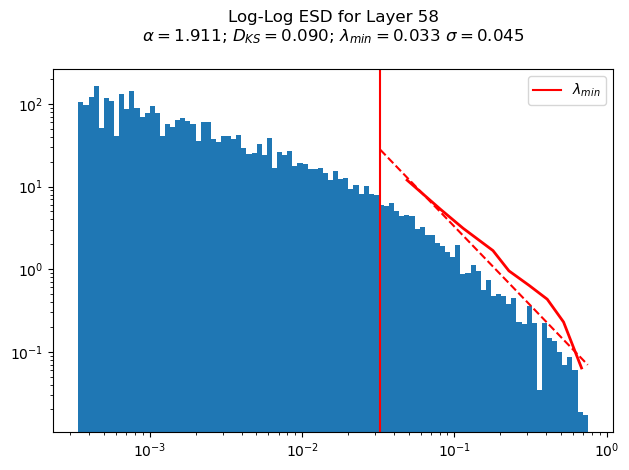

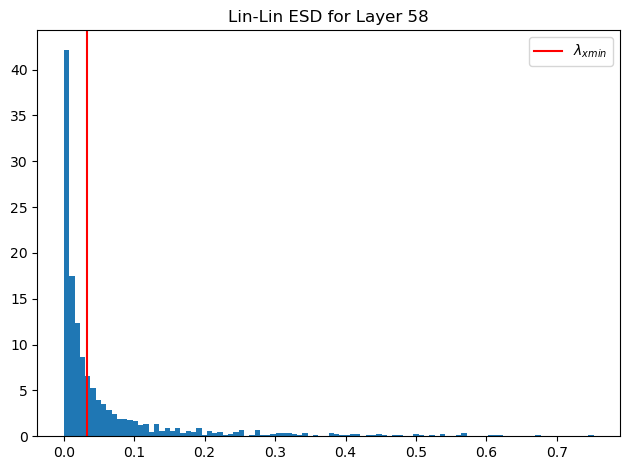

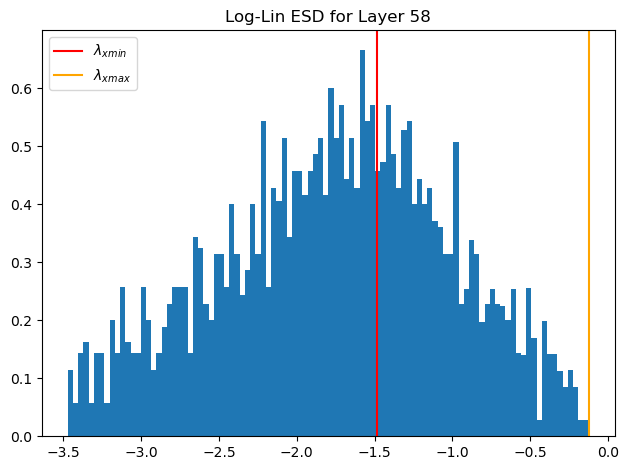

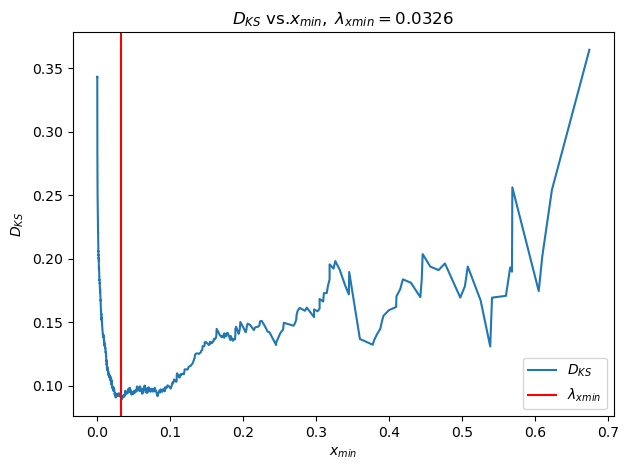

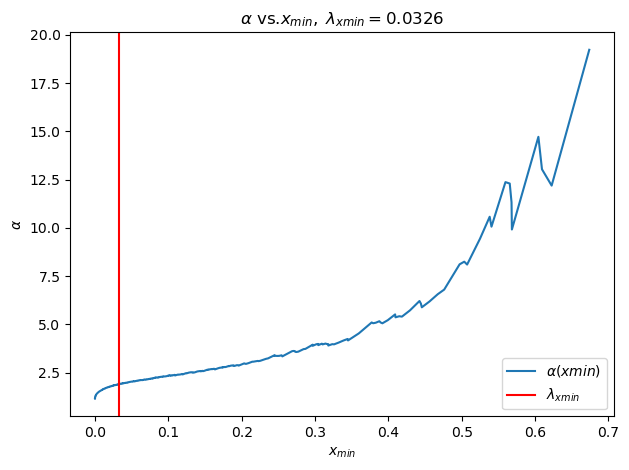

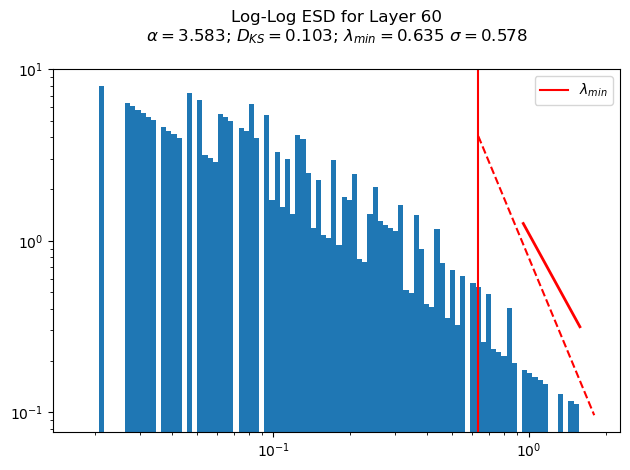

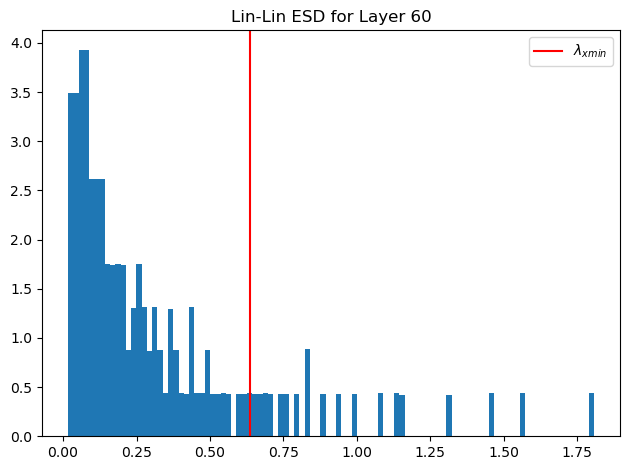

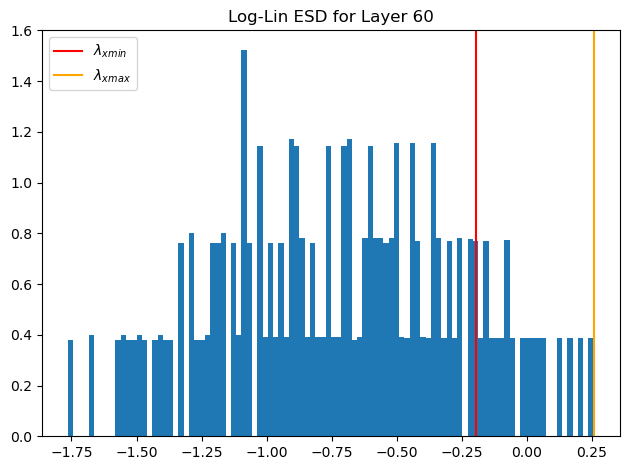

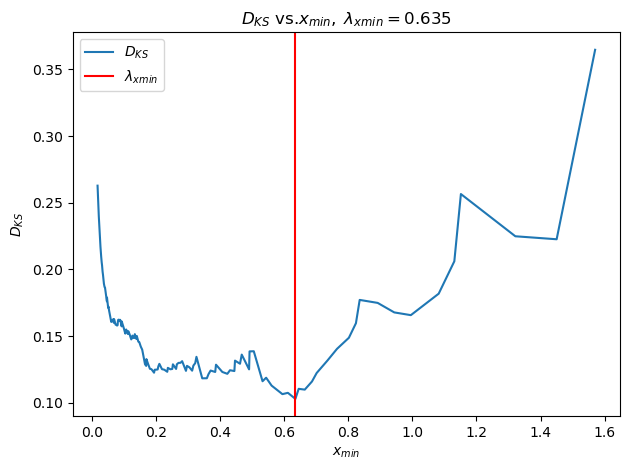

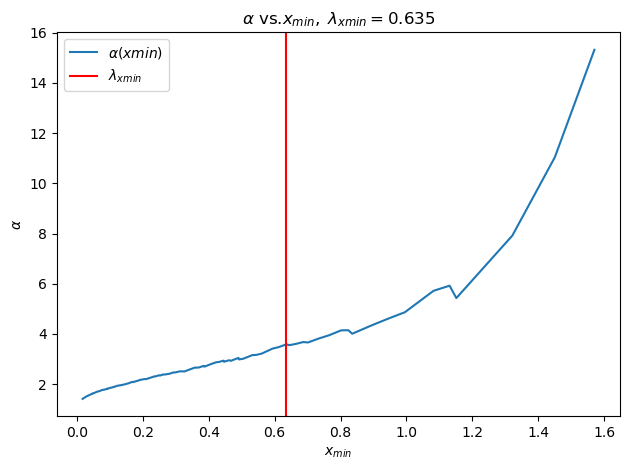

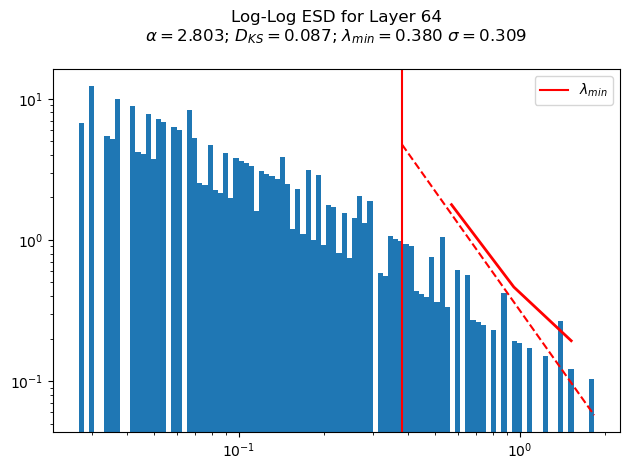

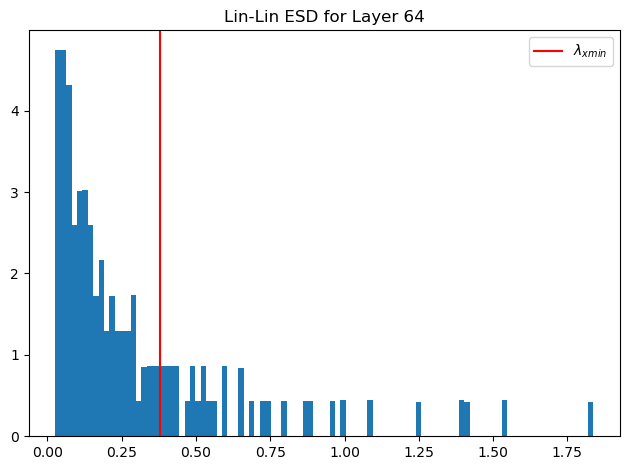

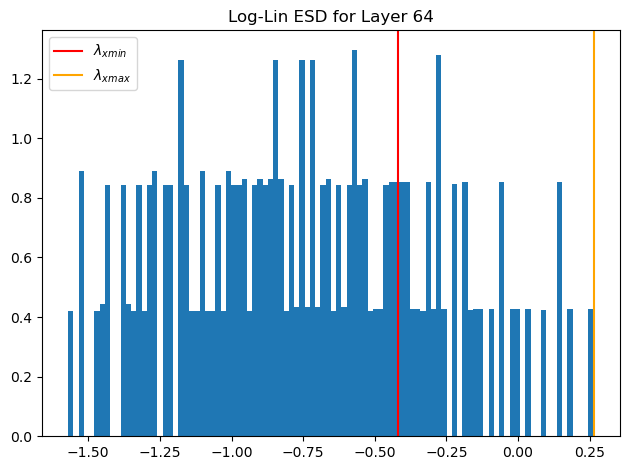

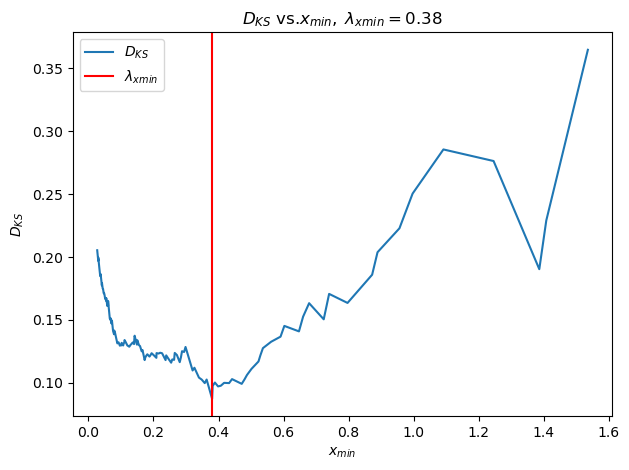

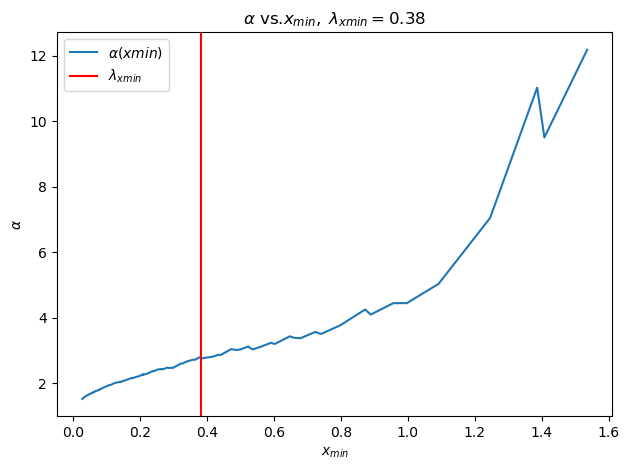

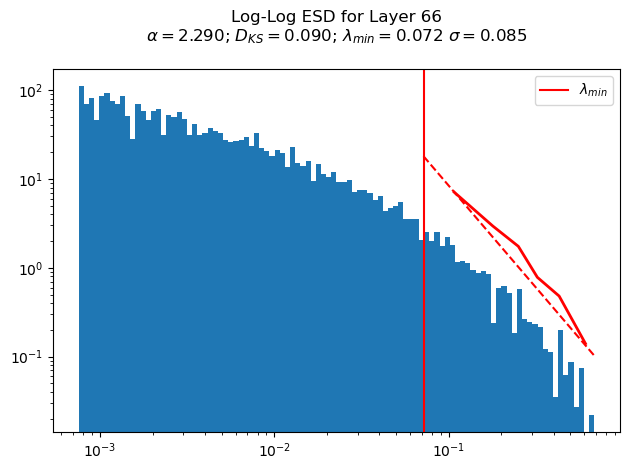

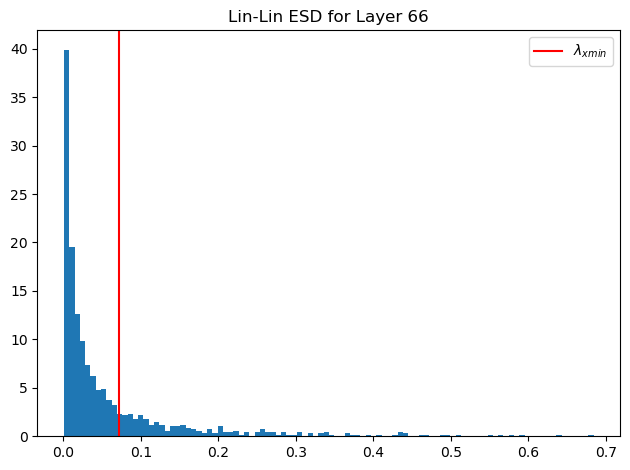

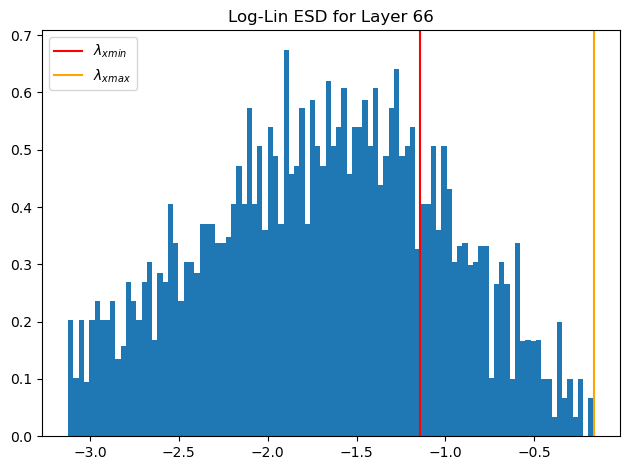

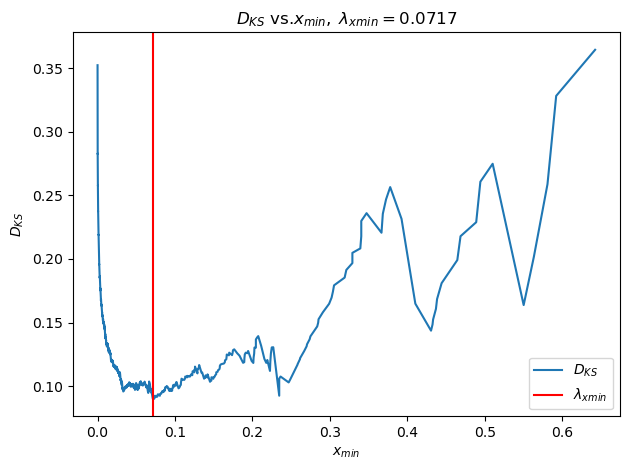

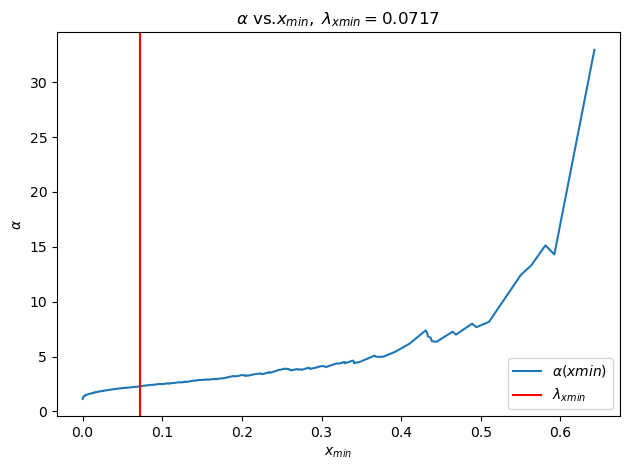

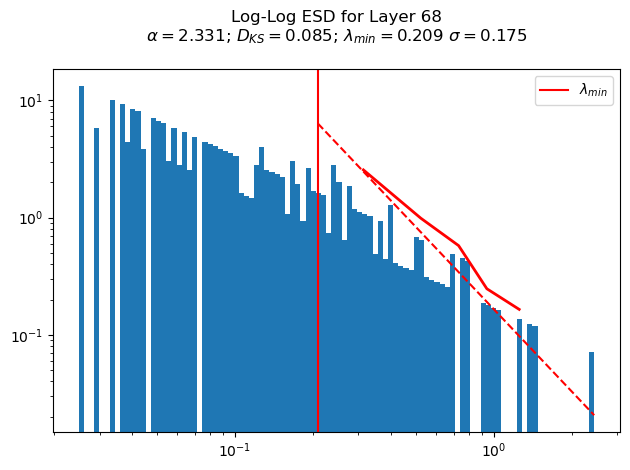

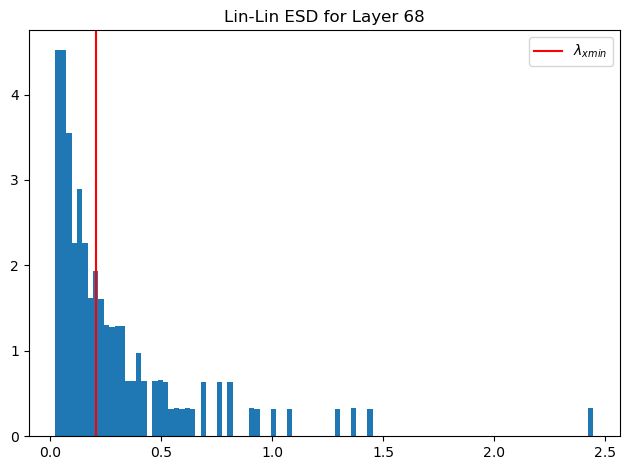

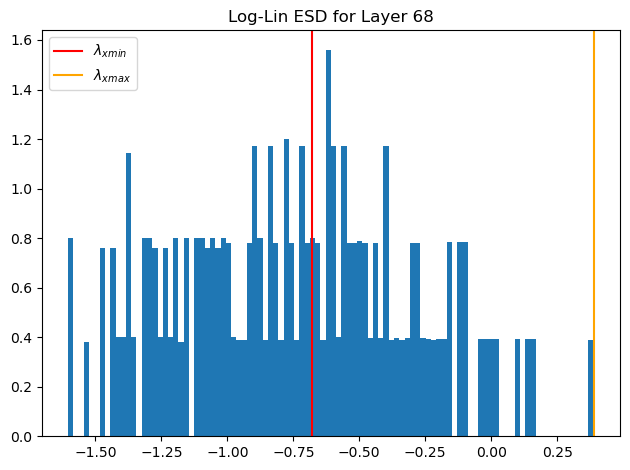

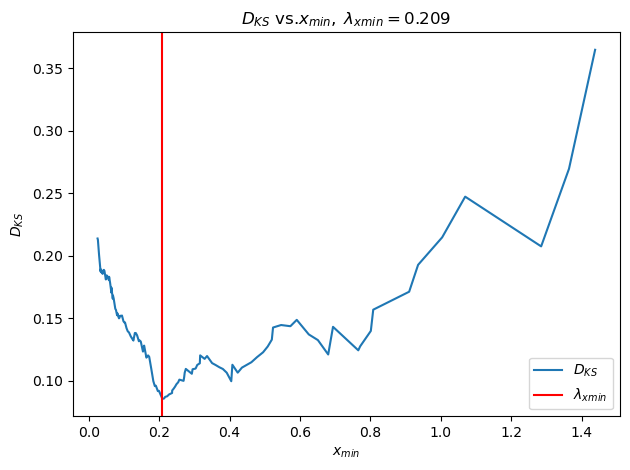

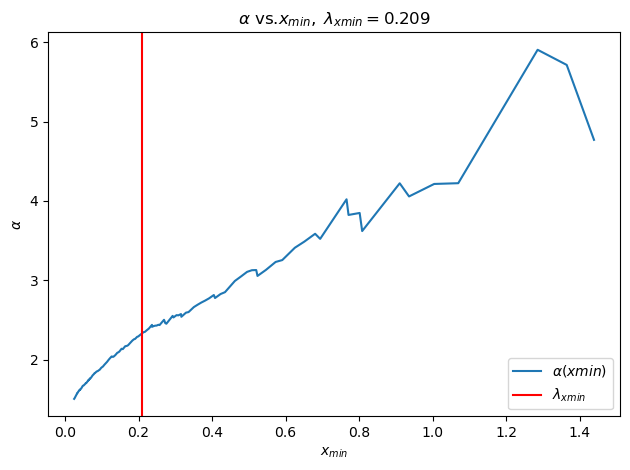

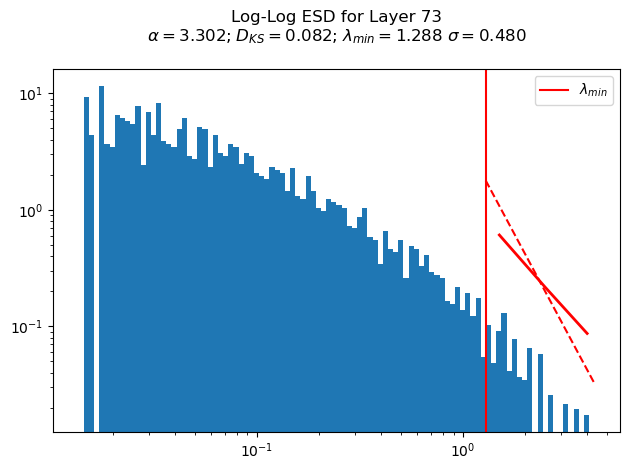

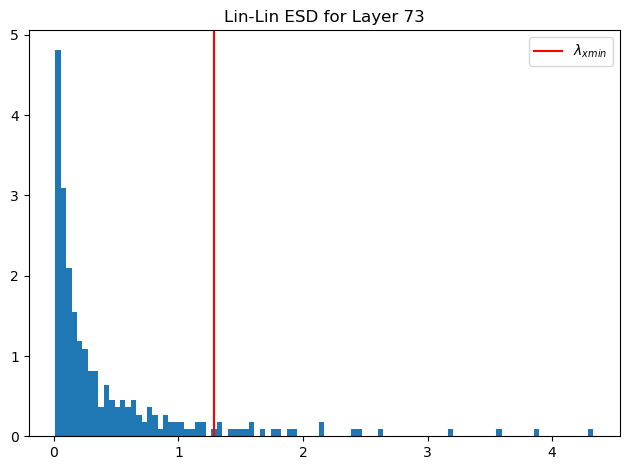

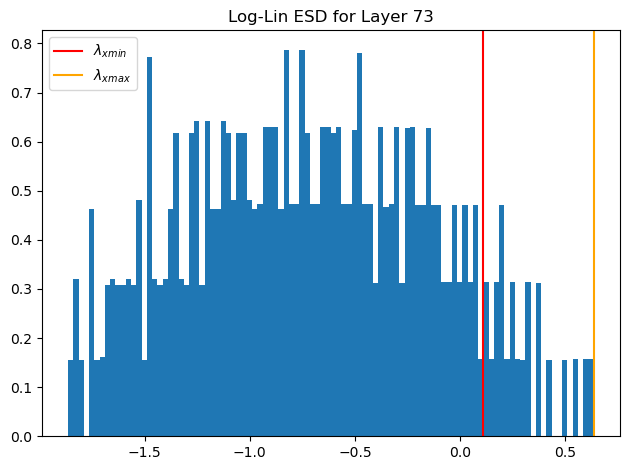

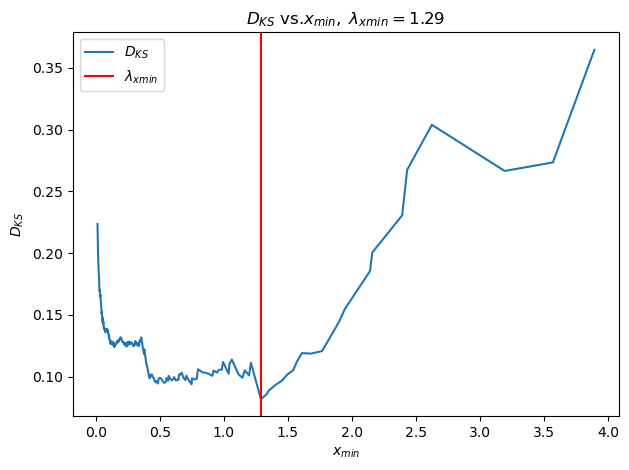

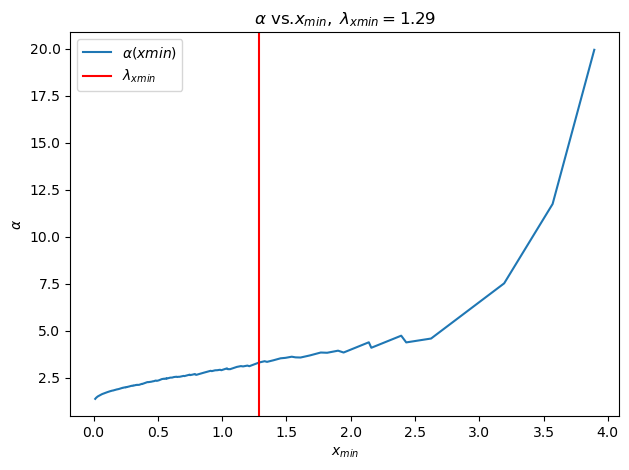

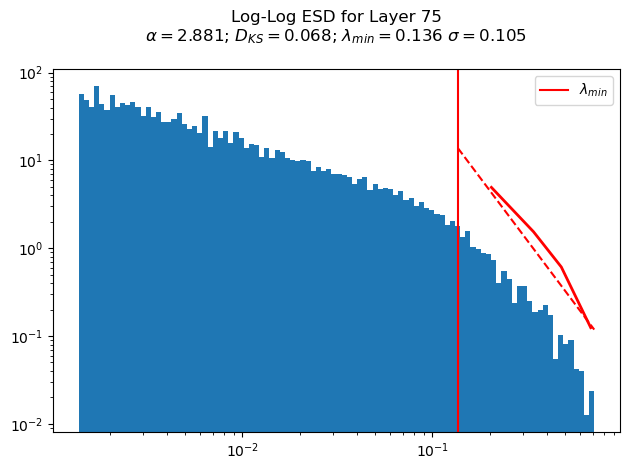

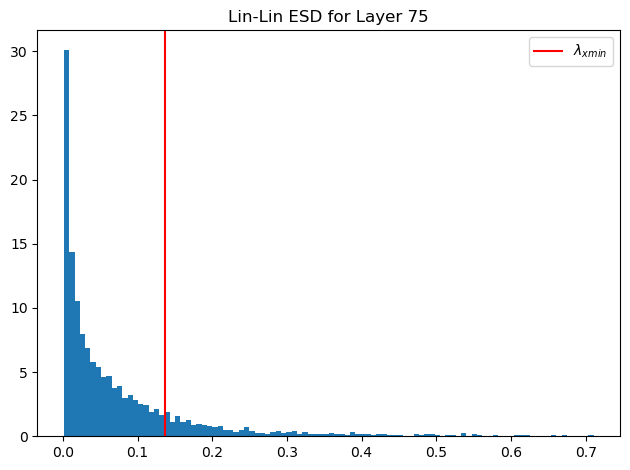

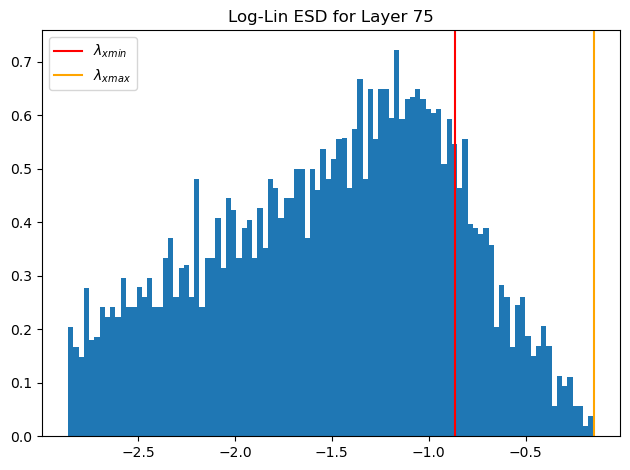

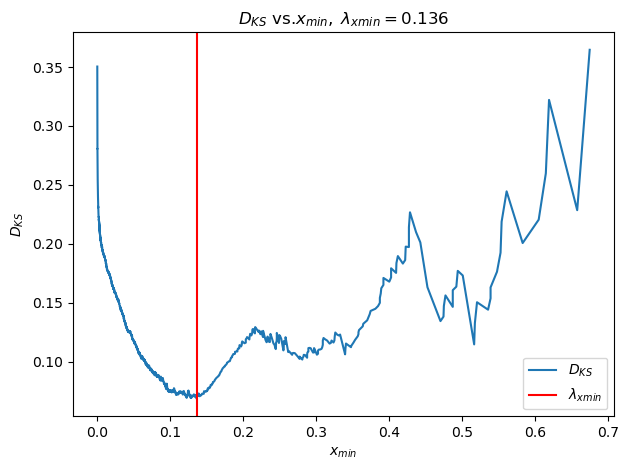

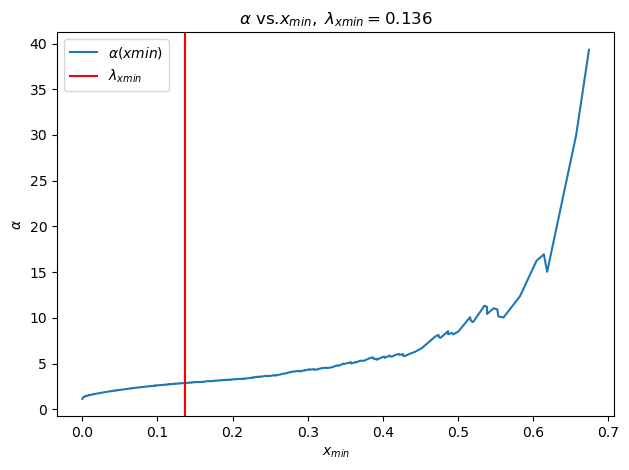

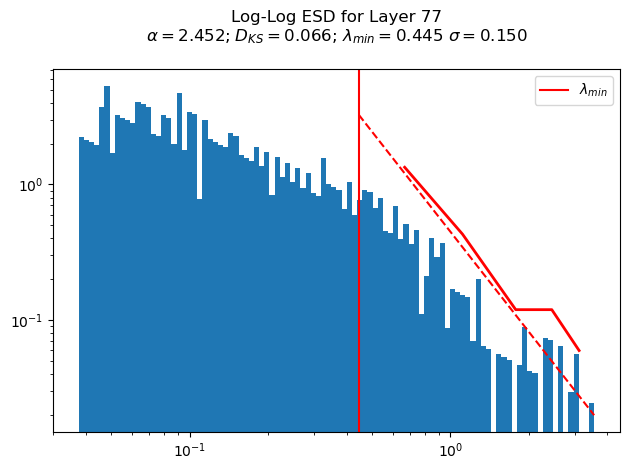

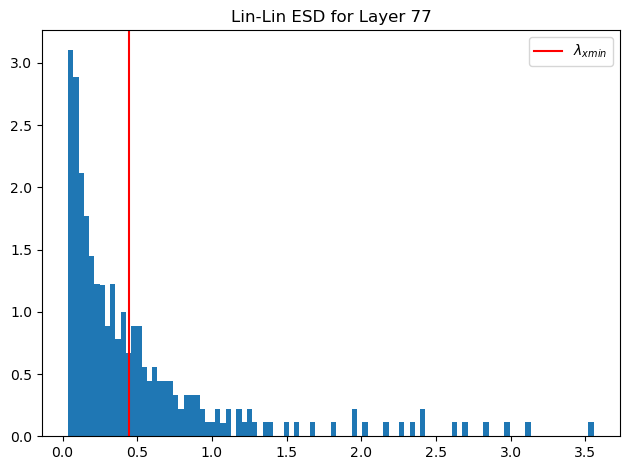

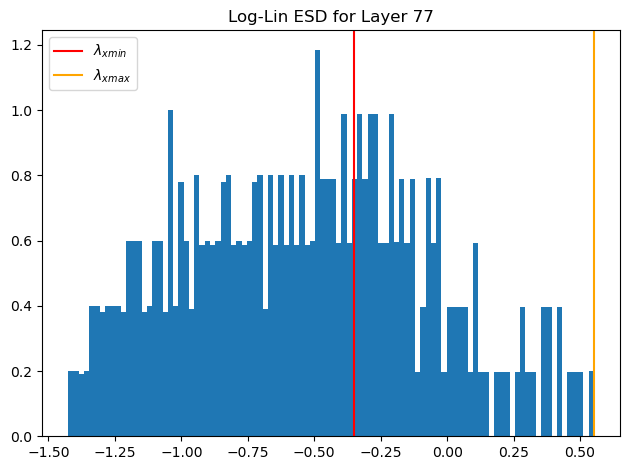

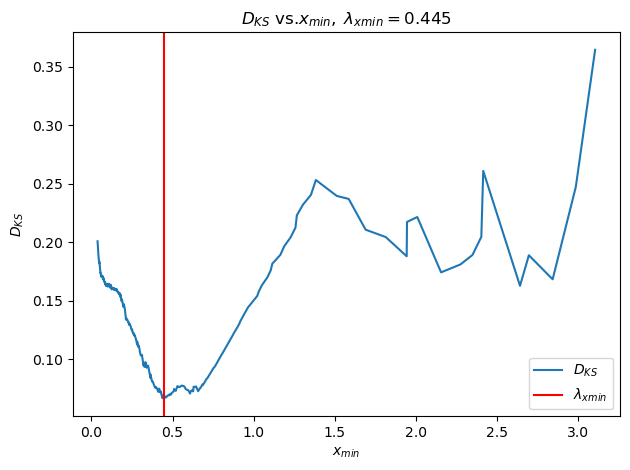

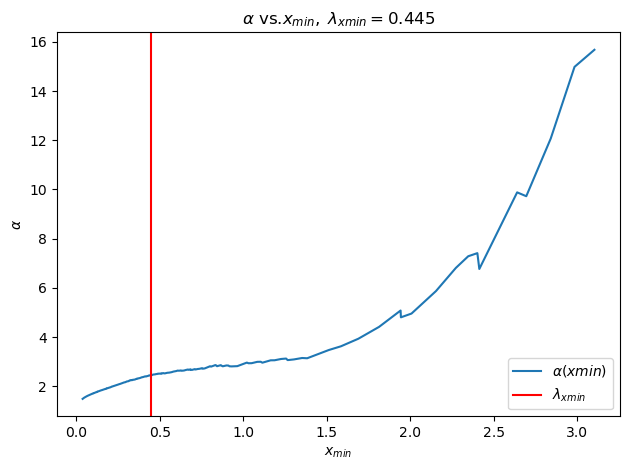

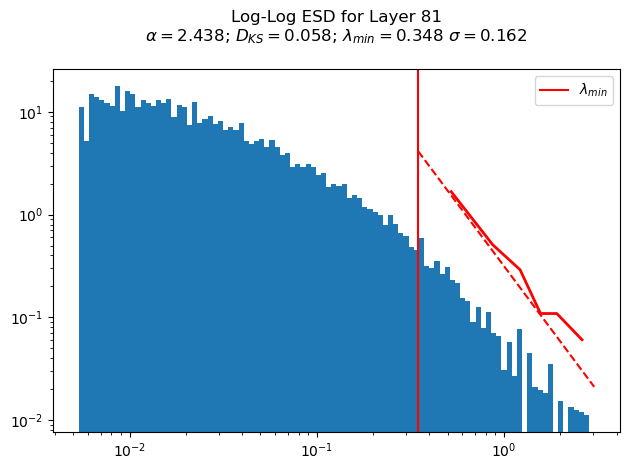

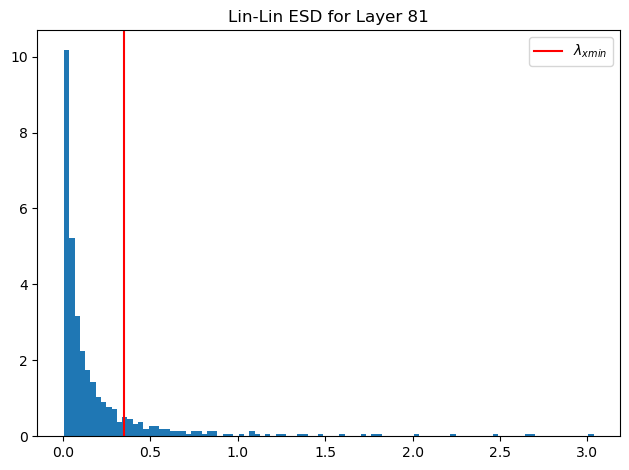

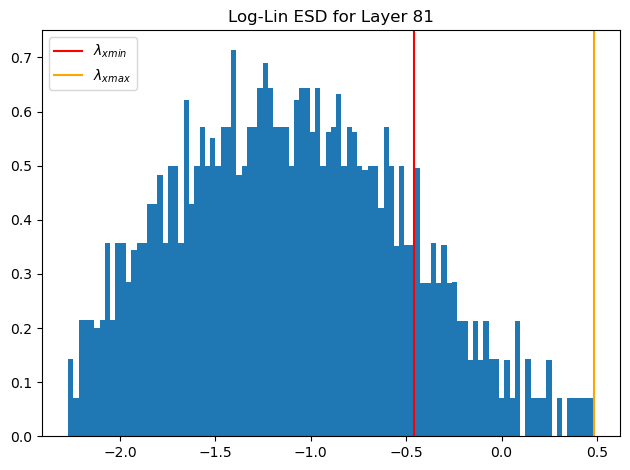

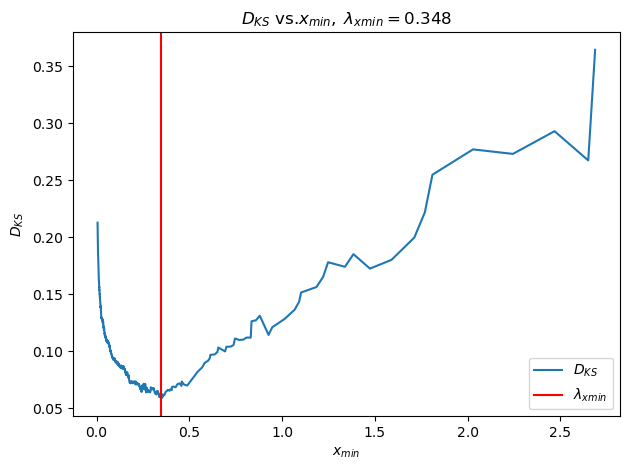

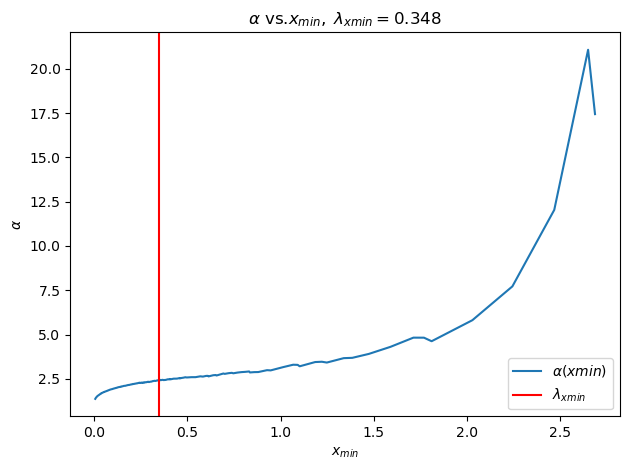

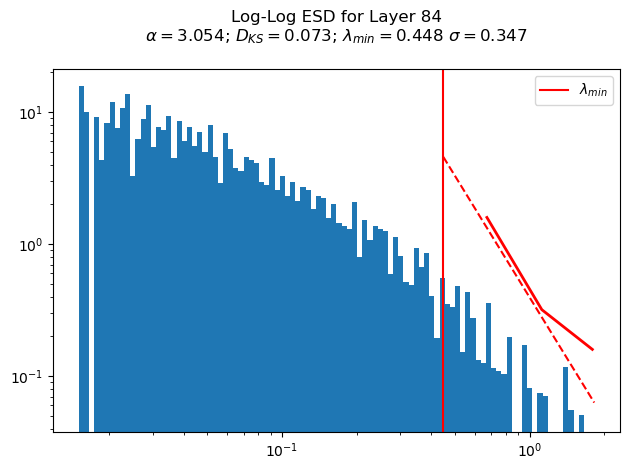

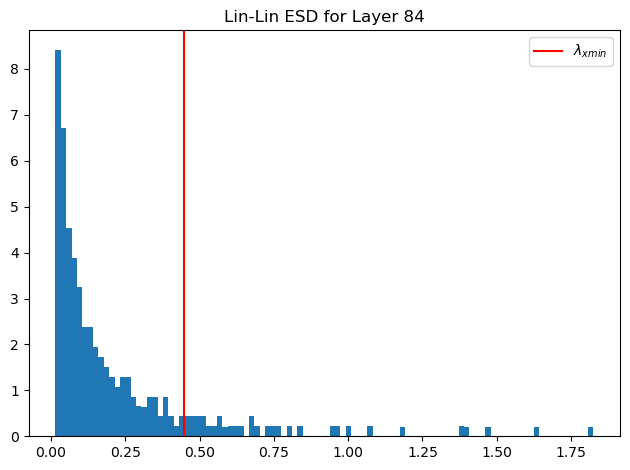

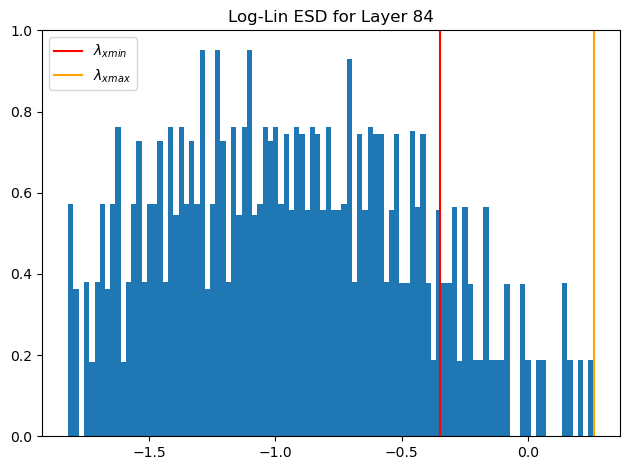

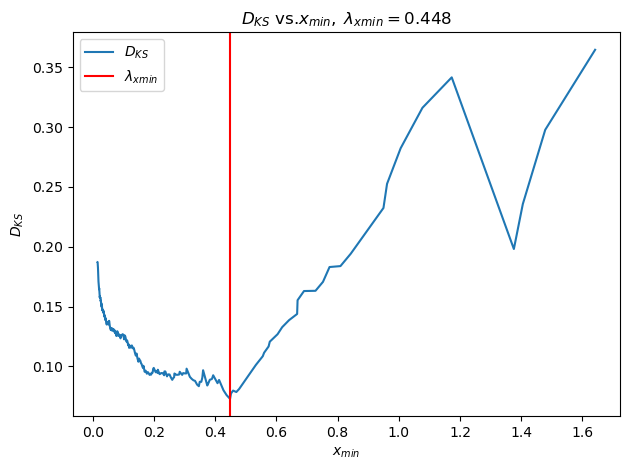

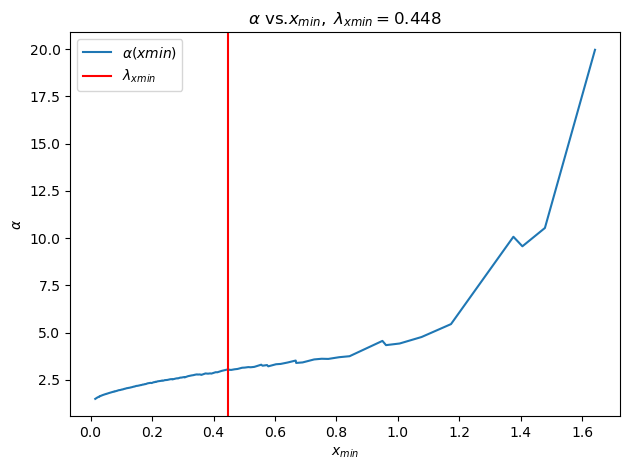

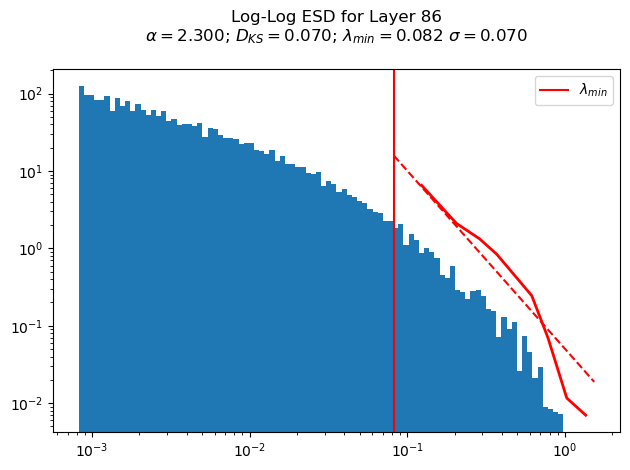

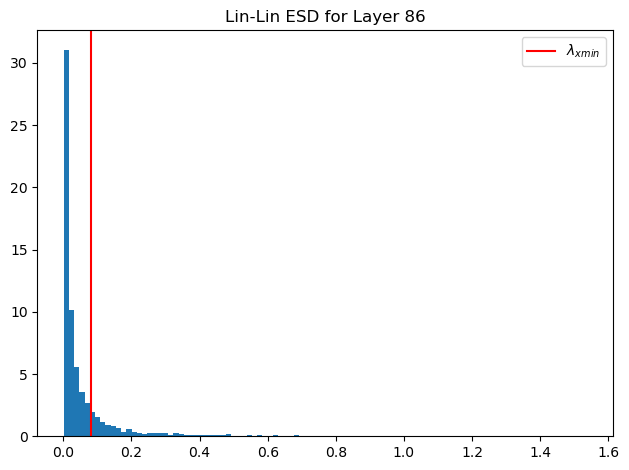

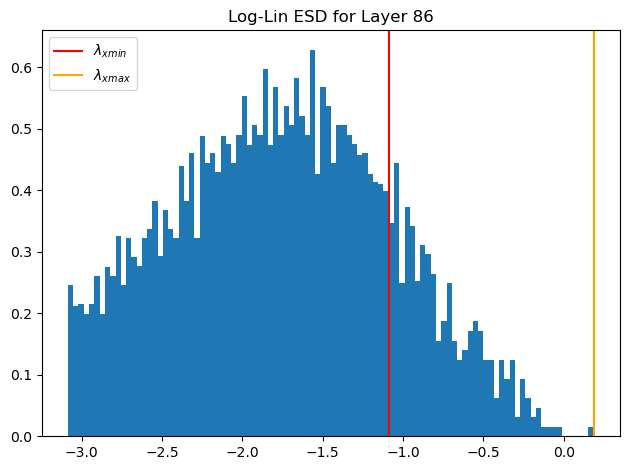

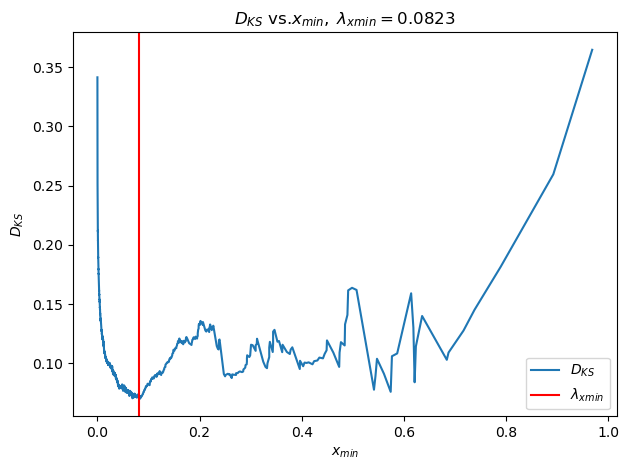

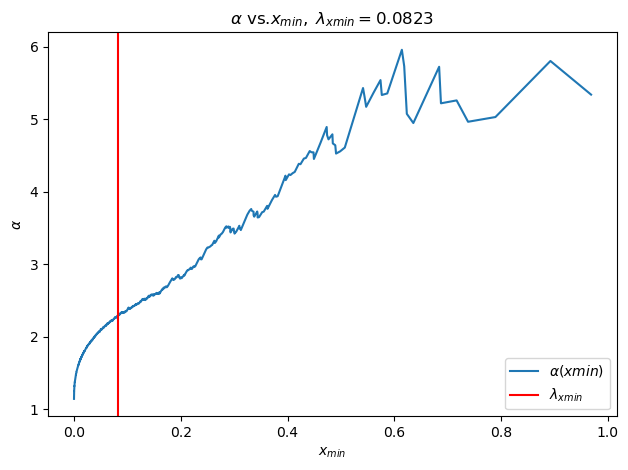

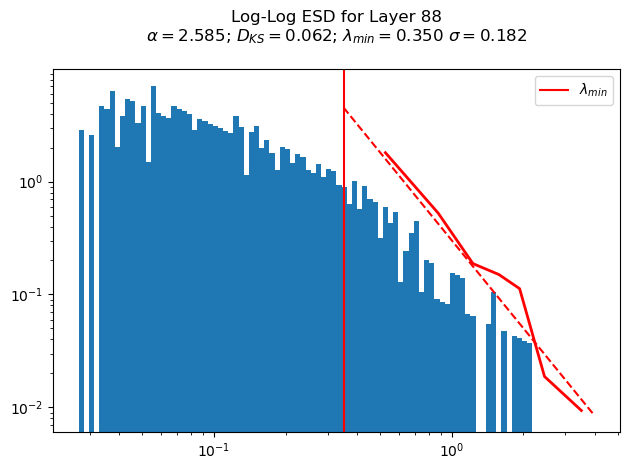

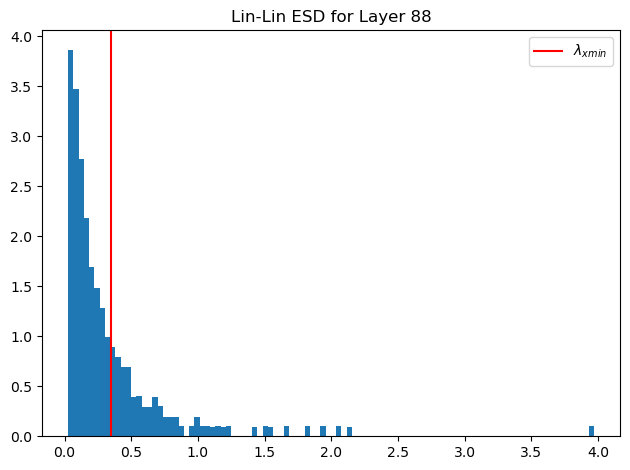

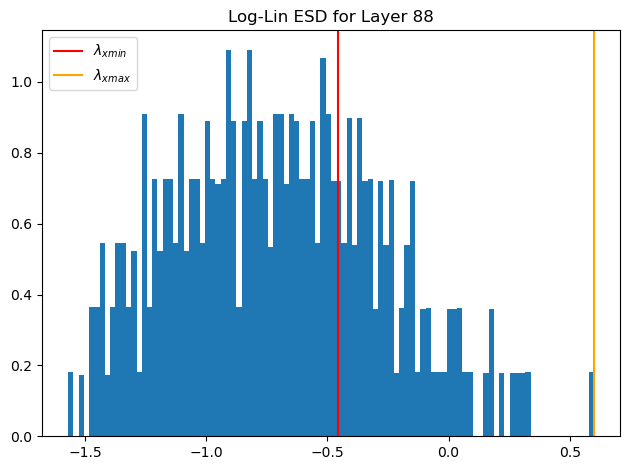

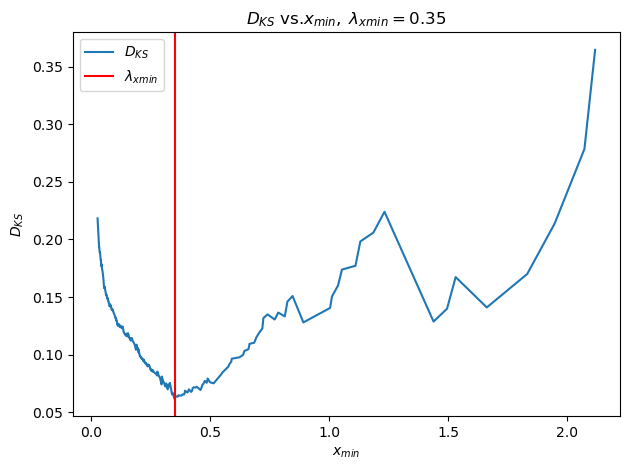

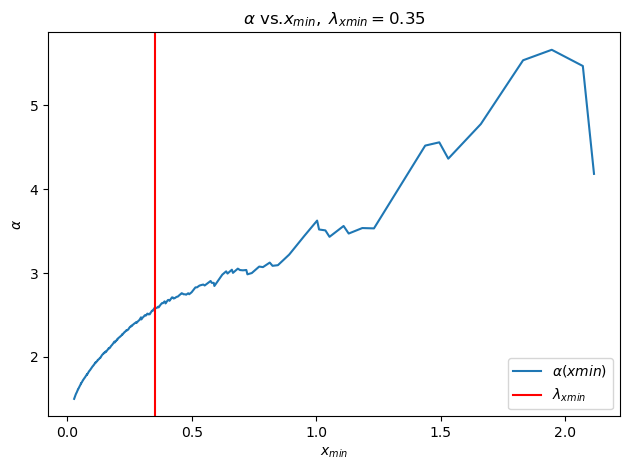

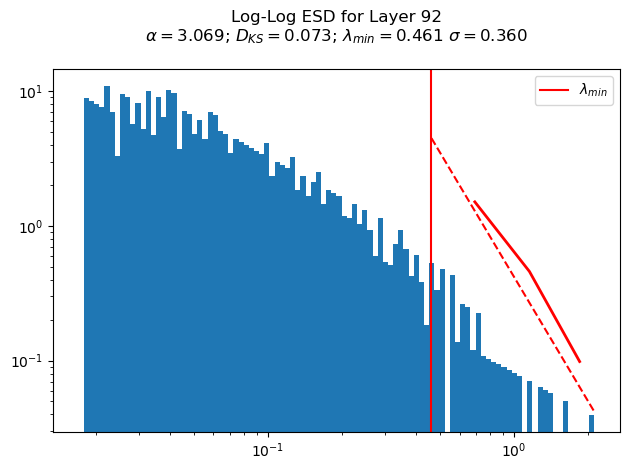

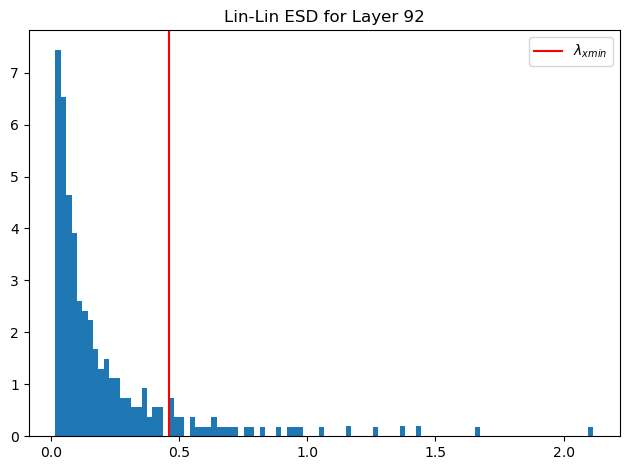

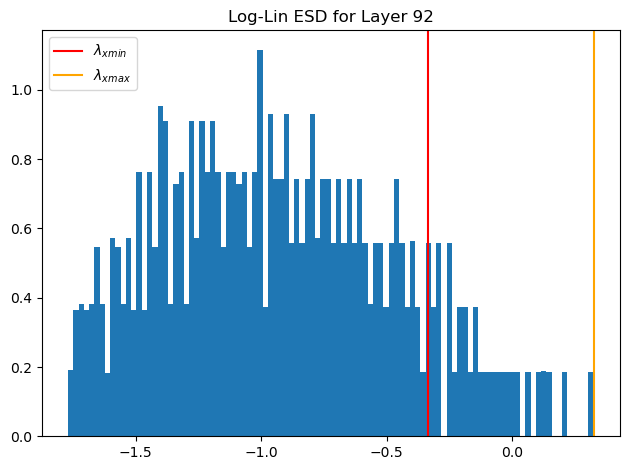

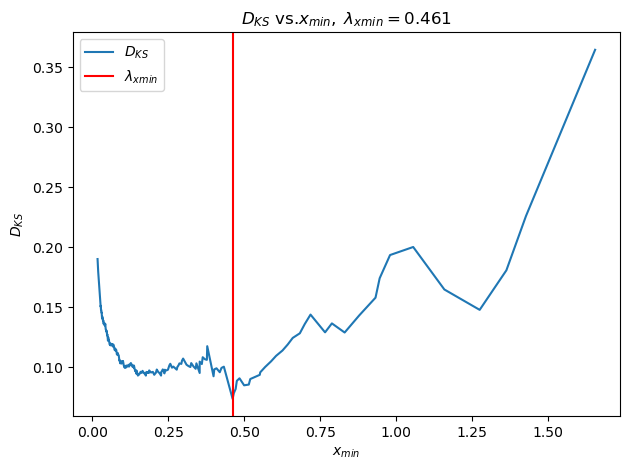

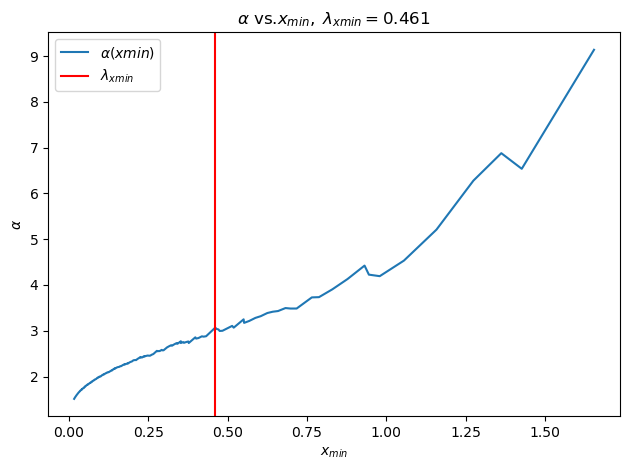

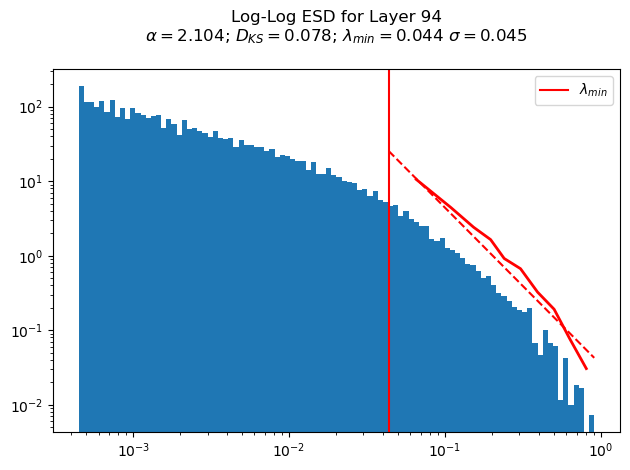

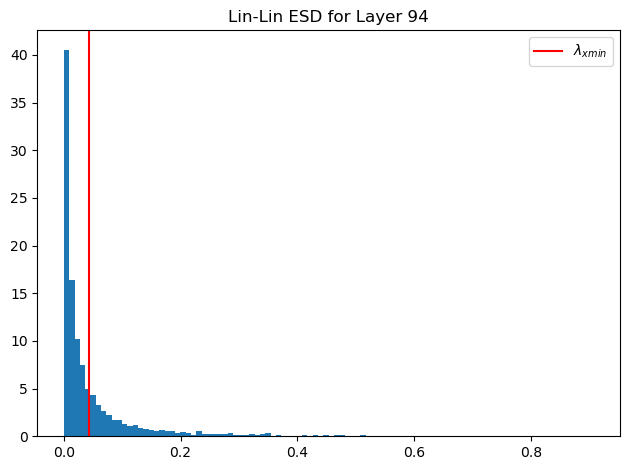

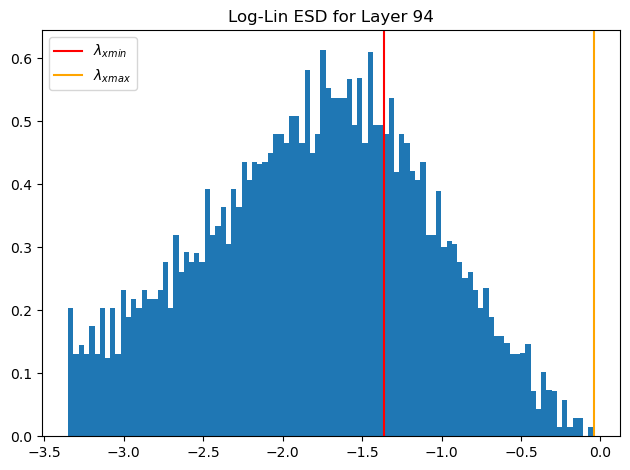

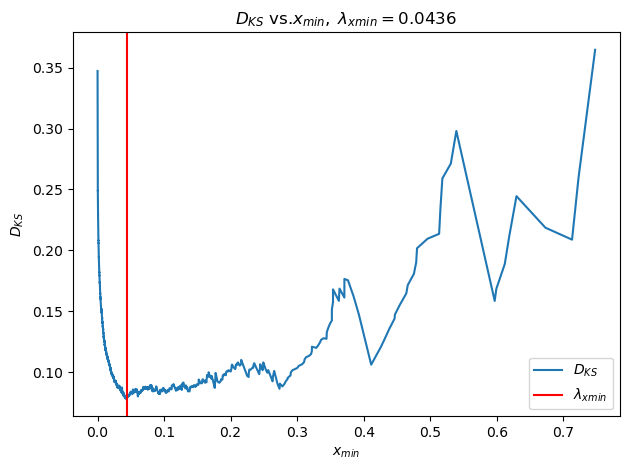

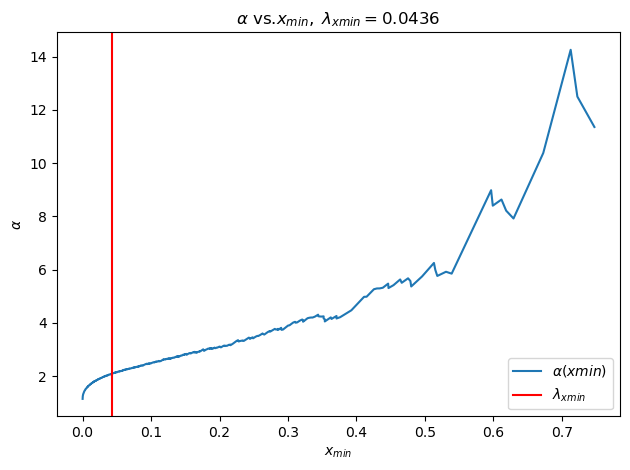

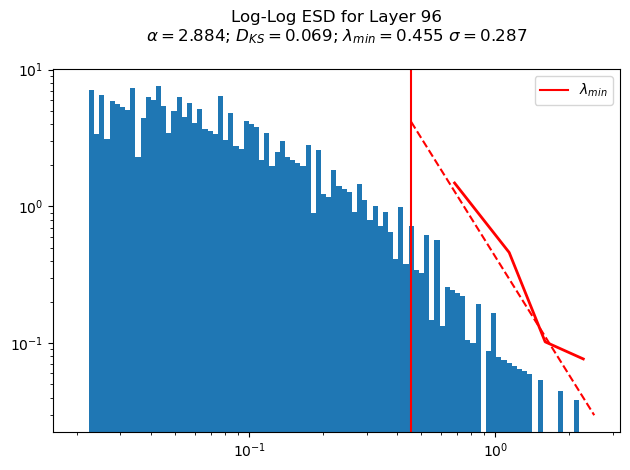

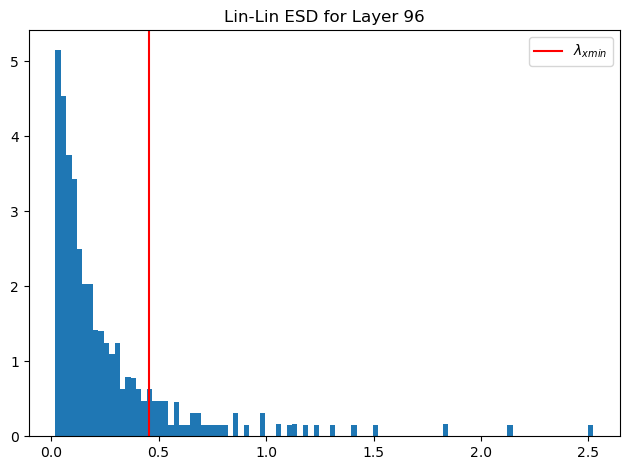

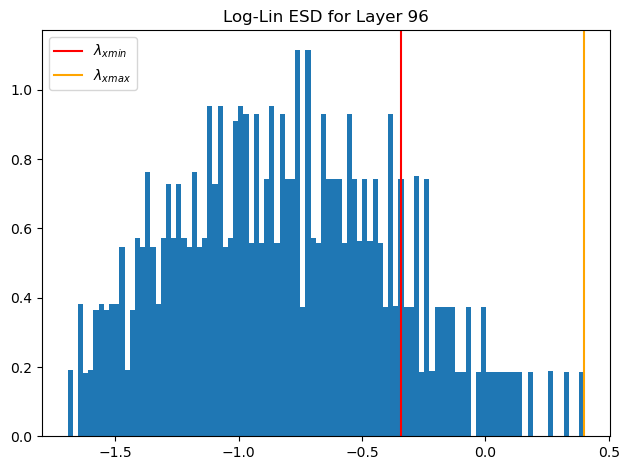

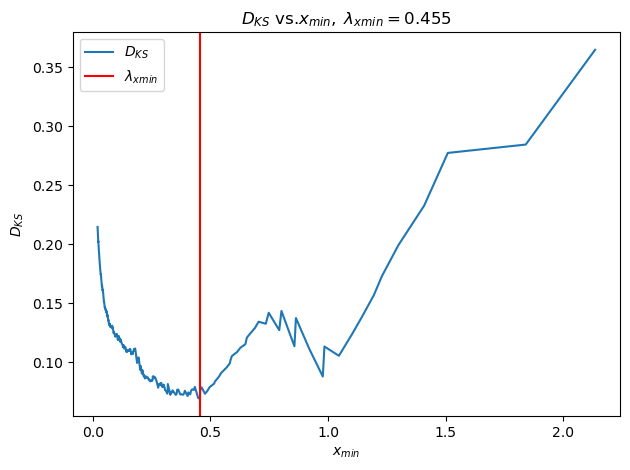

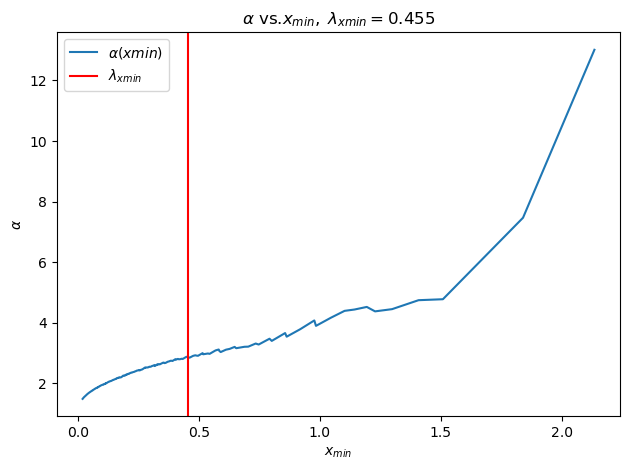

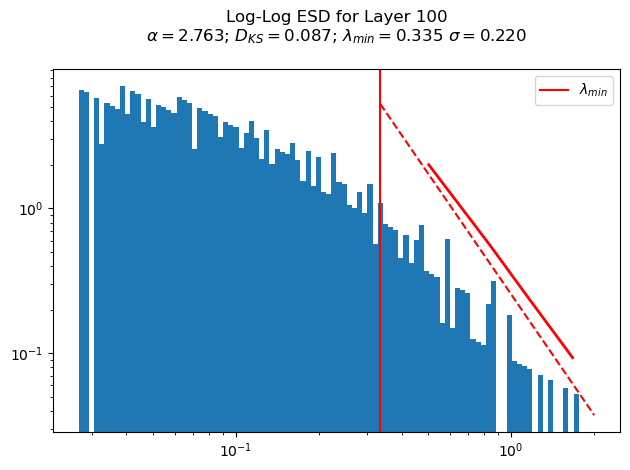

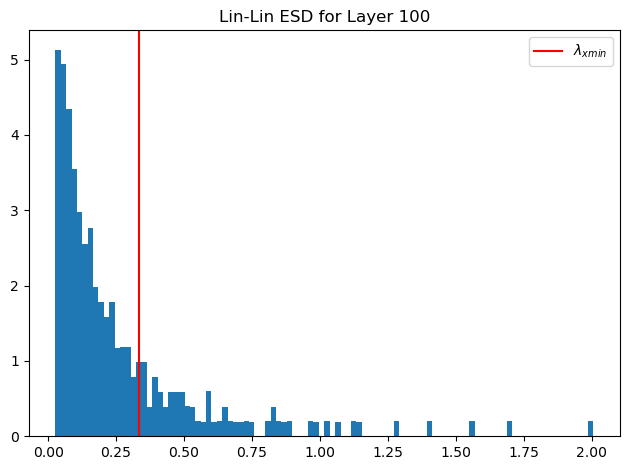

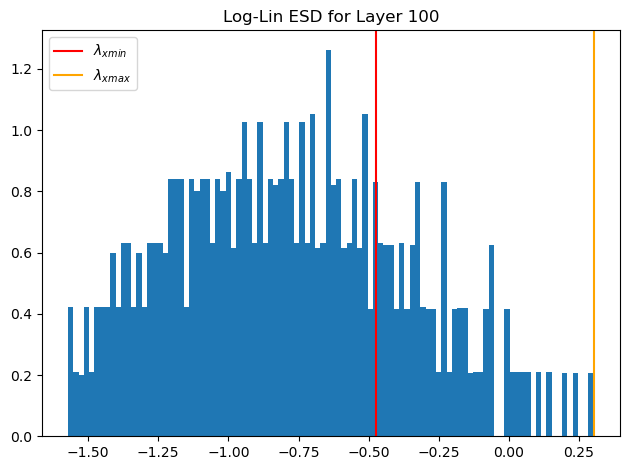

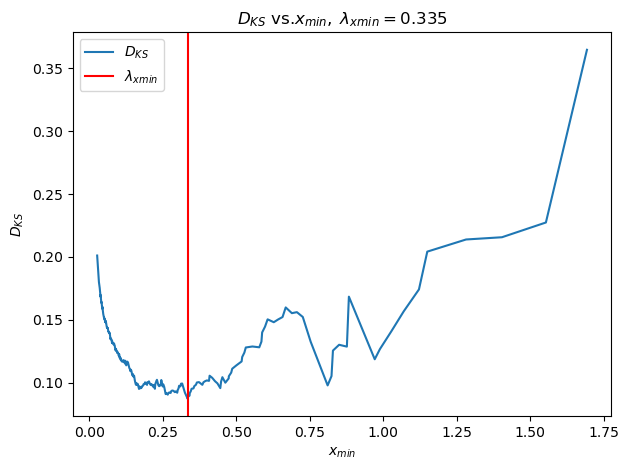

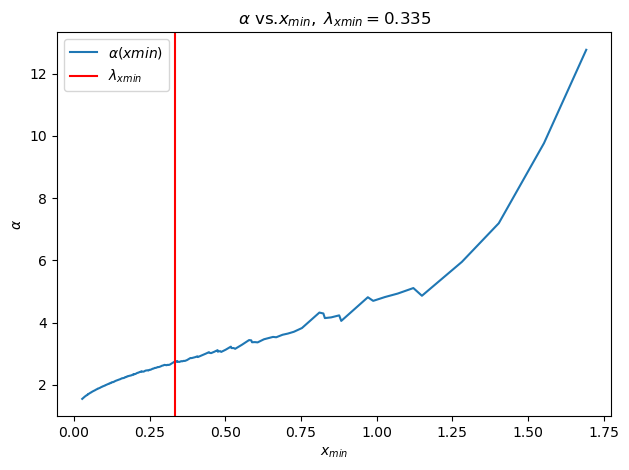

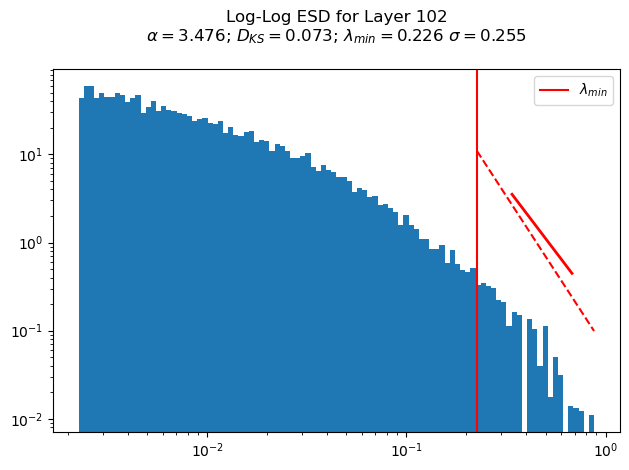

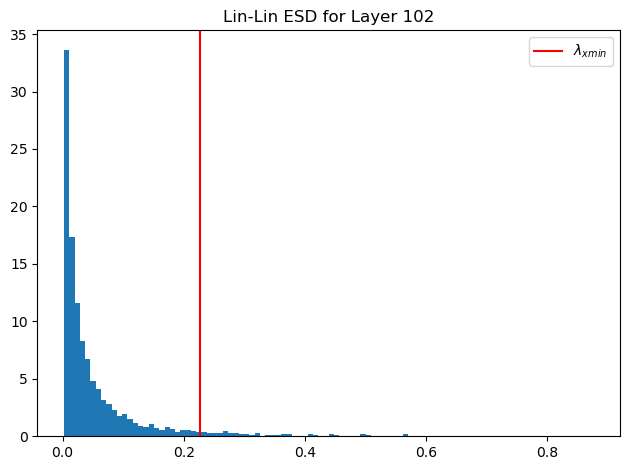

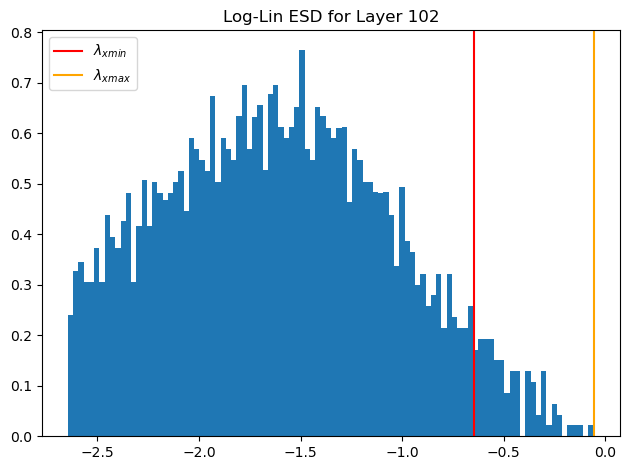

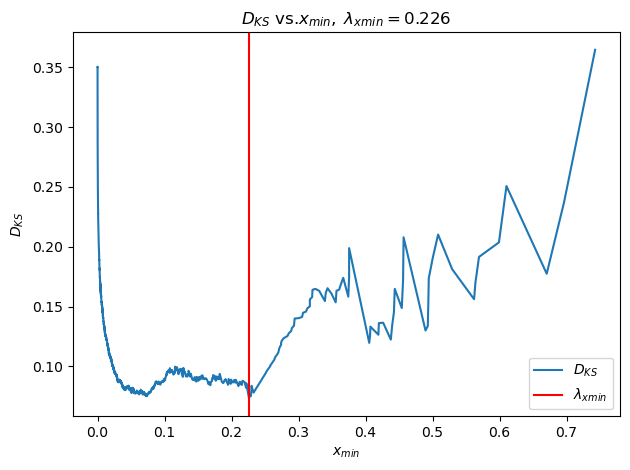

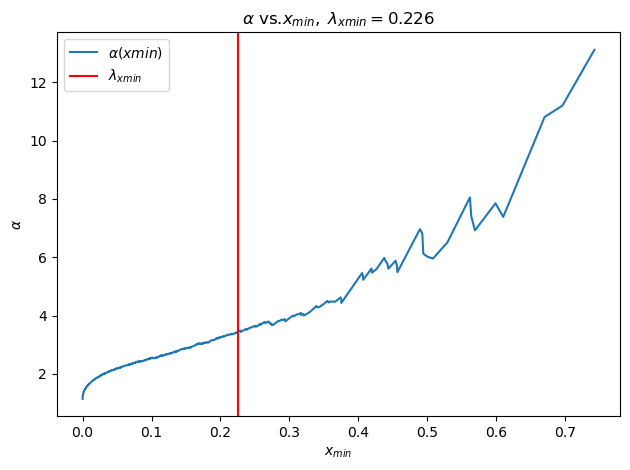

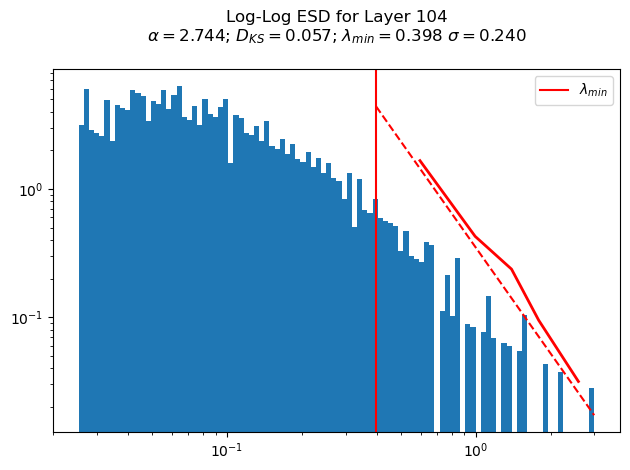

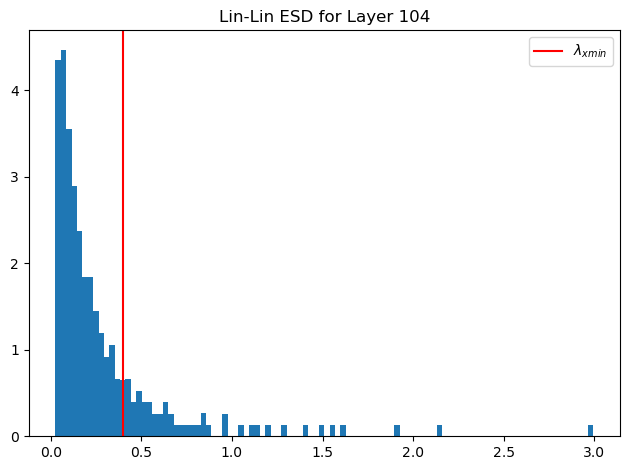

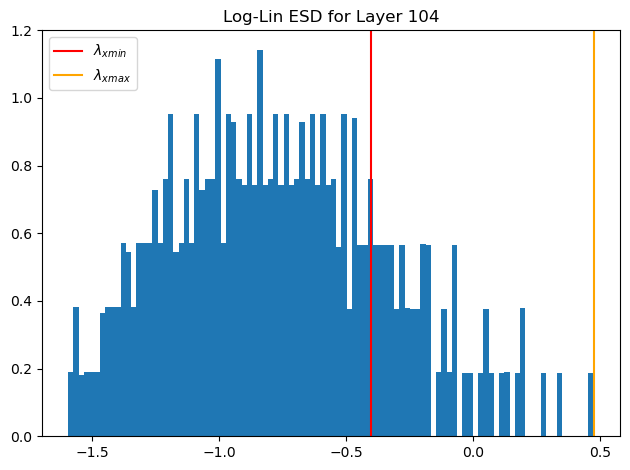

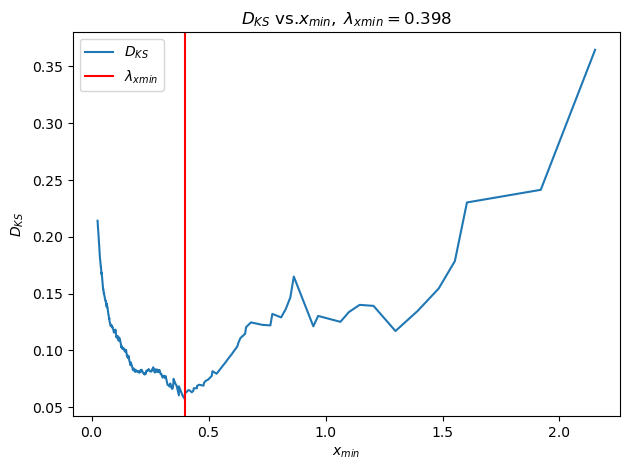

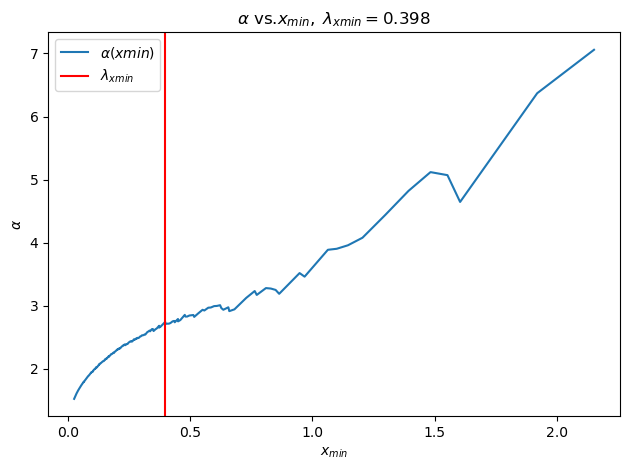

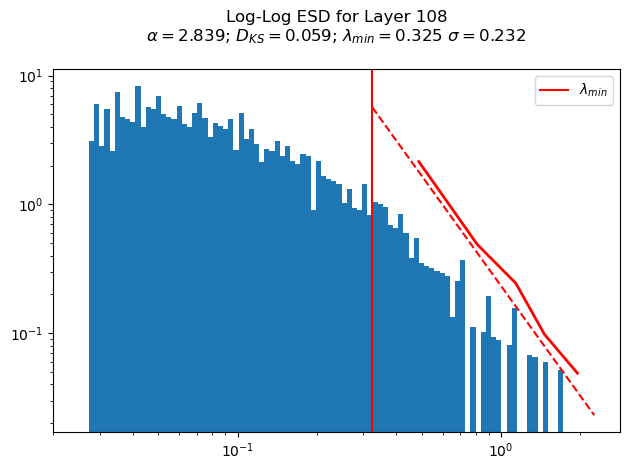

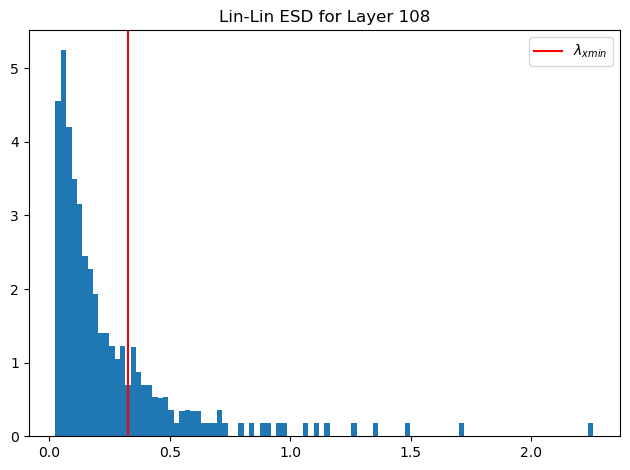

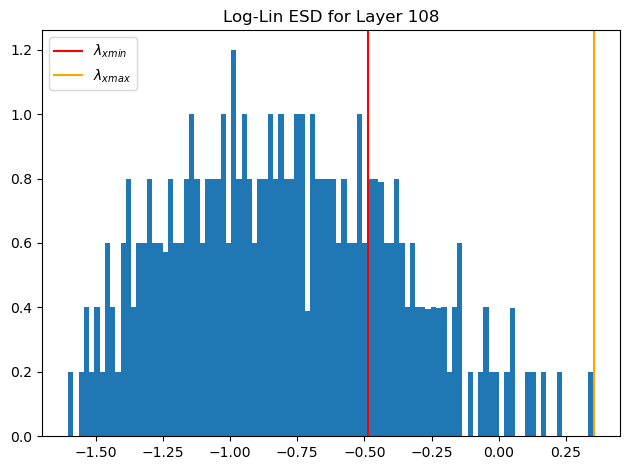

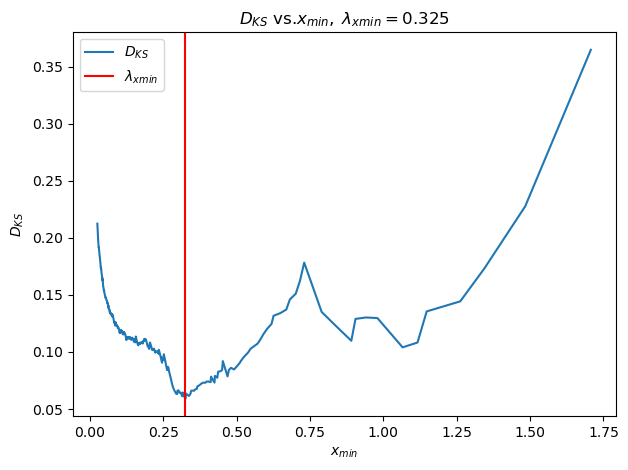

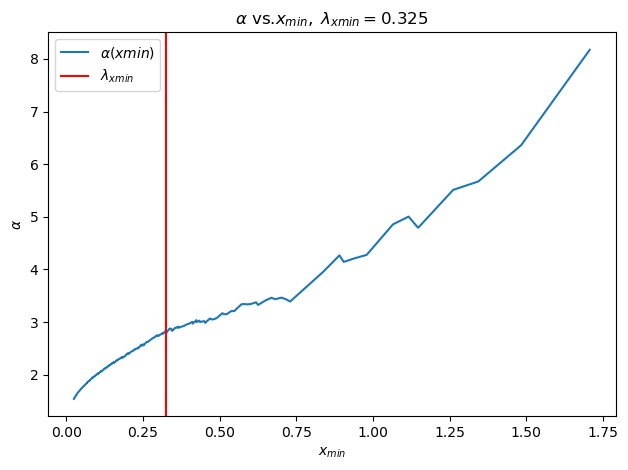

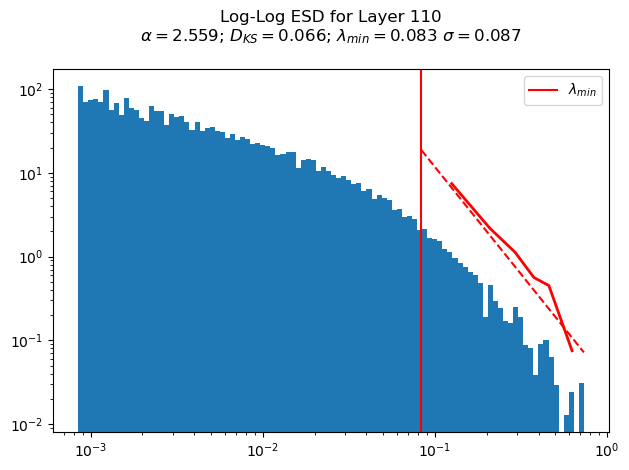

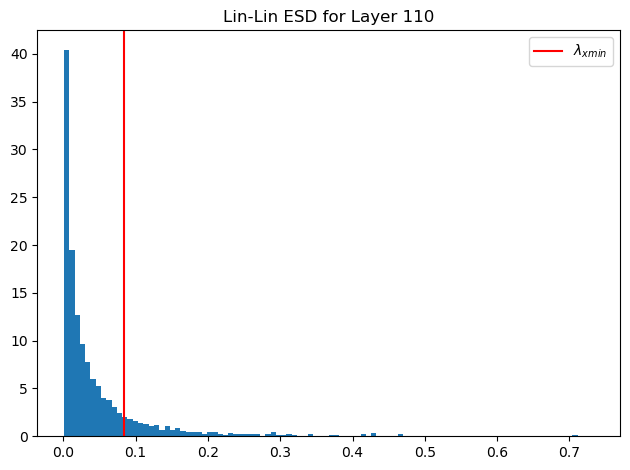

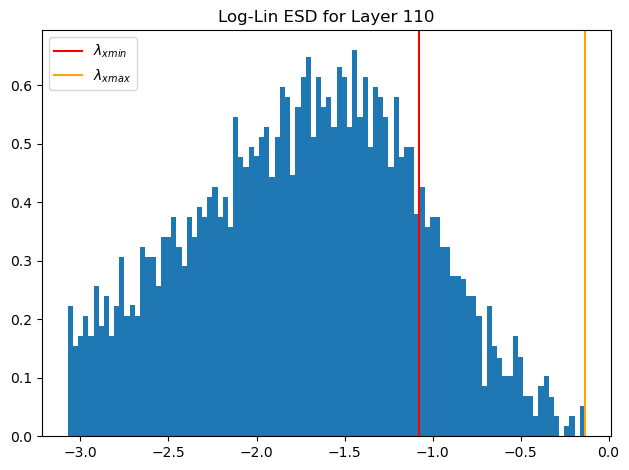

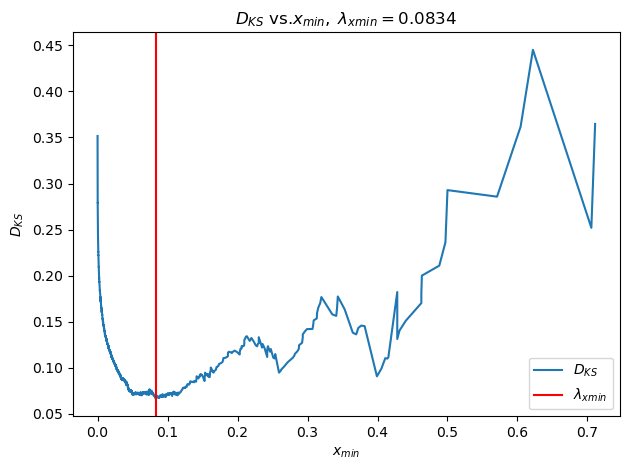

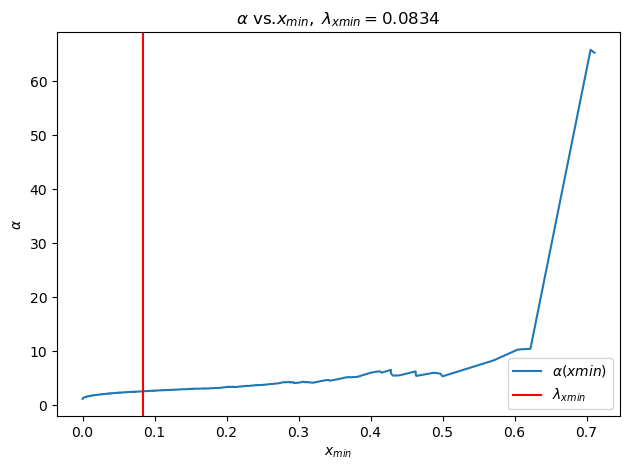

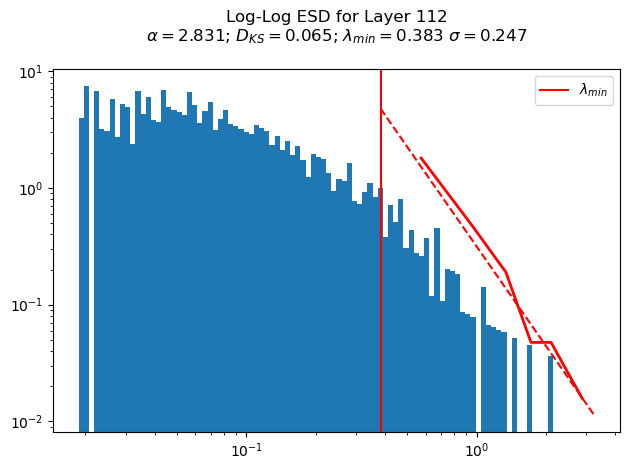

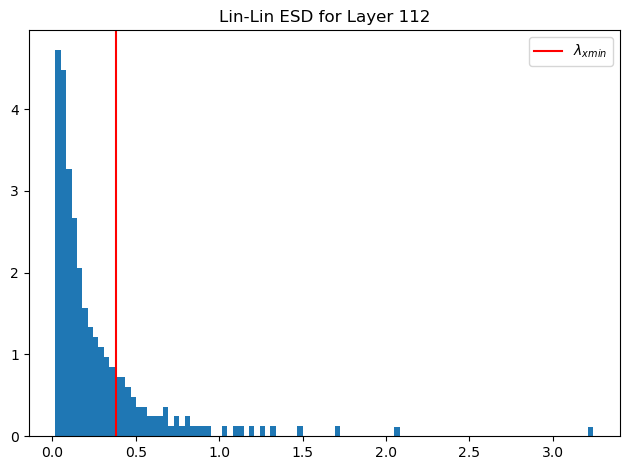

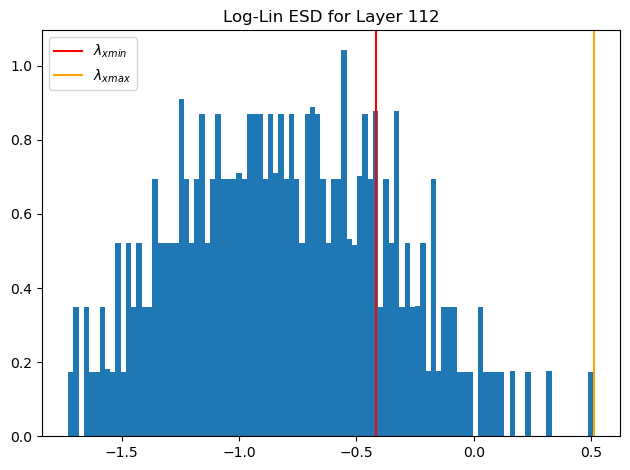

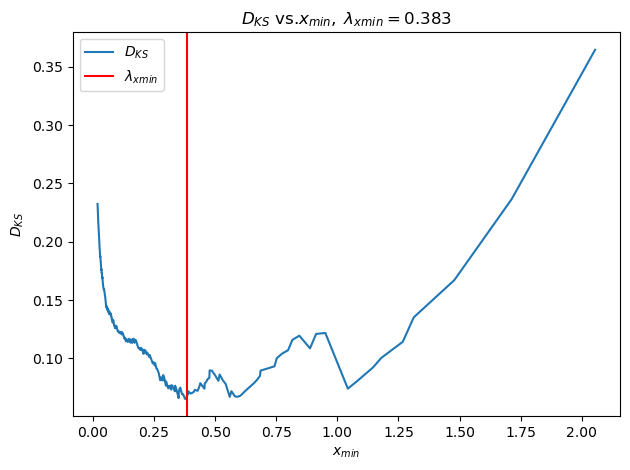

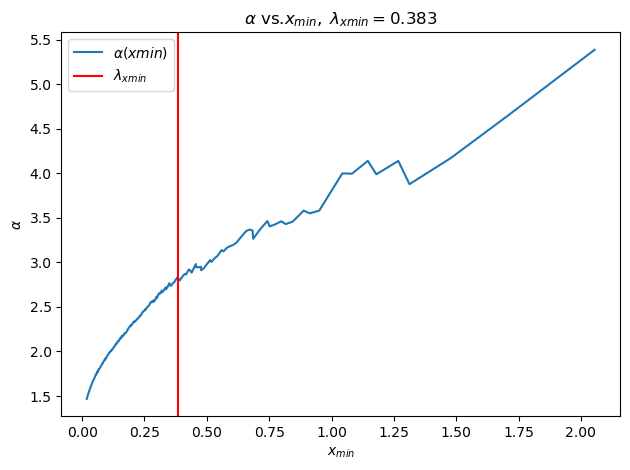

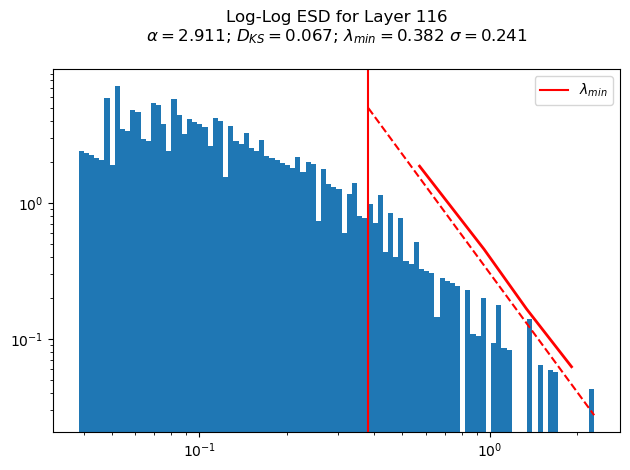

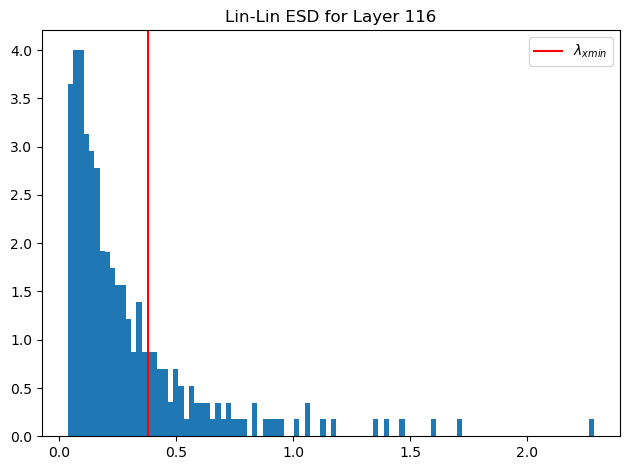

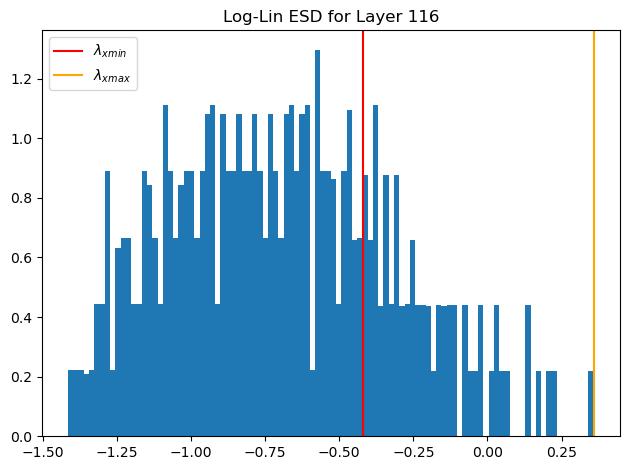

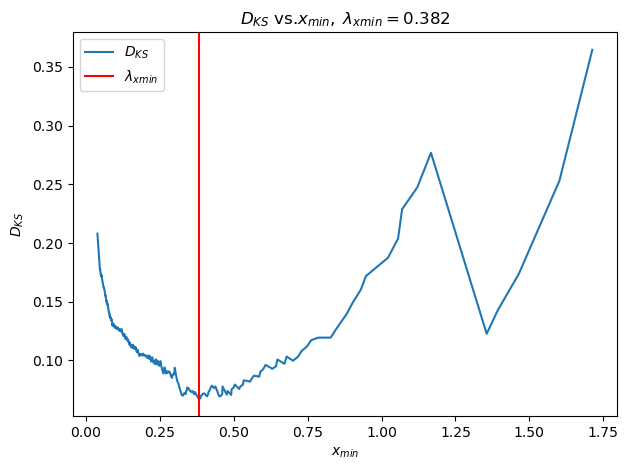

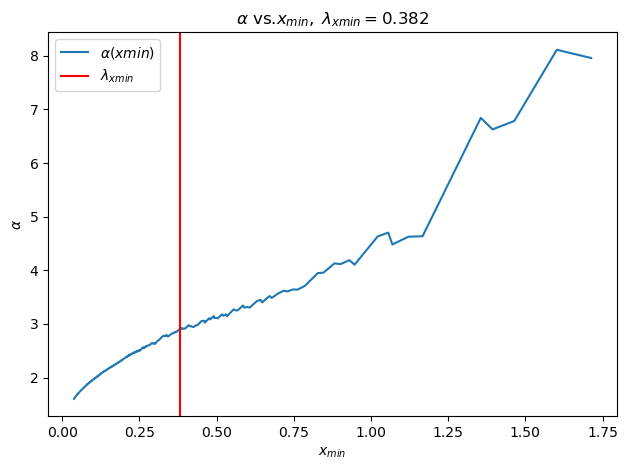

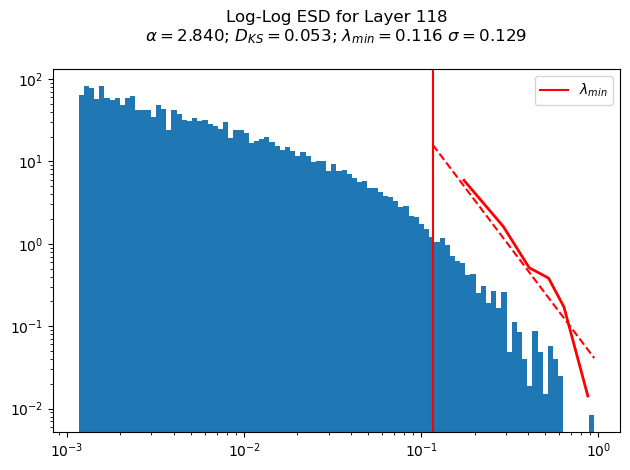

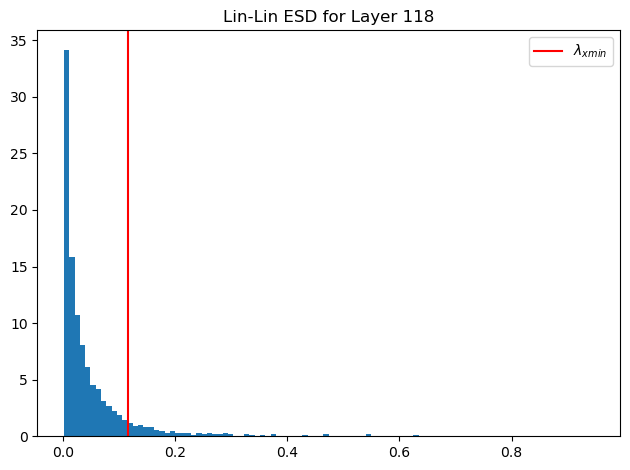

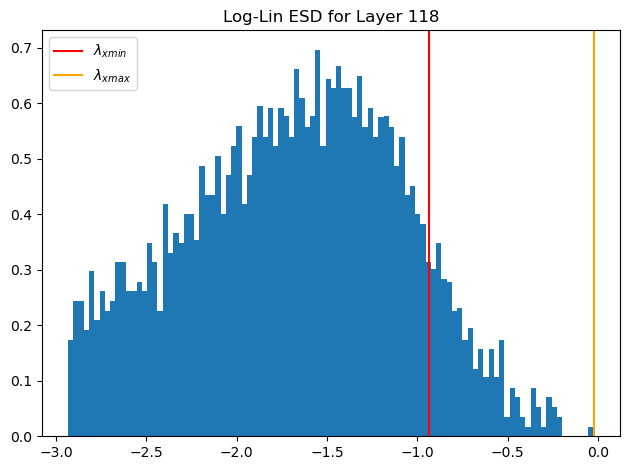

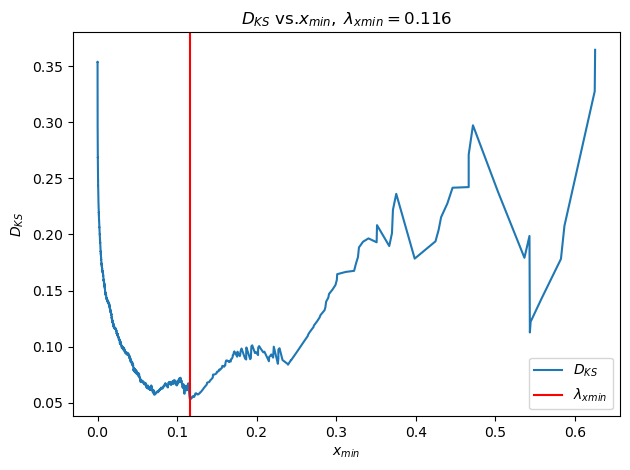

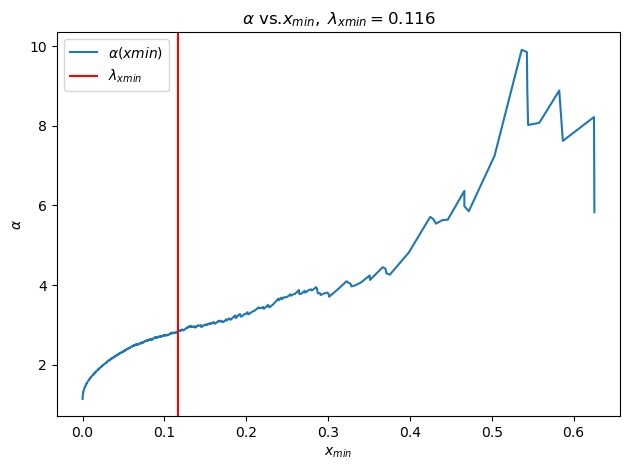

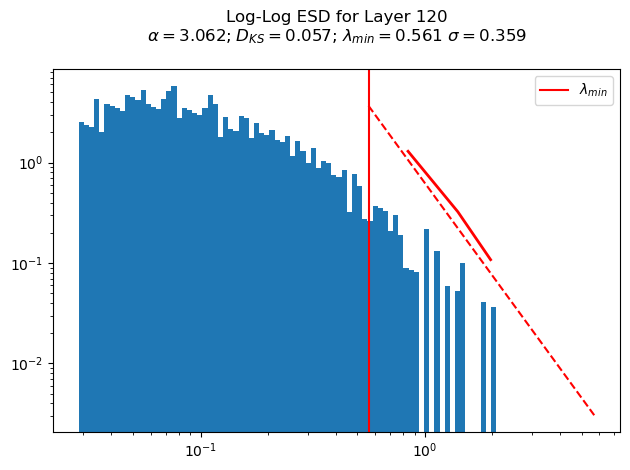

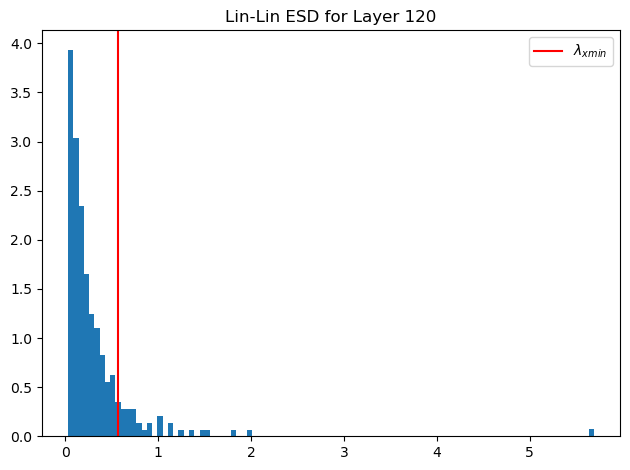

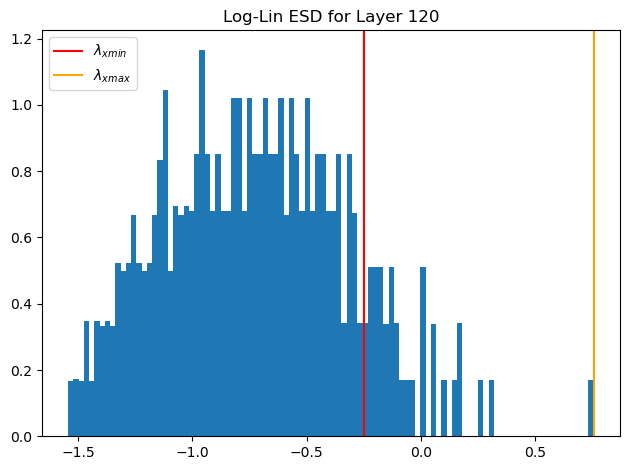

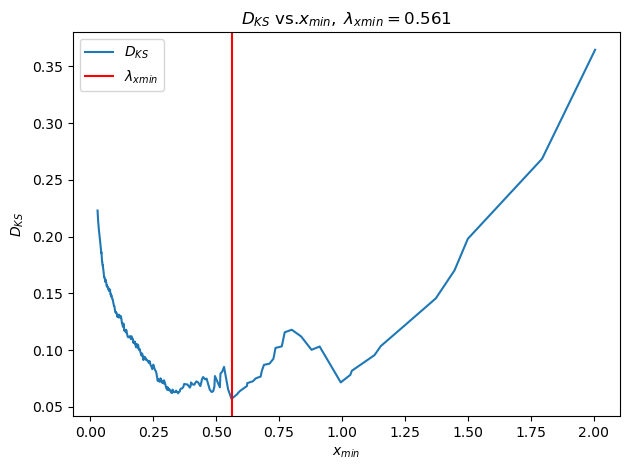

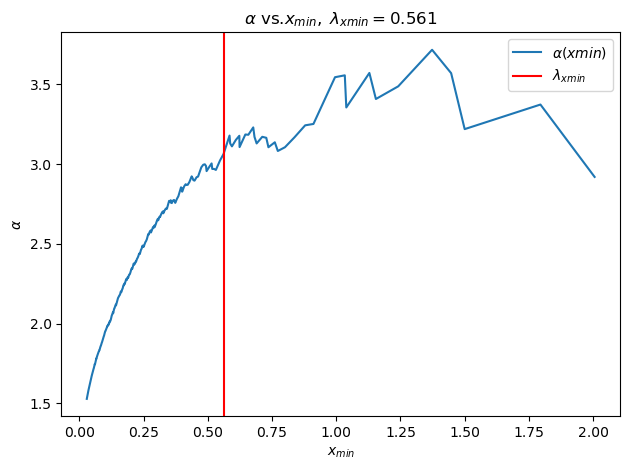

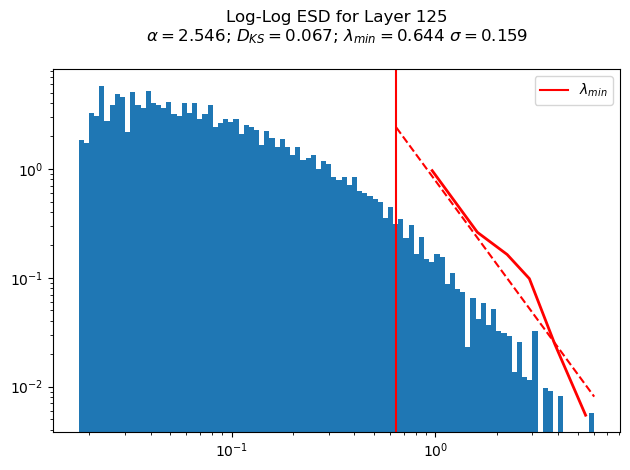

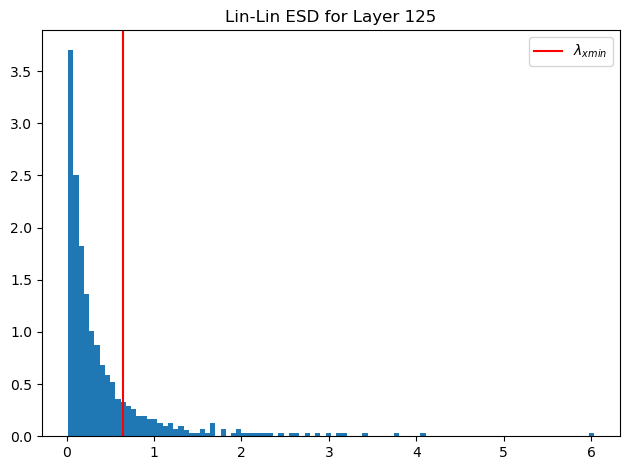

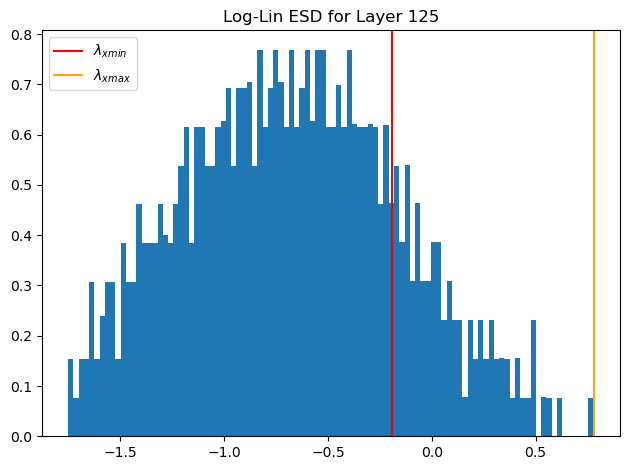

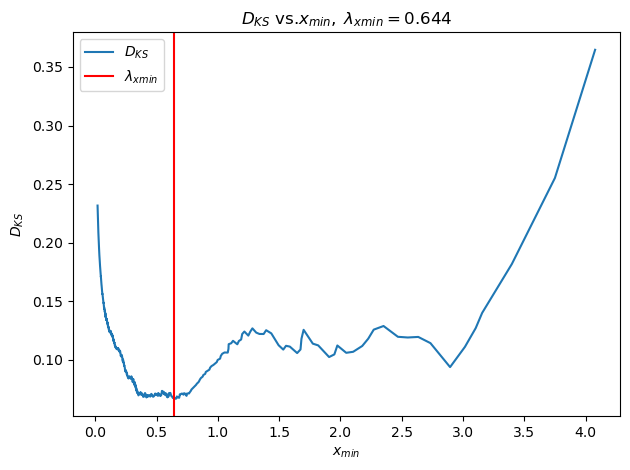

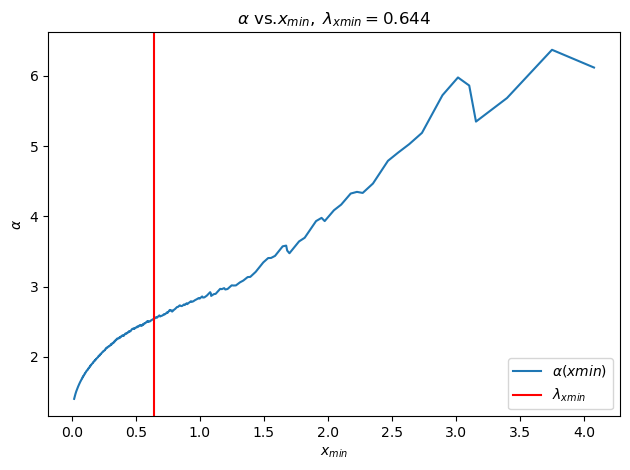

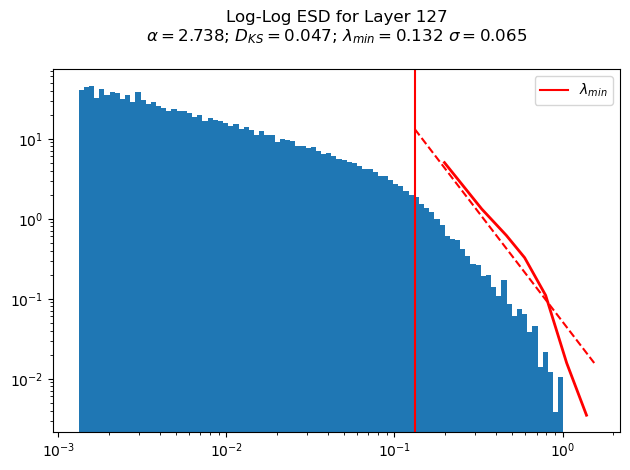

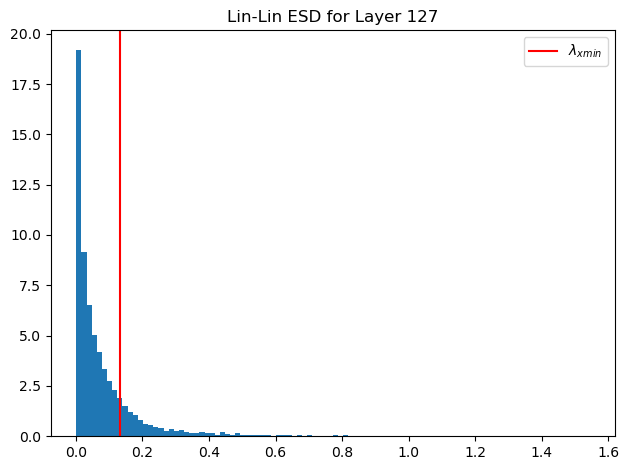

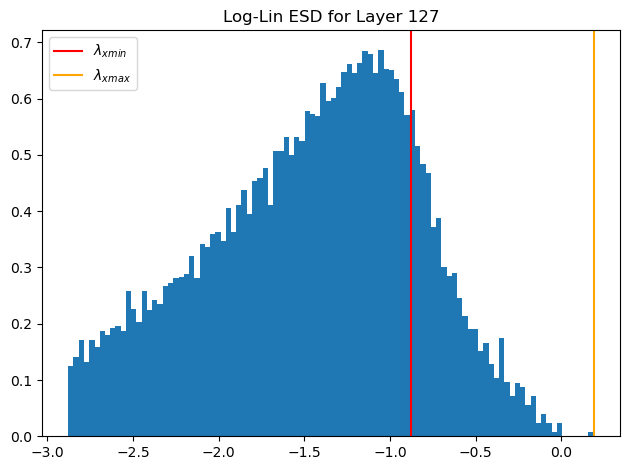

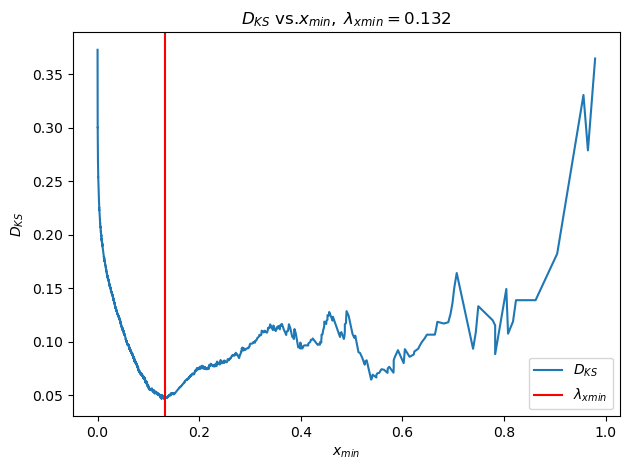

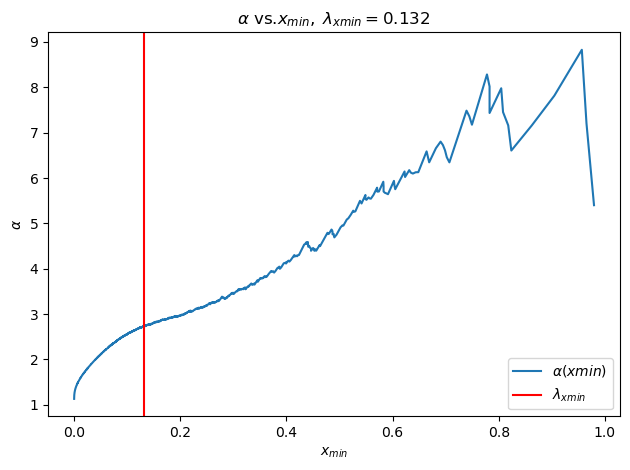

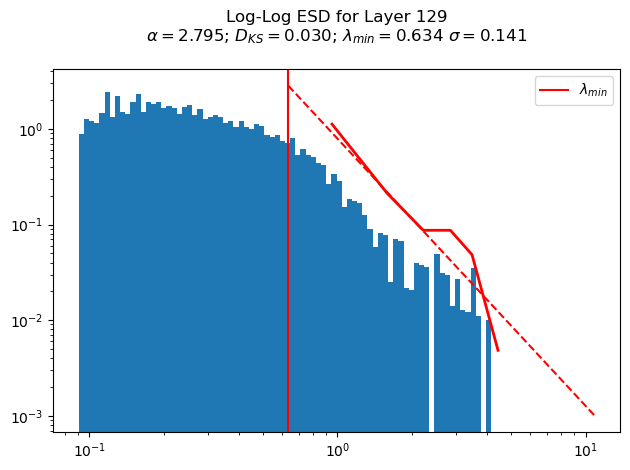

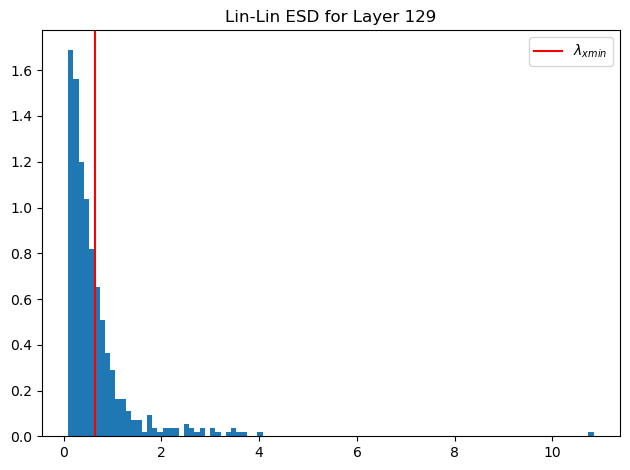

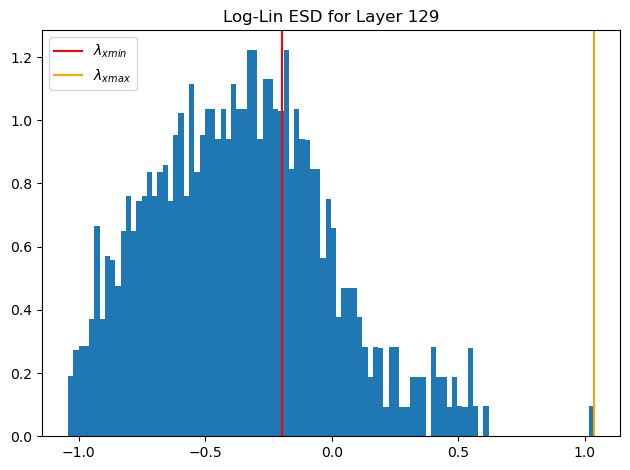

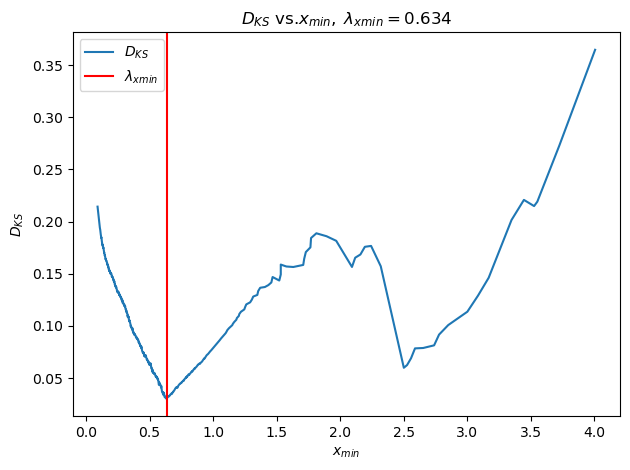

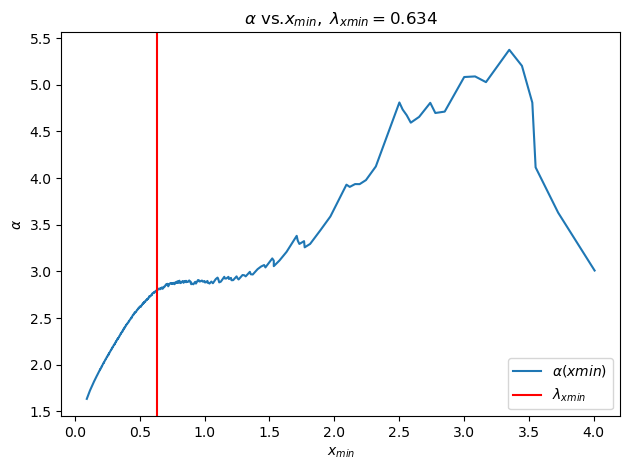

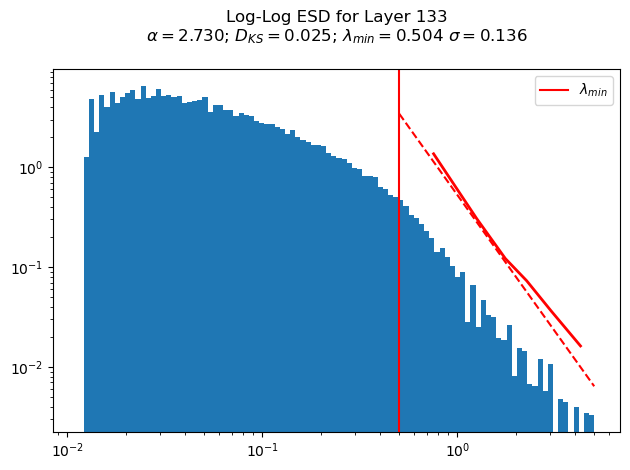

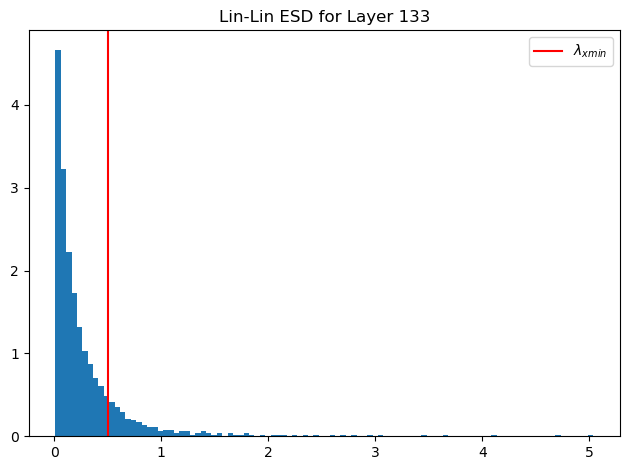

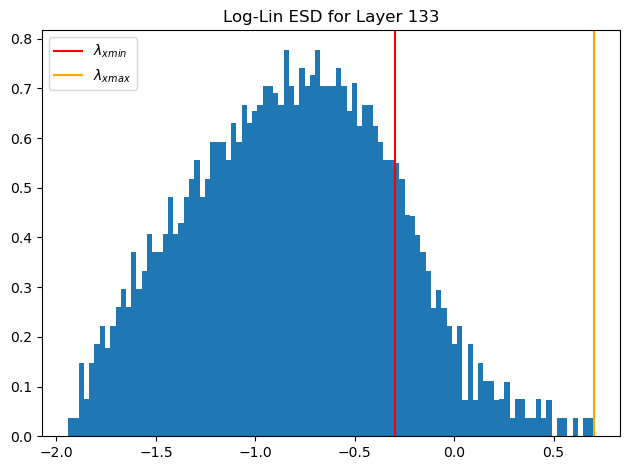

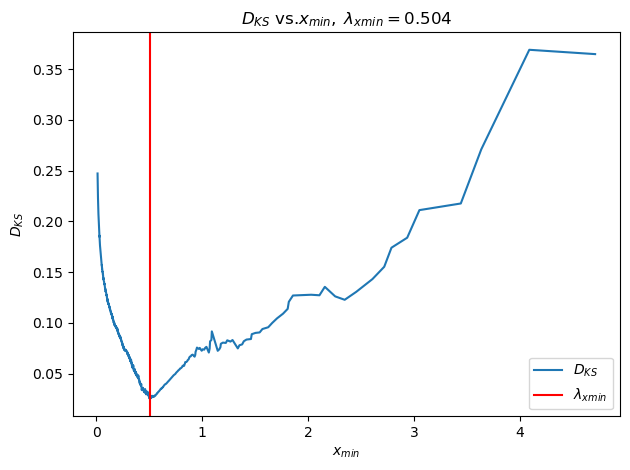

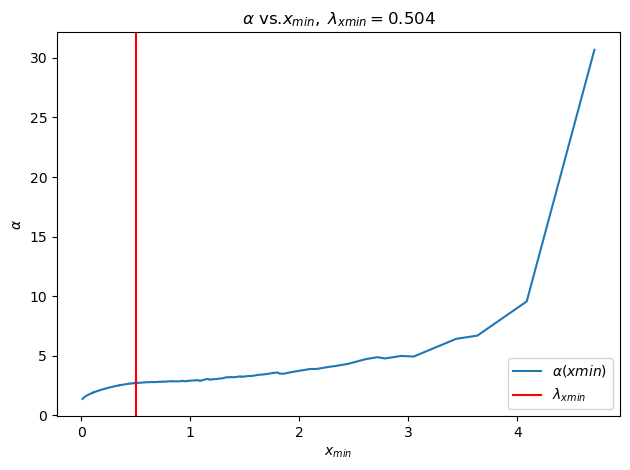

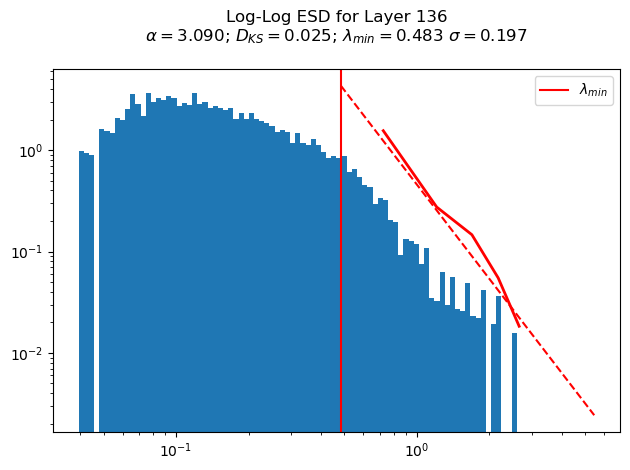

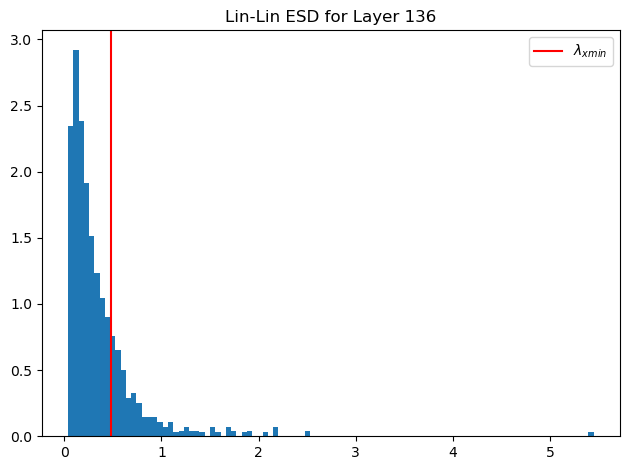

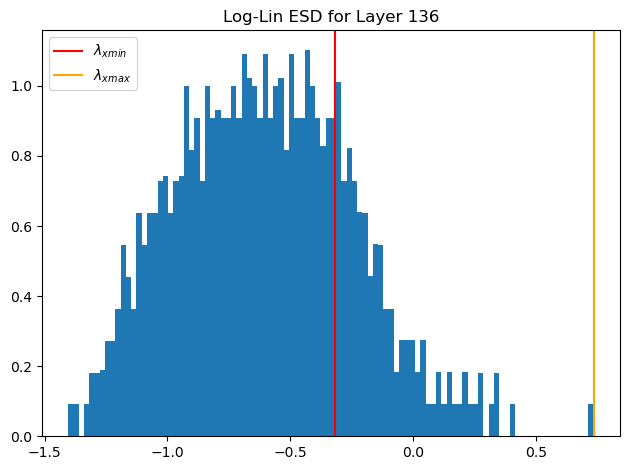

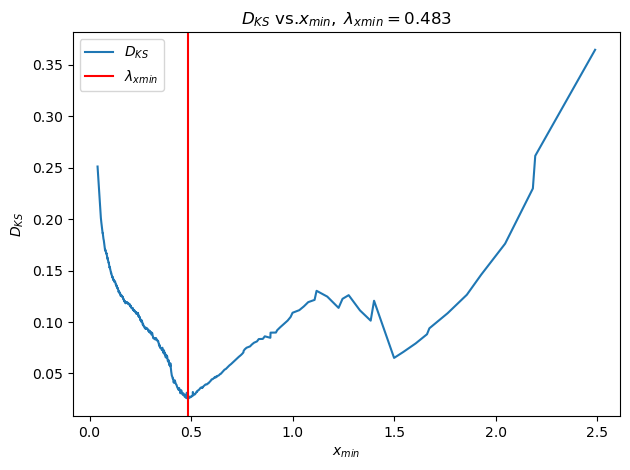

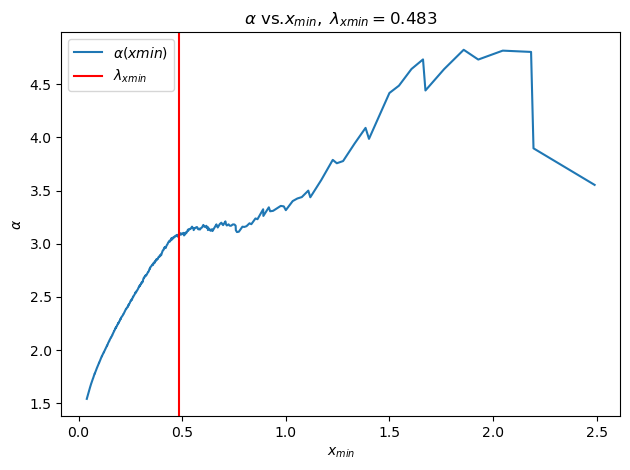

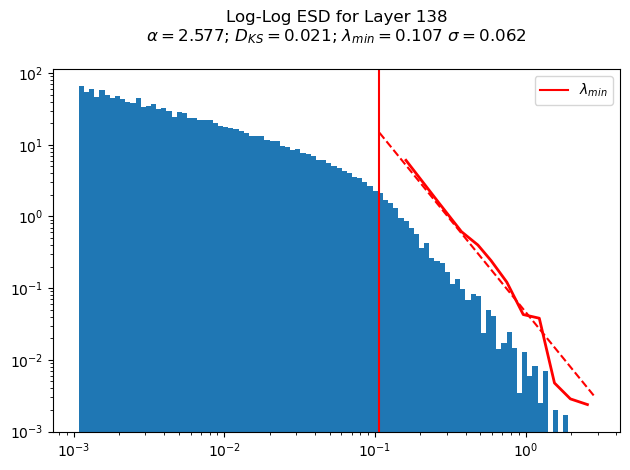

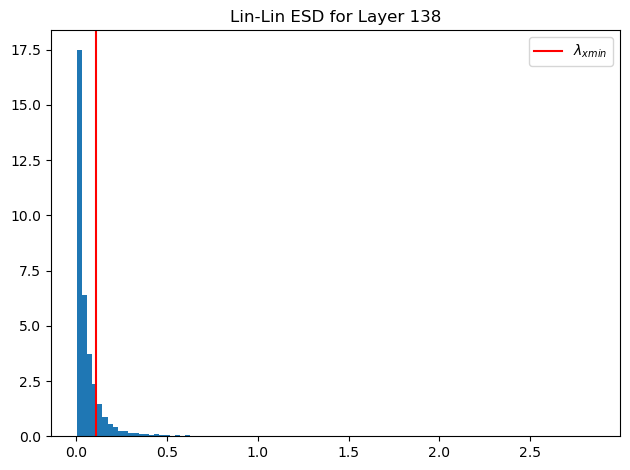

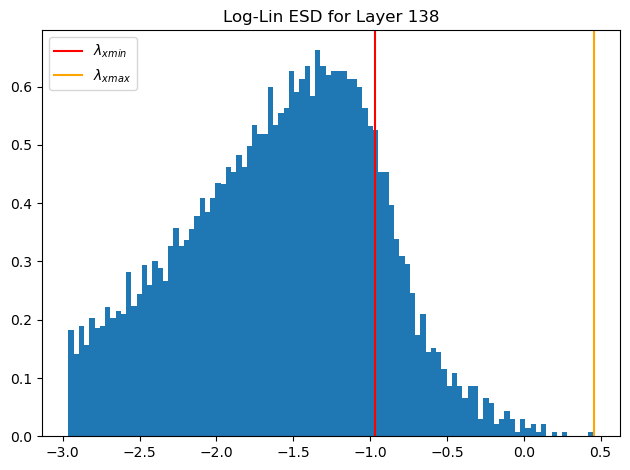

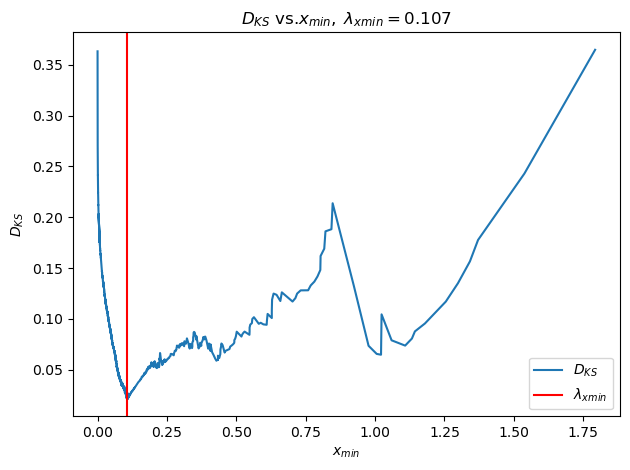

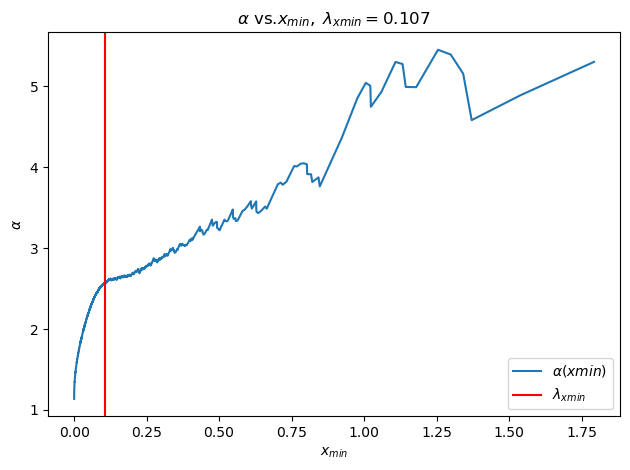

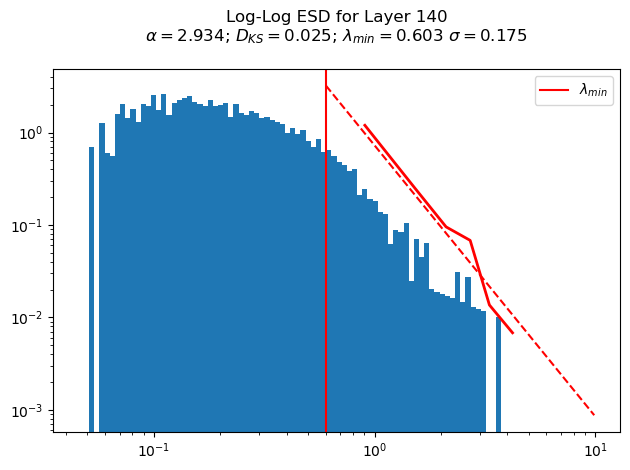

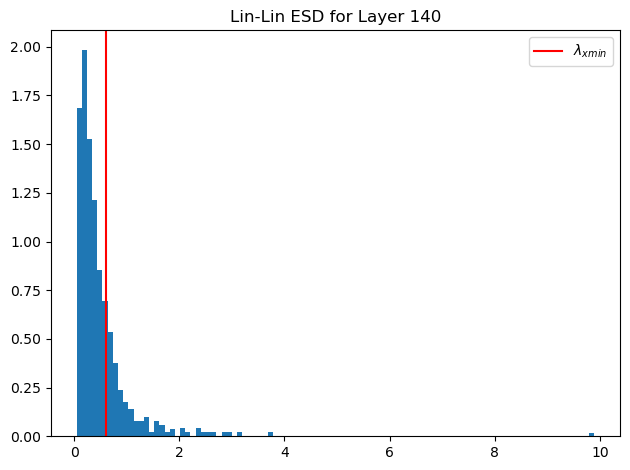

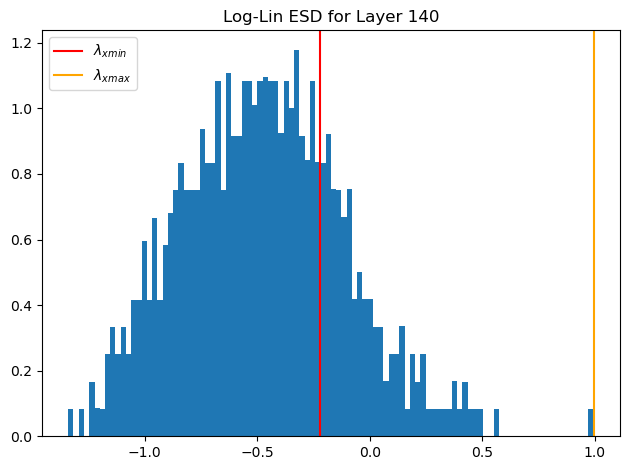

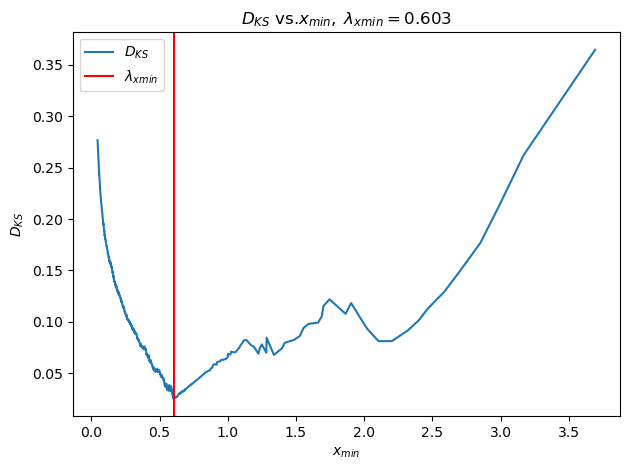

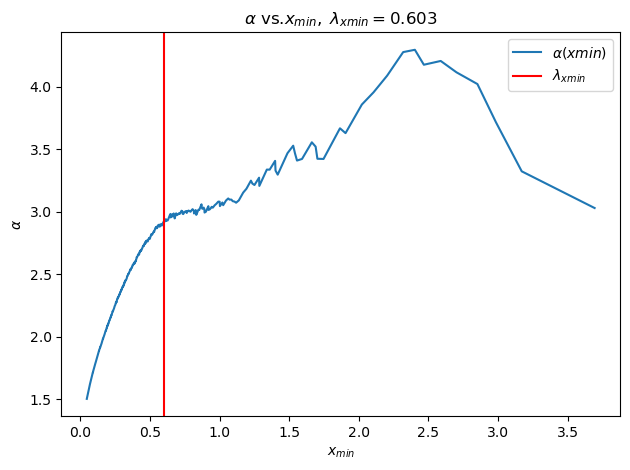

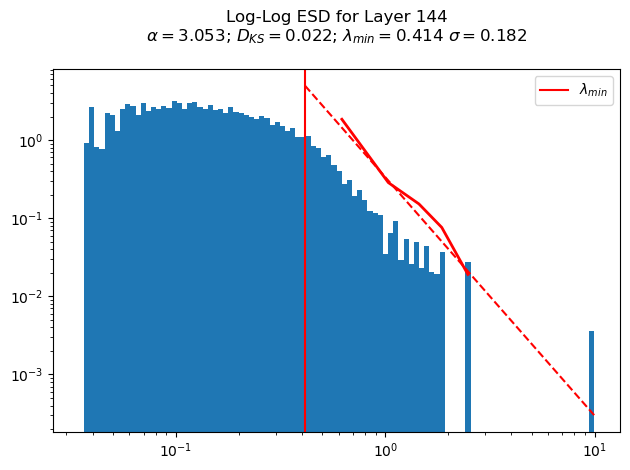

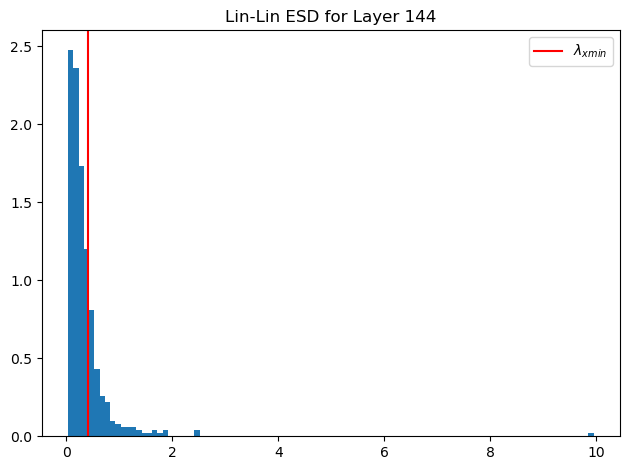

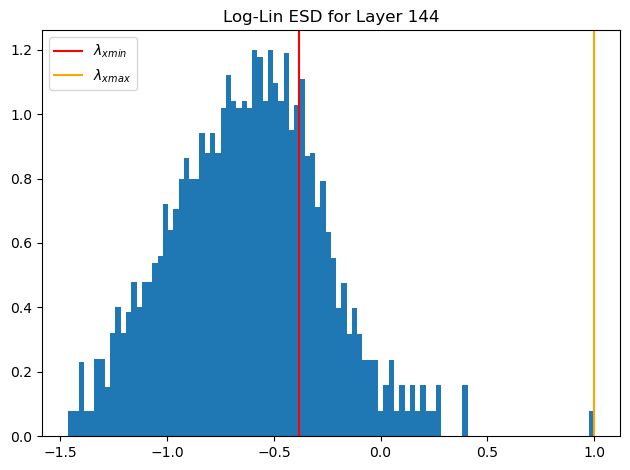

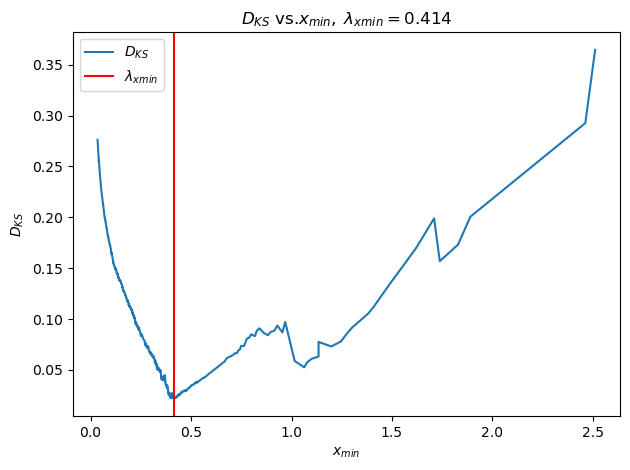

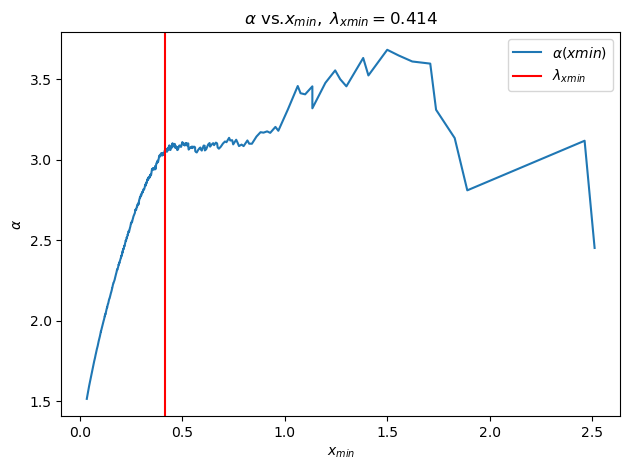

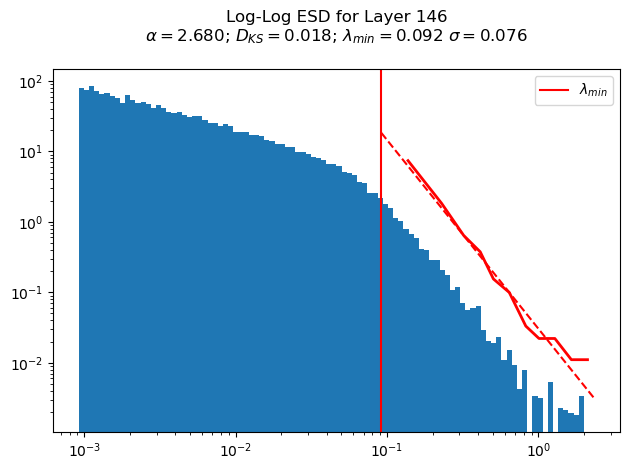

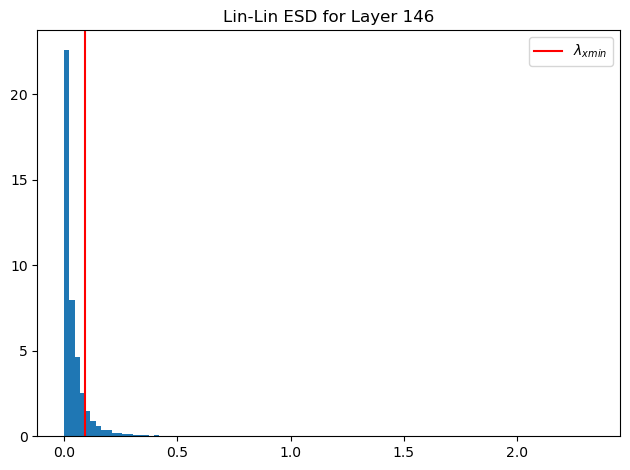

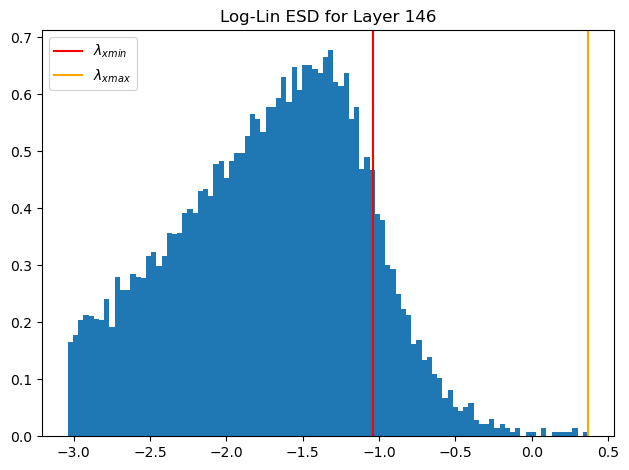

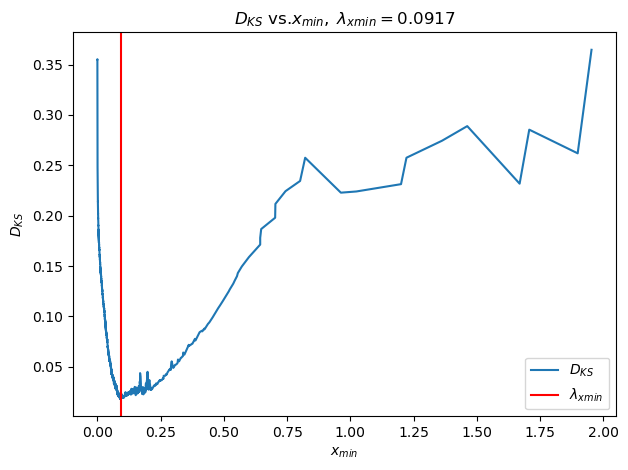

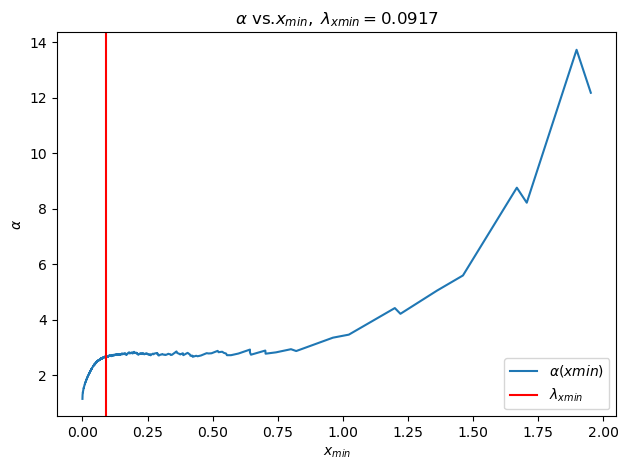

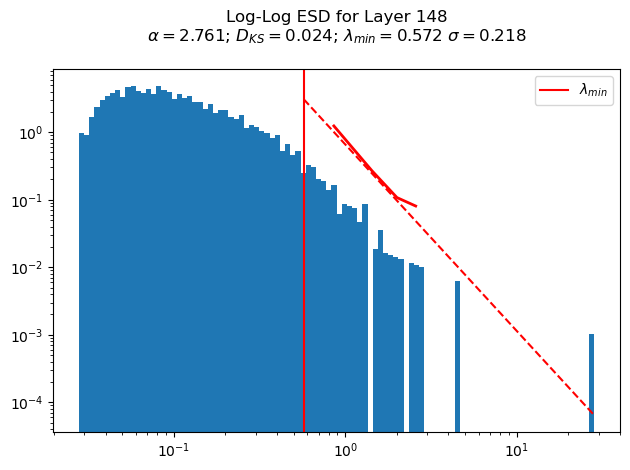

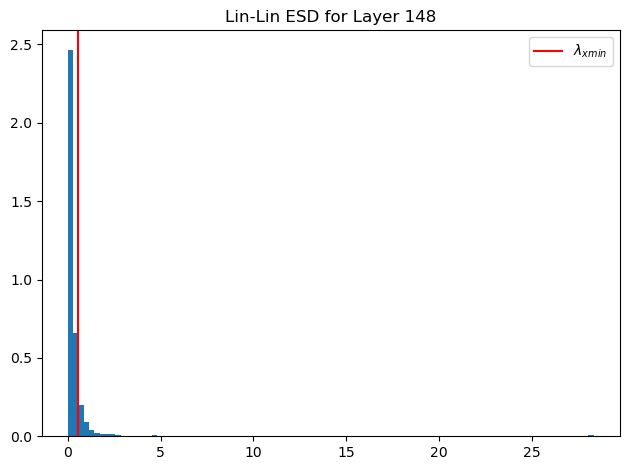

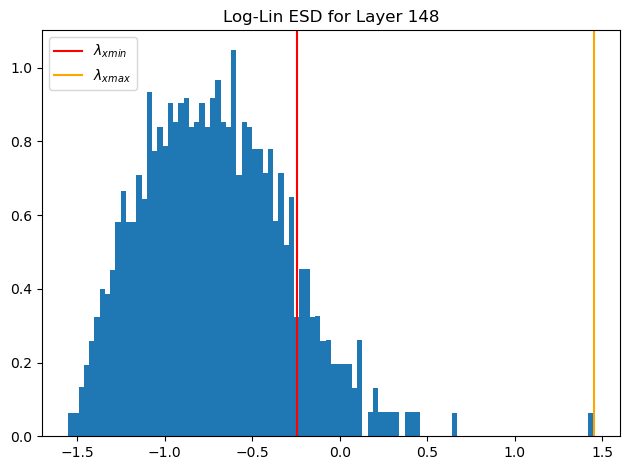

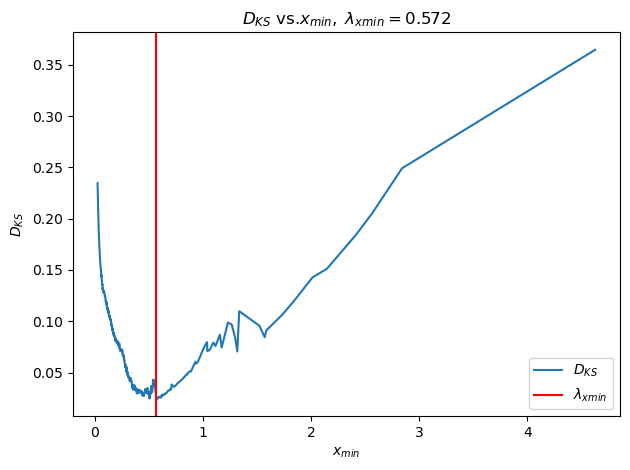

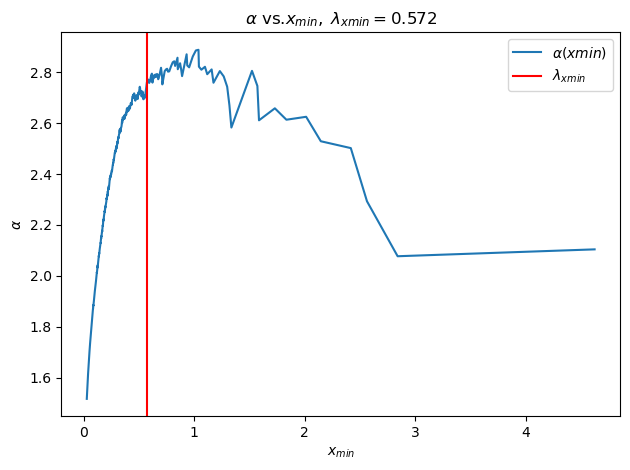

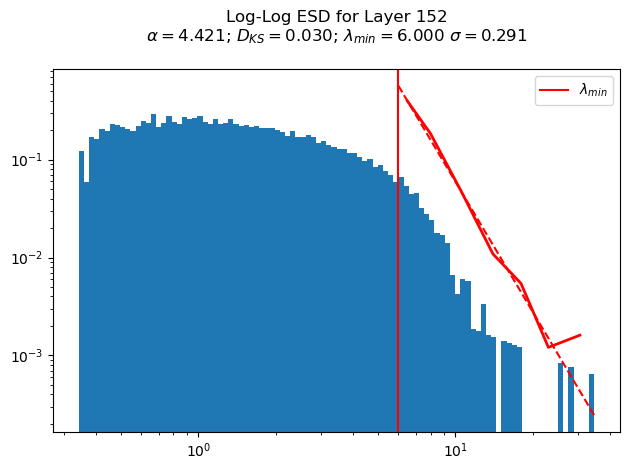

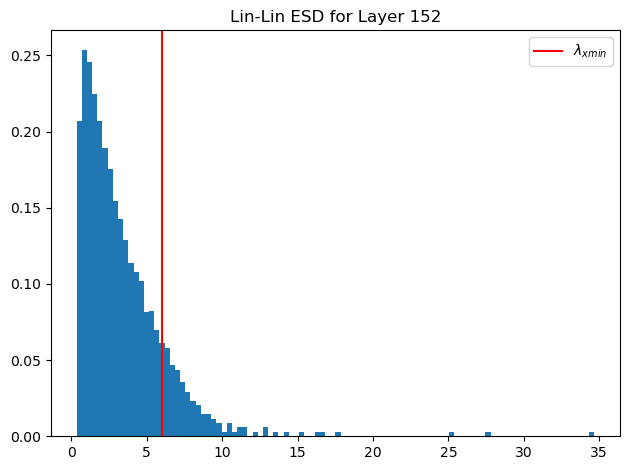

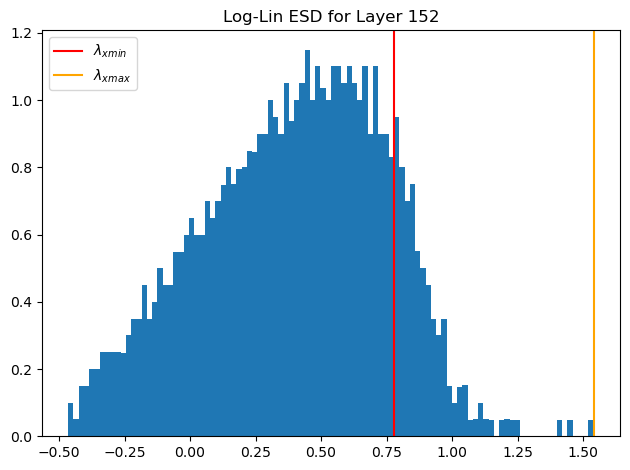

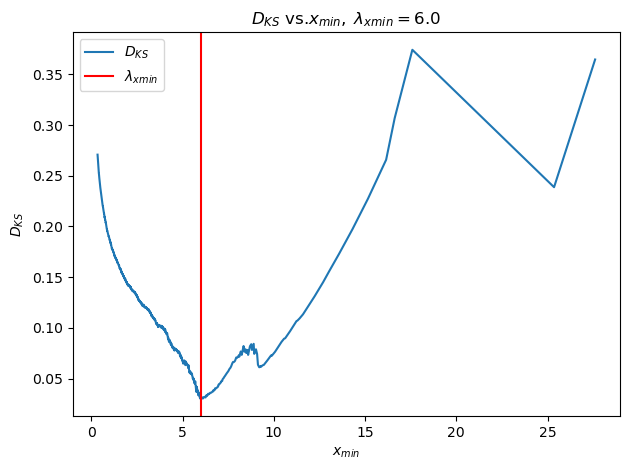

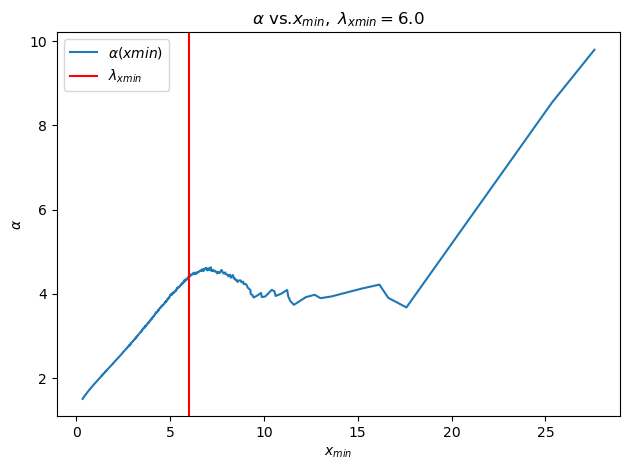

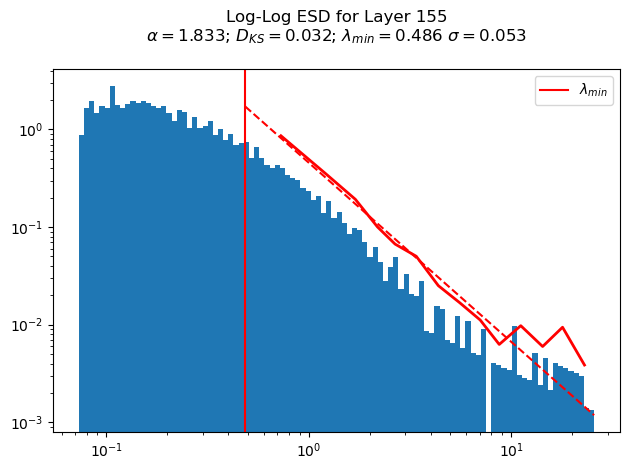

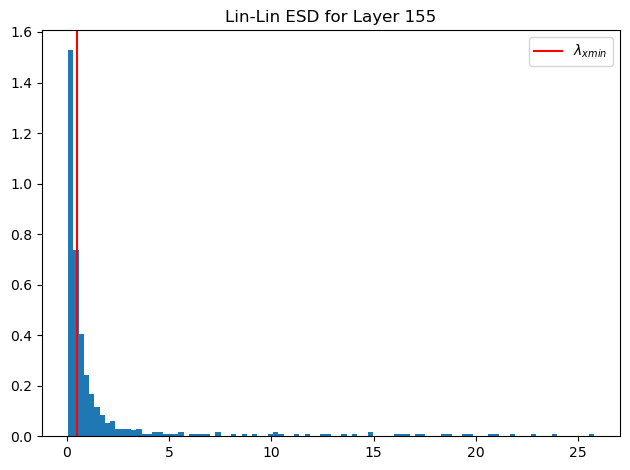

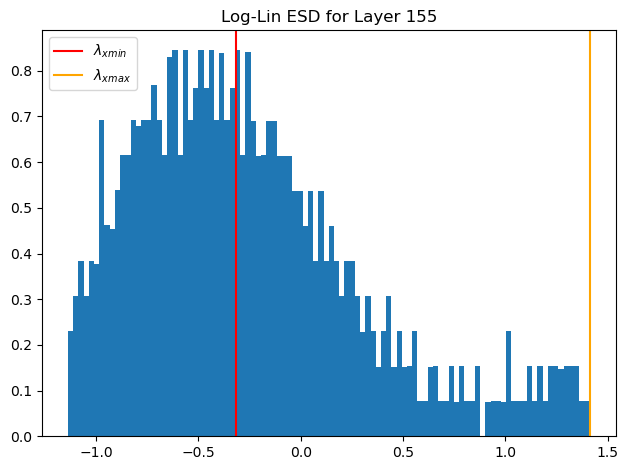

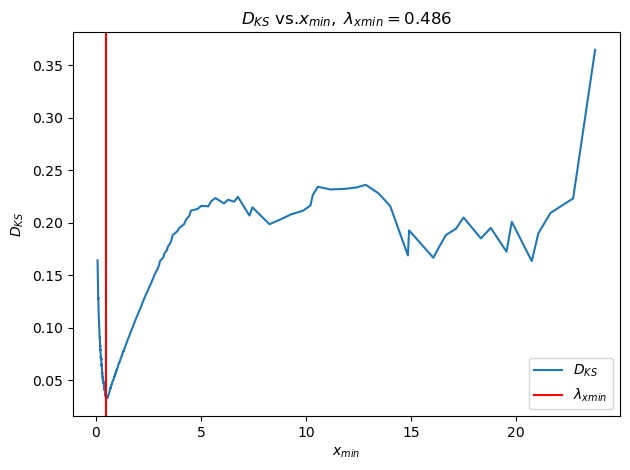

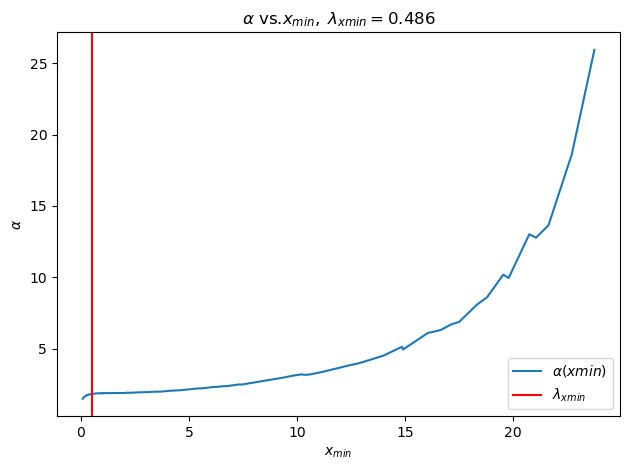

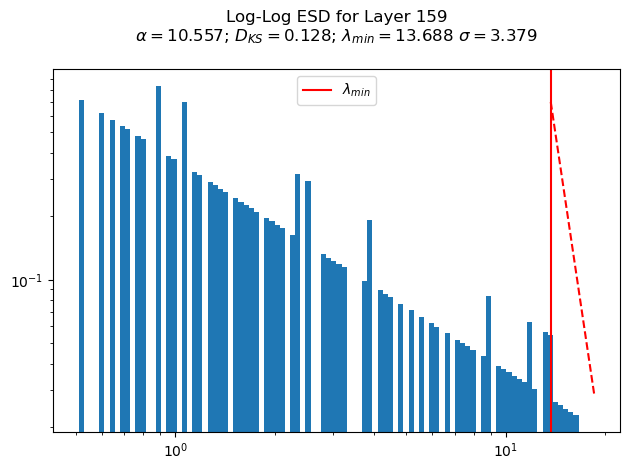

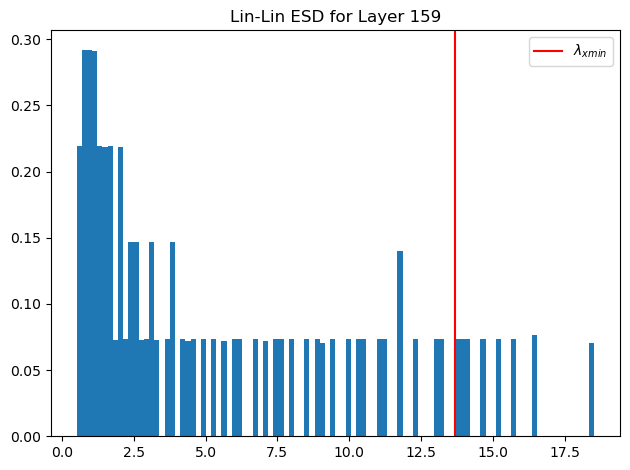

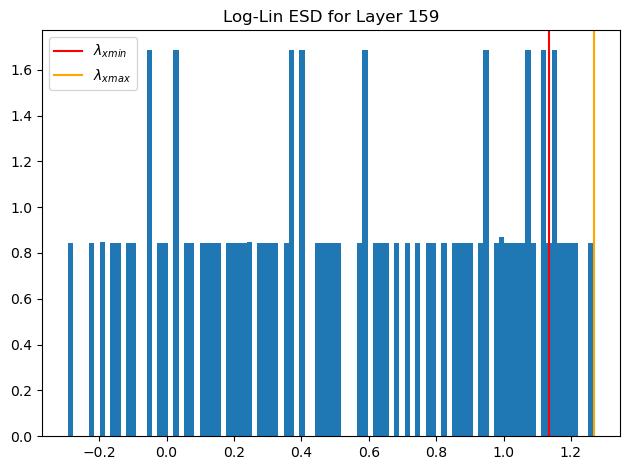

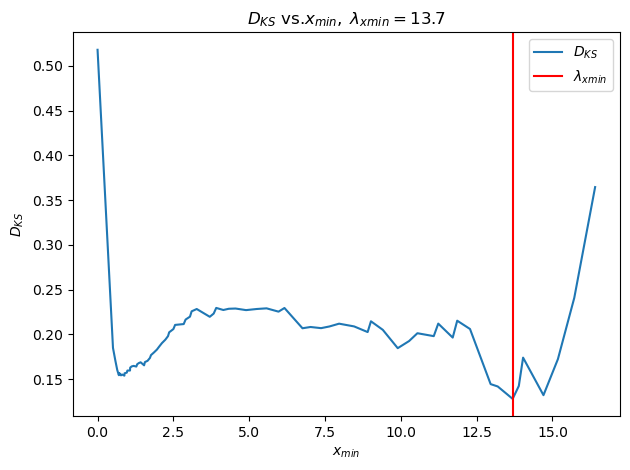

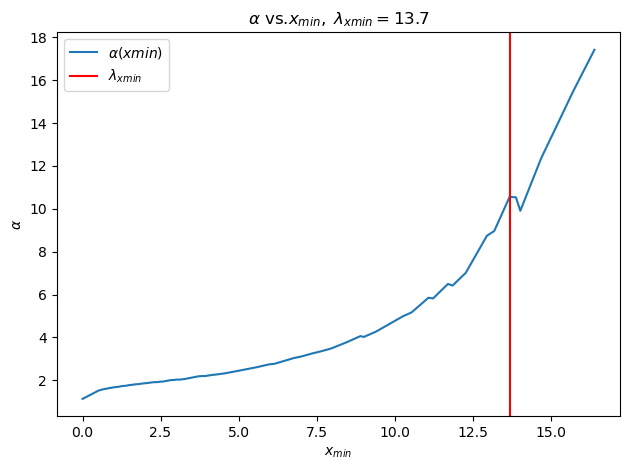

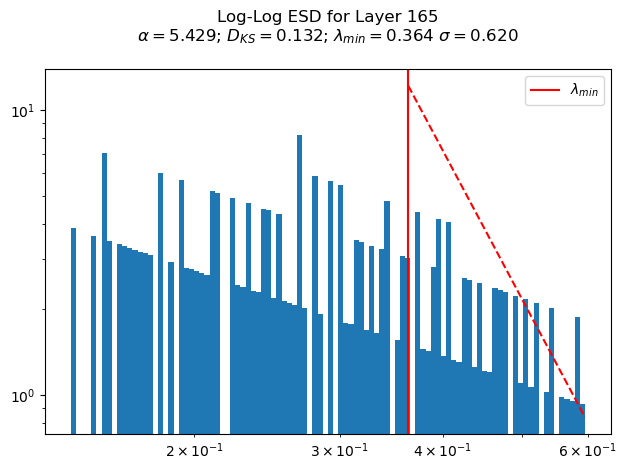

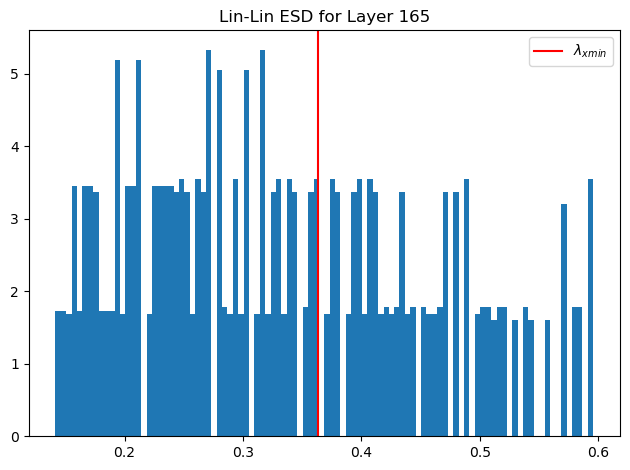

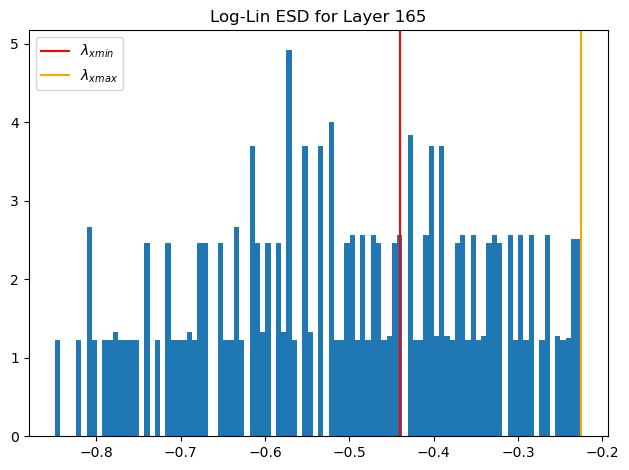

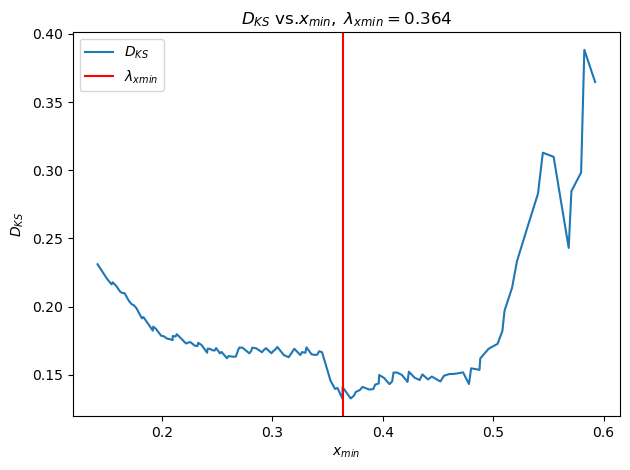

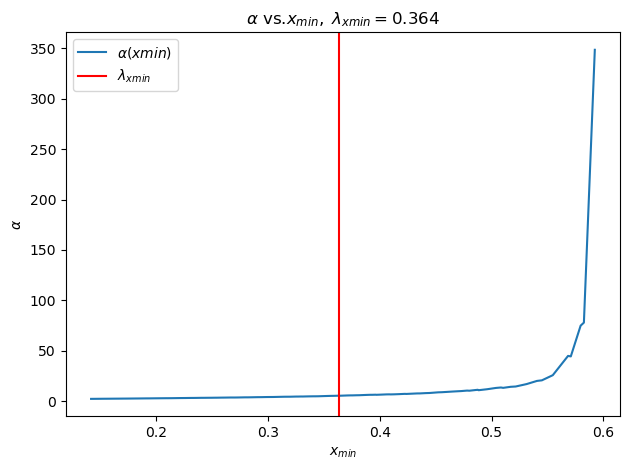

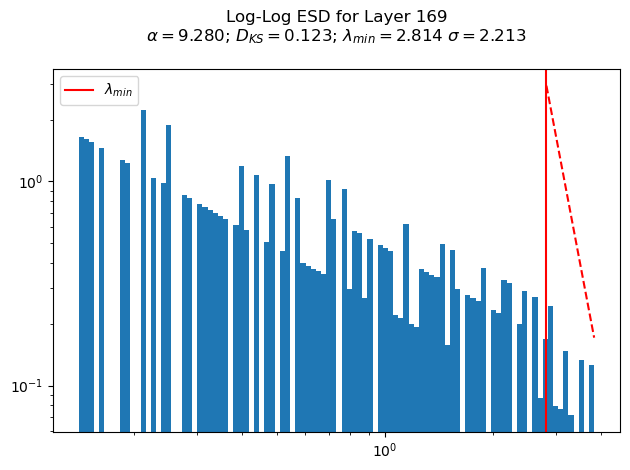

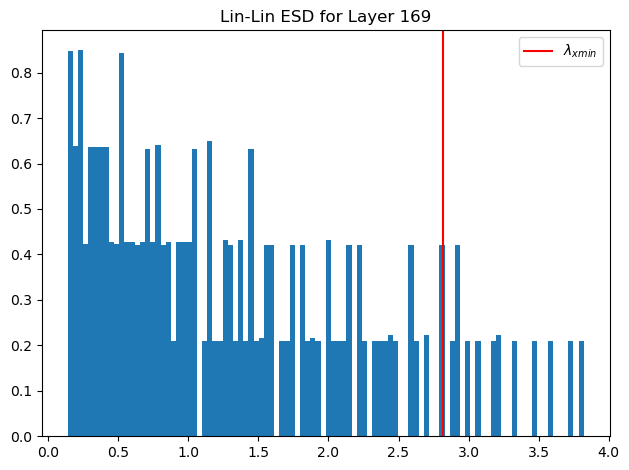

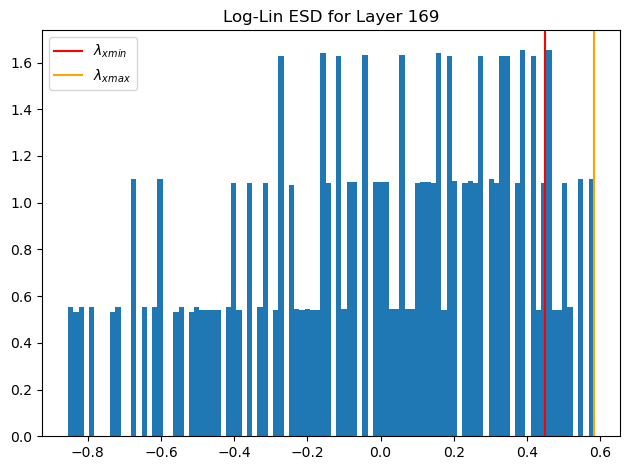

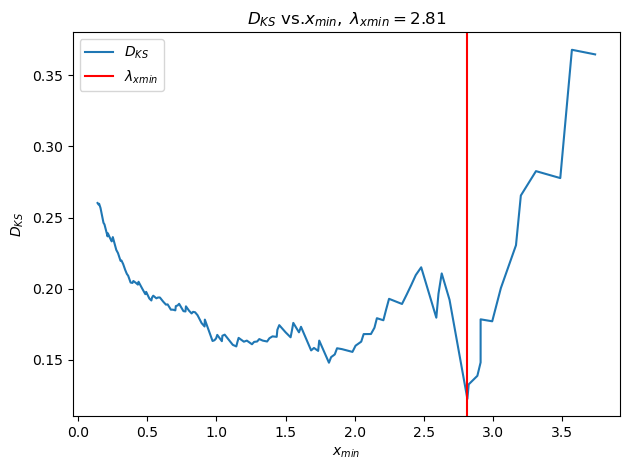

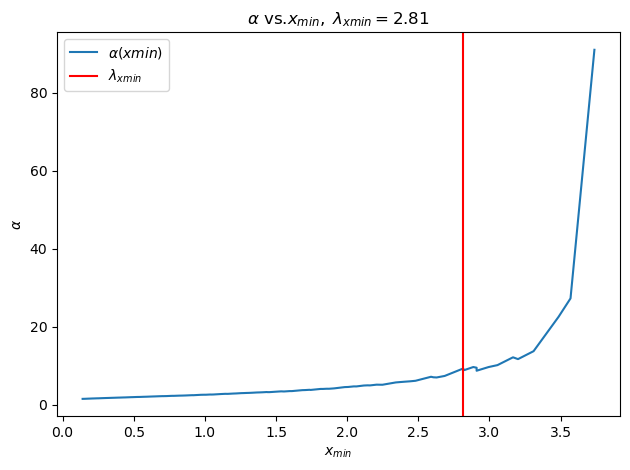

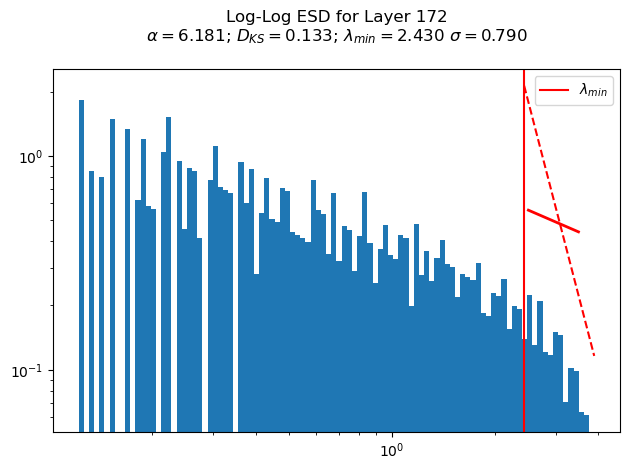

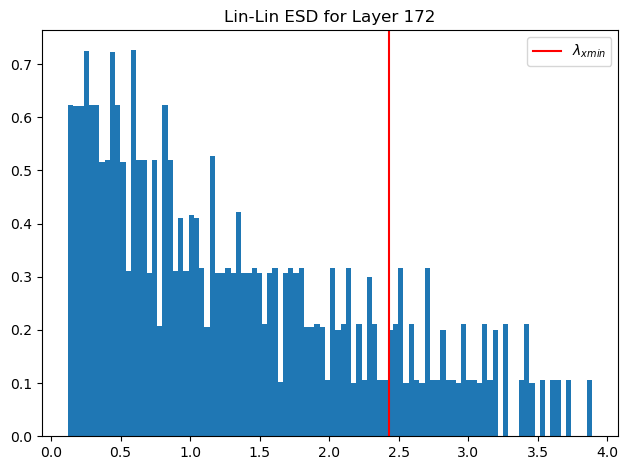

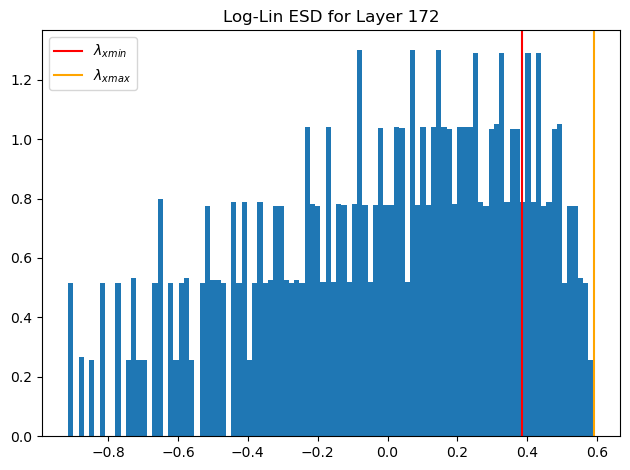

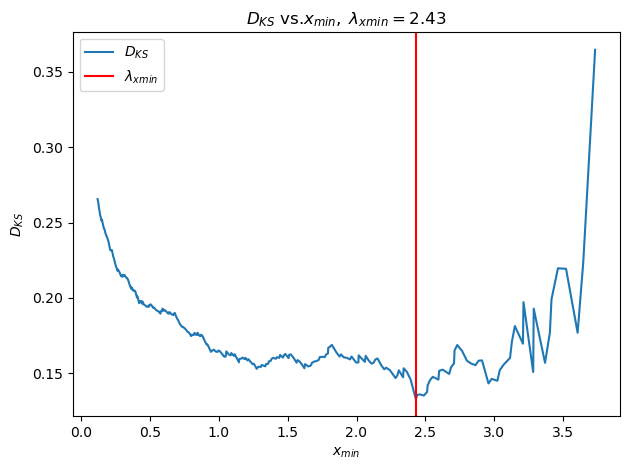

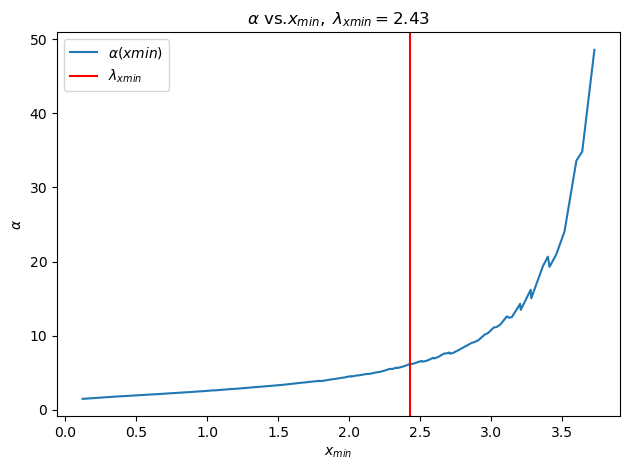

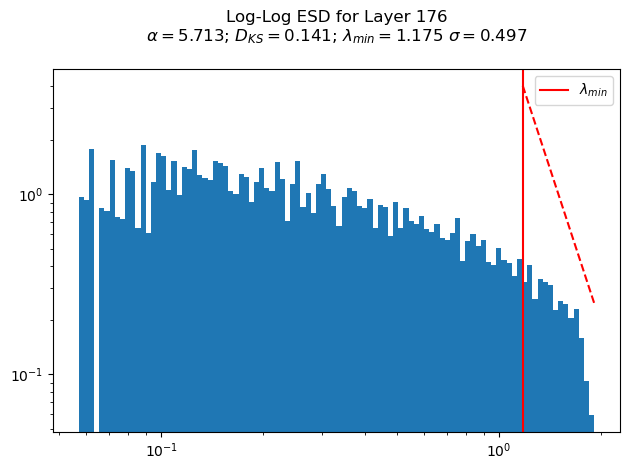

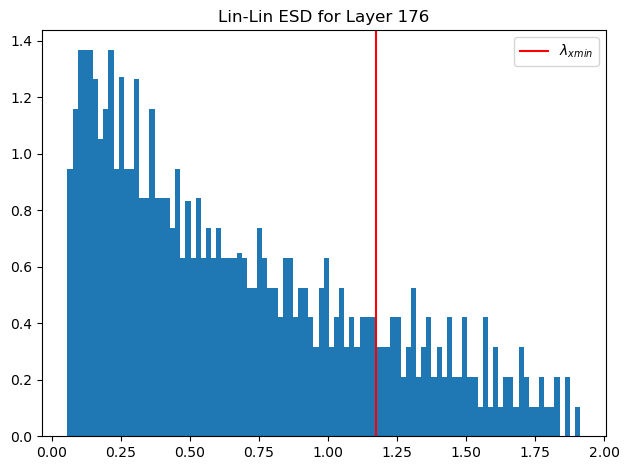

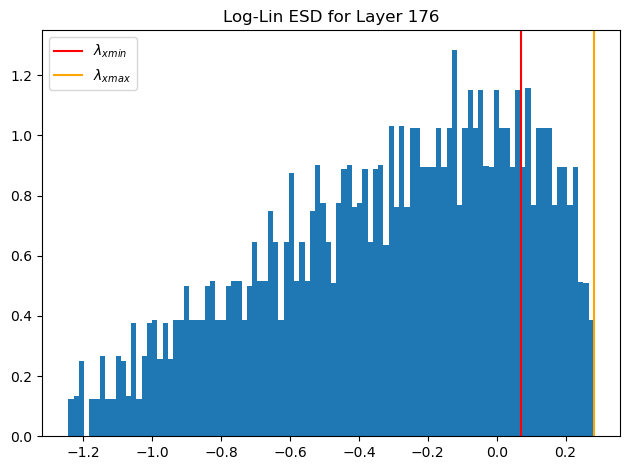

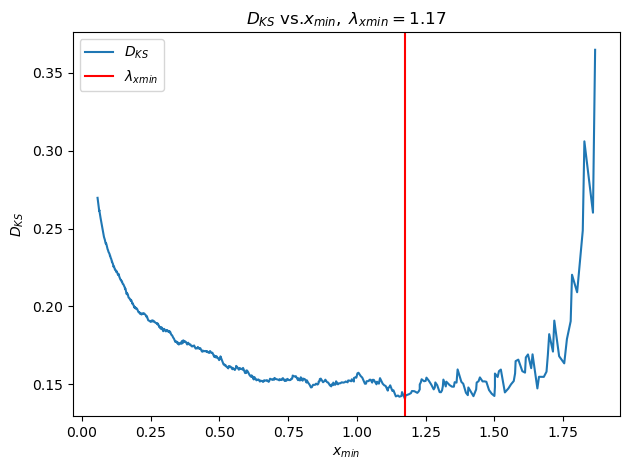

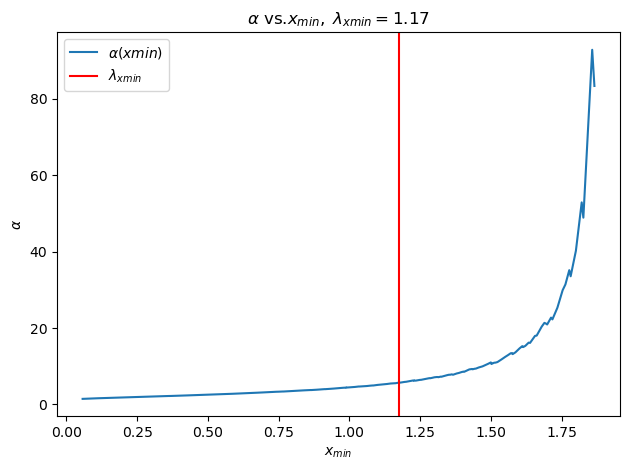

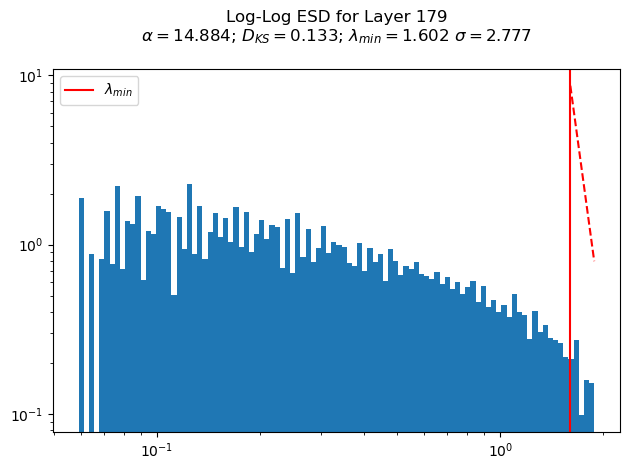

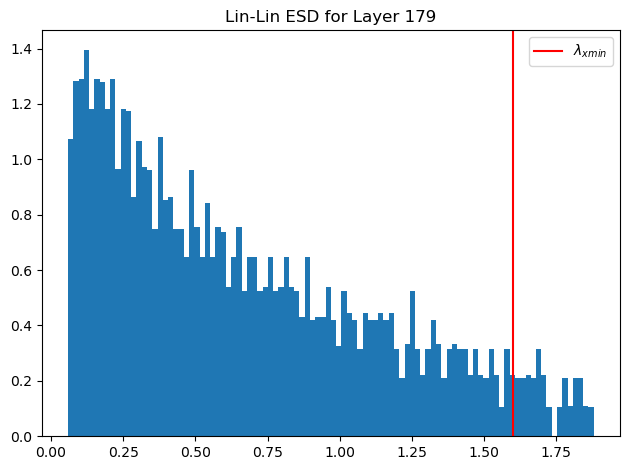

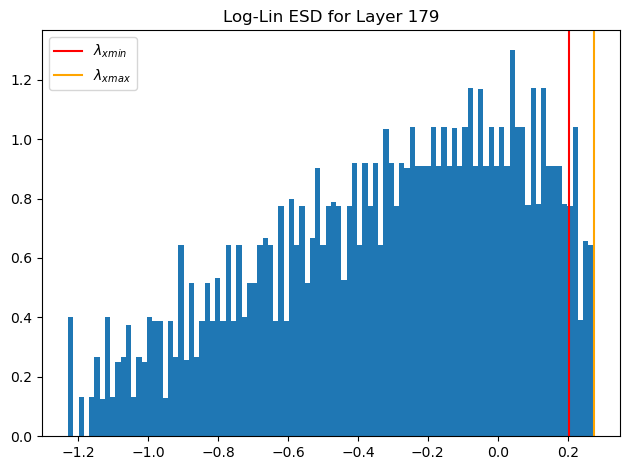

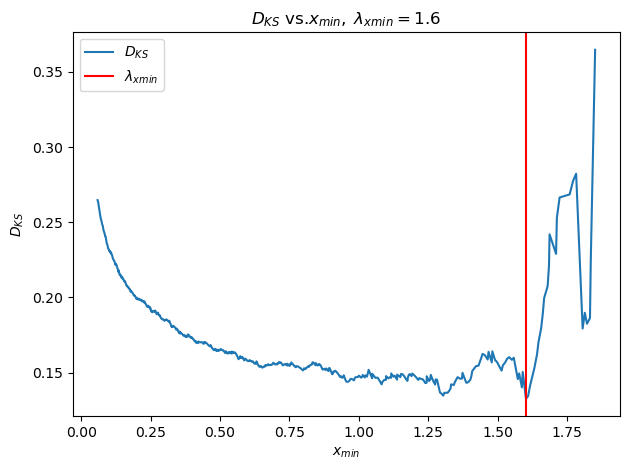

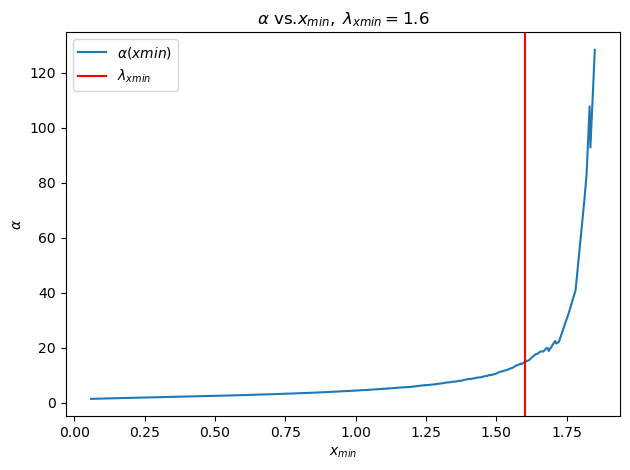

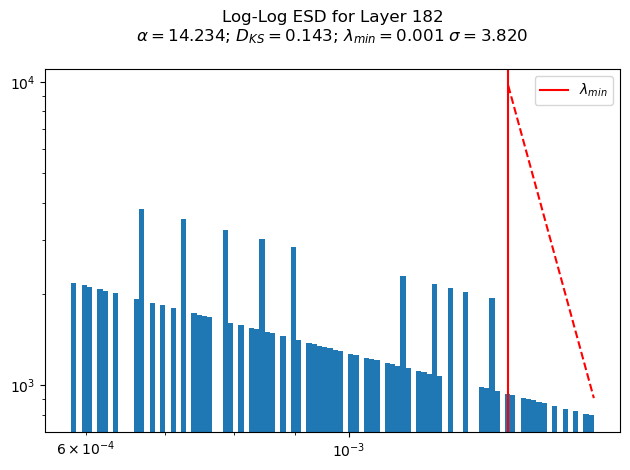

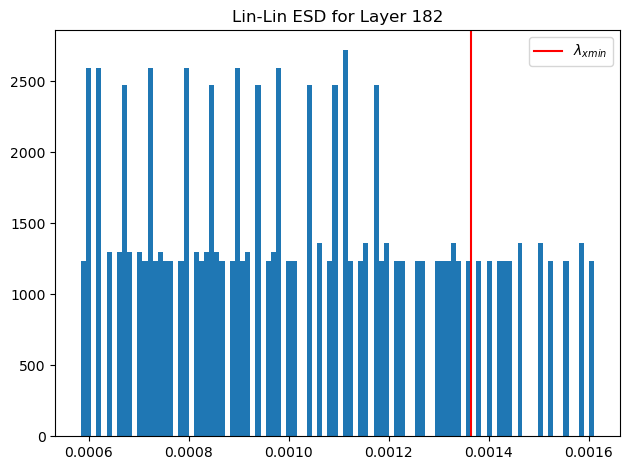

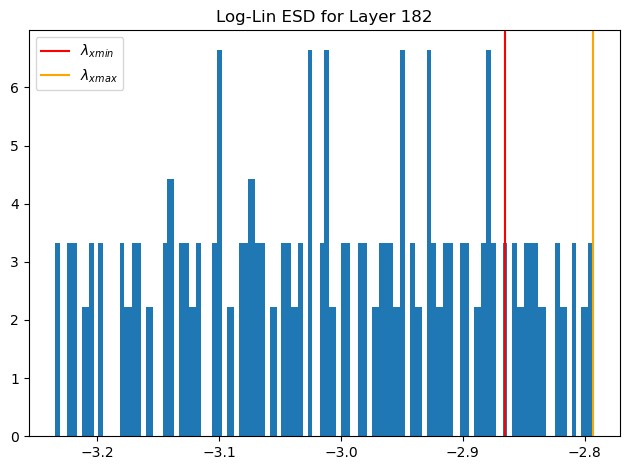

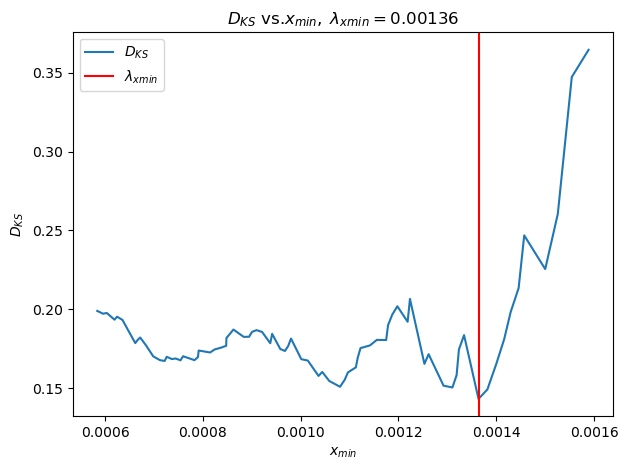

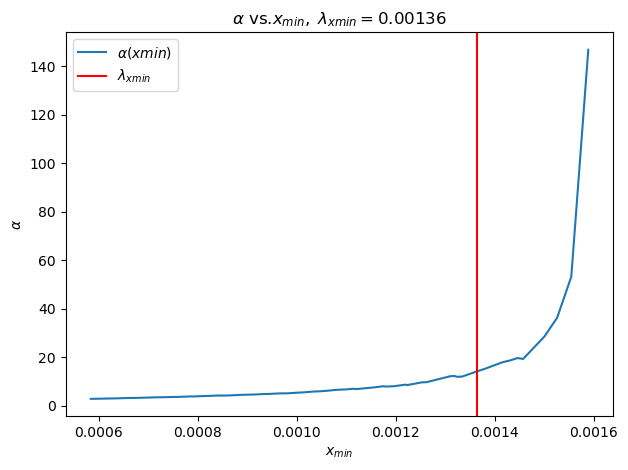

<Figure size 640x480 with 0 Axes>

In [11]:
summary = watcher.analyze(plot=True)

In [5]:
keypoints = {
    "NOSE": [0],
    "LEFT_EYE": [5],
    "RIGHT_EYE": [5],
    "LEFT_EAR": [8],
    "RIGHT_EAR": [7],
    "CHEST": [11, 12],
    "LEFT_SHOULDER": [12],
    "RIGHT_SHOULDER": [11],
    "LEFT_ELBOW": [14],
    "RIGHT_ELBOW": [13],
    "LEFT_HAND": [16, 18, 20, 22],
    "RIGHT_HAND": [15, 17, 19, 21],
    "LEFT_HIP": [24],
    "RIGHT_HIP": [23],
    "LEFT_KNEE": [26],
    "RIGHT_KNEE": [25],
    "LEFT_FOOT": [28, 30, 32],
    "RIGHT_FOOT": [27, 29, 31]
}

positions_map = dict(NOSE=0,
                     CHEST=1,
                     LEFT_SHOULDER=2,
                     LEFT_ELBOW=3,
                     LEFT_HAND=4,
                     RIGHT_SHOULDER=5,
                     RIGHT_ELBOW=6,
                     RIGHT_HAND=7,
                     LEFT_HIP=8,
                     LEFT_KNEE=9,
                     LEFT_FOOT=10,
                     RIGHT_HIP=11,
                     RIGHT_KNEE=12,
                     RIGHT_FOOT=13,
                     LEFT_EYE=14,
                     RIGHT_EYE=15,
                     LEFT_EAR=16,
                     RIGHT_EAR=17)


In [6]:
def get_features(pose: List[Dict]) -> torch.Tensor:
    list_pose = list(map(lambda s: list(s.values()), pose))
    return torch.Tensor(list_pose)


def query_and_sort_in_position(pose: List) -> torch.Tensor:
    out = {}
    re_align_positions = []

    for k, v in keypoints.items():
        out[k] = pose[v].mean(dim=0)

    for k in positions_map.keys():
        re_align_positions.append(out[k].unsqueeze(0))
    re_align_positions = torch.cat(re_align_positions)
    return re_align_positions.numpy().tolist()


def assign_new_data(s: Dict) -> Dict:
    pose: List[List[Dict]] = s['pose_landmarks'][0]
    pose_world: List[List[Dict]] = s['pose_world_landmarks']
    pose = get_features(pose=pose)
    pose = query_and_sort_in_position(pose=pose)
    pose_world = get_features(pose=pose_world)
    pose_world = query_and_sort_in_position(pose=pose_world)
    s['pose_landmarks'] = pose
    s['pose_world_landmarks'] = pose_world
    return s

In [7]:
for dataset in datasets:
    for file in ['gallery.json', 'query.json', 'train.json', 'test.json']:
        try:
            with open(f"./data/{dataset}/jsons/{file}") as f:
                content = json.load(f)
                content = list(
                    filter(lambda s: s.get("pose_landmarks", None) is not None,
                        content))
                list(map(assign_new_data, content))
            with open(f"./data/{dataset}/jsons/{file}", "w") as f:
                json.dump(obj=content, fp=f, indent=2, ensure_ascii=False)
        except:
            print(dataset)
            print(file)

cuhk03
test.json
prcc
test.json
real28
test.json
vc-clothes
test.json
market1501
test.json
